### Imports

In [1]:
import itertools
from random import *
import numpy as np
from collections import defaultdict, Counter

from sklearn.preprocessing import MultiLabelBinarizer
import keras

import matplotlib.pyplot as plt
import statistics

from scipy import stats

Using TensorFlow backend.


### Quantum circuit classes and definitions

In [2]:
class PhysicalQubit:
#relatively simple, only holds location and if it has undergone an x or z error

    def __init__(self, row, col):
        self.Xvalue = 0
        self.Zvalue = 0
        self.locationRow = row
        self.locationCol = col

    def flip_value(self, gate_type):
        if gate_type == 'x' or gate_type == 'y':
            if self.Xvalue == 1:
                self.Xvalue = 0
            else:
                self.Xvalue = 1

        if gate_type == 'z' or gate_type == 'y':
            if self.Zvalue == 1:
                self.Zvalue = 0
            else:
                self.Zvalue = 1

    def clear(self):
        self.Xvalue = 0
        self.Zvalue = 0

    def return_Xvalue(self):
        return self.Xvalue

    def return_Zvalue(self):
        return self.Zvalue
    

class AncillaQubit:

    def __init__(self, type, name):
        self.AType = type
        self.qubits = []
        self.on = False
        self.name = name
        self.row = 0
        self.col = 0

    def add_qubit(self, new_qubit):
        self.qubits.append(new_qubit)

    def setLocation(self, row, col):
        self.row = row
        self.col = col

    def connected(self, phys_qubit):
        if phys_qubit in self.qubits:
            return True
        else:
            return False

    #returns the measurement based on the error observed on its physical qubits
    def measure(self):
        total = 0
        if self.AType == "x":
            if len(self.qubits) == 2:
                if self.qubits[0].return_Xvalue() == self.qubits[1].return_Xvalue():
                    total = 1
                else:
                    total = -1
            if len(self.qubits) == 4:
                if (self.qubits[0].return_Xvalue() + self.qubits[1].return_Xvalue() + self.qubits[2].return_Xvalue() + self.qubits[3].return_Xvalue()) % 2 == 0:
                    total = 1
                else:
                    total = -1

        elif self.AType == "z":
            if len(self.qubits) == 2:
                if self.qubits[0].return_Zvalue() == self.qubits[1].return_Zvalue():
                    total += 1
                else:
                    total -= 1
            if len(self.qubits) == 4:
                if (self.qubits[0].return_Zvalue() + self.qubits[1].return_Zvalue() + self.qubits[2].return_Zvalue() + self.qubits[3].return_Zvalue()) % 2 == 0:
                    total = 1
                else:
                    total = -1
        return total
    
    
class ToricCircuit:

    def __init__(self, depth):
        self.depth = depth
        # initialize qubits to zero
        self.qubits = {}
        self.ancilla = []
        self.ancilla_matrix = [[1]*depth for _ in range(depth+1)]
        self.error_qubits_x = []
        self.error_qubits_z = []
        self.measurement_errs = {}
        for i in range(depth):
            for j in range(depth):
                qubit = PhysicalQubit(i, j)
                self.qubits.update({str(i) + str(j): qubit})
        self.create_ancilla()

    def add_random_error(self, num):
        # random flips with equal probability of x,z,or y on any qubits
        # could possibly flip already corrupted qubits to fix them
        # choose the number of physical qubits to put errors on
        error_types = ['x', 'y', 'z']
        logical_dict = []
        for i in range(num):
            a = randint(0, self.depth-1)
            b = randint(0, self.depth-1)

            type = choice(error_types)
            self.qubits.get(str(a) + str(b)).flip_value(type)
            if type == "x" or type == "y":
                self.error_qubits_x.append(self.qubits.get(str(a) + str(b)))

            if type == "z" or type == "y":
                self.error_qubits_z.append(self.qubits.get(str(a) + str(b)))

    def get_syndrome(self, prob_err):

        return_dict = {}
        for a in self.ancilla:
            return_dict.update({a.name: a.measure()})

        num_errs = 0
        if prob_err > 0:
            for a in return_dict:
                rand = random()
                if rand <= prob_err:
                    num_errs += 1
                    if return_dict[a] == -1:
                        return_dict[a] = 1
                    else:
                        return_dict[a] = -1

        else:
            errs = Counter()
            for x in self.error_qubits_x:
                errs.update({"X" + str(x.locationRow) + str(x.locationCol)})
            for z in self.error_qubits_z:
                errs.update({"Z" + str(z.locationRow) + str(z.locationCol)})

            errors_to_remove = []
            for e in errs: #for decoding, duplicate errors flip back the qubit to its intended state, so remove pairs
                if errs[e] %2 == 0:
                    errors_to_remove.append(e)
            for x in errors_to_remove:
                del errs[x]
            return_dict.update({"Labels": list(errs)})

        return return_dict


    def add_physical_errs(self, err_list):
        for err in err_list:
            if err[0] == 'x':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('x')
                self.error_qubits_x.append(self.qubits.get(str(err[1]) + str(err[2])))
            elif err[0] == 'z':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('z')
                self.error_qubits_z.append(self.qubits.get(str(err[1]) + str(err[2])))
            elif err[0] == 'y':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('x')
                self.error_qubits_x.append(self.qubits.get(str(err[1]) + str(err[2])))
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('z')
                self.error_qubits_z.append(self.qubits.get(str(err[1]) + str(err[2])))
            else:
                print("invalid input in circuit")
        return

    def clear_errors(self):
        for err_x in self.error_qubits_x:
            self.qubits.get(str(err_x.locationRow) + str(err_x.locationCol)).clear()

        for err_z in self.error_qubits_z:
            self.qubits.get(str(err_z.locationRow) + str(err_z.locationCol)).clear()

        self.error_qubits_z.clear()
        self.error_qubits_x.clear()

    def get_physical_errs(self):
        return_dict = {}
        errs = []
        for x in self.error_qubits_x:
            errs.append("X" + str(x.locationRow) + str(x.locationCol))
        for z in self.error_qubits_z:
            errs.append("Z" + str(z.locationRow) + str(z.locationCol))
        return_dict.update({"Labels": errs})

        return return_dict

    def correct_errs(self, err_list):
        err_list = err_list[0]
        for err in err_list:
            if err[0] == 'X':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('x')
                if self.qubits.get(str(err[1]) + str(err[2])) in self.error_qubits_x:
                    self.error_qubits_x.remove(self.qubits.get(str(err[1]) + str(err[2])))
                    print("Corrected qubit X"+str(err[1]) + str(err[2]))
                else:
                    self.error_qubits_x.append(self.qubits.get(str(err[1]) + str(err[2])))
                    print("Incorrectly flipped qubit X" + str(err[1]) + str(err[2]))
            elif err[0] == 'Z':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('z')
                if self.qubits.get(str(err[1]) + str(err[2])) in self.error_qubits_z:
                    self.error_qubits_z.remove(self.qubits.get(str(err[1]) + str(err[2])))
                    print("Corrected qubit Z" + str(err[1]) + str(err[2]))
                else:
                    self.error_qubits_z.append(self.qubits.get(str(err[1]) + str(err[2])))
                    print("Incorrectly flipped qubit Z" + str(err[1]) + str(err[2]))
            else:
                return

    def check_max_errs(self, max_errors):
        if len(self.error_qubits_x) + len(self.error_qubits_z) > max_errors:
            return False
        else:
            return True

    def create_ancilla(self):
        # This adds the ancilla with their correct physical qubits attached
        # only for depth of 3,5,7 code described here:https://arxiv.org/pdf/1811.12456.pdf
        count = 0

        for i in range(self.depth - 1):

            if i % 2 == 0:
                #start with z ancilla
                j = 0
                while j < self.depth:
                    if i == 0 and j != (self.depth - 1):
                        #ancilla located about the grid
                        newX = AncillaQubit("x", "X" + str(count))
                        newX.add_qubit(self.qubits.get(str(i) + str(j)))
                        newX.add_qubit(self.qubits.get(str(i) + str(j + 1)))
                        newX.setLocation(i,j)
                        self.ancilla.append(newX)
                        count += 1
                    if j == (self.depth - 1):
                        #at the right most edge ancilla
                        newZ = AncillaQubit("z", "Z" + str(count))
                        newZ.add_qubit(self.qubits.get(str(i) + str(j)))
                        newZ.add_qubit(self.qubits.get(str(i + 1) + str(j)))
                        newZ.setLocation(i+1, j)
                        self.ancilla.append(newZ)
                        count += 1

                    #those two if statements check to see if the code is at the upper boundary and adds the ancilla at the top
                    else:
                        newZ = AncillaQubit("z", "Z" + str(count))
                        newZ.add_qubit(self.qubits.get(str(i) + str(j))) #upper left corner
                        newZ.add_qubit(self.qubits.get(str(i) + str(j+1))) # upper right corner
                        newZ.add_qubit(self.qubits.get(str(i+1) + str(j)))  #lower left corner
                        newZ.add_qubit(self.qubits.get(str(i+1) + str(j + 1)))  #lower right corner
                        newZ.setLocation(i+1, j)
                        count += 1

                        newX = AncillaQubit("x", "X" + str(count))
                        newX.add_qubit(self.qubits.get(str(i) + str(j+1)))
                        newX.add_qubit(self.qubits.get(str(i) + str(j + 2)))
                        newX.add_qubit(self.qubits.get(str(i + 1) + str(j+1)))
                        newX.add_qubit(self.qubits.get(str(i + 1) + str(j + 2)))
                        newX.setLocation(i+1, j+1)
                        count += 1

                        self.ancilla.append(newZ)
                        self.ancilla.append(newX)
                    j = j+2
            else:
                #start witth x ancilla, new row
                j = 0
                while j < self.depth-1:
                    if j == 0:
                        #add z ancilla to the far left
                        newZ = AncillaQubit("z","Z" + str(count))
                        newZ.add_qubit(self.qubits.get(str(i) + str(j)))
                        newZ.add_qubit(self.qubits.get(str(i + 1) + str(j)))
                        newZ.setLocation(i+1, j)
                        self.ancilla.append(newZ)
                        count += 1

                    newX = AncillaQubit("x", "X" + str(count))
                    newX.add_qubit(self.qubits.get(str(i) + str(j)))
                    newX.add_qubit(self.qubits.get(str(i) + str(j + 1)))
                    newX.add_qubit(self.qubits.get(str(i + 1) + str(j)))
                    newX.add_qubit(self.qubits.get(str(i + 1) + str(j + 1)))
                    newX.setLocation(i+1, j+1)
                    self.ancilla.append(newX)
                    count += 1

                    if i == (self.depth - 2) and j < (self.depth - 1):
                        #checks if this is the last row, if it is, then add the ancilla on the bottom
                        newX =AncillaQubit("x", "X" + str(count))
                        newX.add_qubit(self.qubits.get(str(i + 1) + str(j + 1)))
                        newX.add_qubit(self.qubits.get(str(i + 1) + str(j + 2)))
                        newX.setLocation(i+2, j+2)
                        self.ancilla.append(newX)
                        count += 1

                    newZ = AncillaQubit("z", "Z" + str(count))
                    newZ.add_qubit(self.qubits.get(str(i) + str(j + 1)))
                    newZ.add_qubit(self.qubits.get(str(i) + str(j + 2)))
                    newZ.add_qubit(self.qubits.get(str(i + 1) + str(j + 1)))
                    newZ.add_qubit(self.qubits.get(str(i + 1) + str(j + 2)))
                    newZ.setLocation(i+1, j+2)
                    count += 1

                    self.ancilla.append(newZ)
                    j = j + 2
        return
    
    
def create_list_from_string(err_list):
    newstring = err_list.replace("'", "")
    new_err_list = newstring.strip('][').split(', ')
    return set(new_err_list)

# Depth 3

In [9]:
circuit = ToricCircuit(3)
d3_dist = []

#make the multilabel binarizer
mlb = MultiLabelBinarizer()
mlb.fit([['X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20',
 'X21', 'X22','Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 
 'Z20', 'Z21', 'Z22']])

#load NN model
model = keras.models.load_model('MODELS/model_d3_v3-10k.h5')
model.summary()

#repeat test 1000 times
for i in range (1000):
    count = 0

    while circuit.check_max_errs(3): #while total data qubit errors < depth
        
        circuit.add_random_error(1) #add an error to the circuit
        syn = circuit.get_syndrome(0) #get the syndrome
        del syn['Labels'] #forget about the labels, not needed at this time
        vals = list(syn.values())
        vals = np.array(vals)
        vals = np.expand_dims(vals, axis=0) #these few lines are just to get the data in the right format

        errors = circuit.get_physical_errs() #get the data qubit errors
        errors = errors.get('Labels')
        print(errors)
        multilabelerrs = mlb.transform([errors])

        print(vals)
        
        prediction = model.predict(vals) #use NN model to predict corrections
        prediction[prediction>=.3]=1 #use threshold found in training 
        prediction[prediction<.3]=0
        correction =mlb.inverse_transform(prediction) #Do the inverse transform to get corrections to use in sim
        print(correction)
        circuit.correct_errs(correction) #correct errrors predicted
        count += 1 #increase count of error correction cycles
        
    circuit.clear_errors() #clear errors of 
    d3_dist.append(count) #k
    
print(d3_dist)
print(statistics.mean(d3_dist))
print(statistics.stdev(d3_dist))

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_151 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_152 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_153 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_154 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_155 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_156 (Dense)            (None, 18)                594       
Total params: 4,122
Trainable params: 4,122
Non-trainable params: 0
___________________________________________________

[('X00', 'X01', 'X21', 'X22')]
Incorrectly flipped qubit X00
Corrected qubit X01
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
['Z10']
[[ 1 -1  1  1 -1  1  1  1]]
[('Z10', 'Z20')]
Corrected qubit Z10
Incorrectly flipped qubit Z20
['X21', 'Z20']
[[ 1  1  1  1 -1 -1 -1  1]]
[('X21', 'X22', 'Z10', 'Z20')]
Corrected qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z10
Corrected qubit Z20
['X22', 'Z10', 'Z01']
[[ 1  1  1  1 -1  1 -1  1]]
[('X21', 'X22', 'Z10', 'Z20')]
Incorrectly flipped qubit X21
Corrected qubit X22
Corrected qubit Z10
Incorrectly flipped qubit Z20
['X21', 'X11', 'Z01', 'Z20']
[[ 1 -1 -1  1 -1  1 -1  1]]
[('X21', 'X22', 'Z10', 'Z20')]
Corrected qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z10
Corrected qubit Z20
['Z11']
[[ 1 -1  1  1  1  1  1 -1]]
[('X02', 'X10', 'X11', 'X20', 'Z00', 'Z01', 'Z11', 'Z21', 'Z22')]
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped q

[('X00', 'X01', 'X21', 'X22')]
Corrected qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
['Z20']
[[ 1  1  1  1 -1  1  1  1]]
[('Z10', 'Z20')]
Incorrectly flipped qubit Z10
Corrected qubit Z20
['X21', 'Z10', 'Z21']
[[ 1 -1  1  1 -1 -1 -1 -1]]
[('X21', 'X22', 'Z10', 'Z20')]
Corrected qubit X21
Incorrectly flipped qubit X22
Corrected qubit Z10
Incorrectly flipped qubit Z20
['X22', 'Z21', 'Z20', 'Z12']
[[ 1  1  1 -1 -1  1 -1  1]]
[('X21', 'X22', 'Z02', 'Z10', 'Z12', 'Z20')]
Incorrectly flipped qubit X21
Corrected qubit X22
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Corrected qubit Z12
Corrected qubit Z20
['X12', 'Z12']
[[ 1  1 -1 -1  1  1  1 -1]]
[('Z02', 'Z12', 'Z22')]
Incorrectly flipped qubit Z02
Corrected qubit Z12
Incorrectly flipped qubit Z22
['X12', 'X00', 'Z02', 'Z22']
[[-1  1 -1 -1  1  1  1 -1]]
[('X00', 'X01', 'Z02', 'Z12')]
Corrected qubit X00
Incorrectly flipped qubit X01
Corrected qubit Z02
Incorrectly flippe

[[ 1 -1  1  1  1 -1 -1 -1]]
[('X21', 'X22', 'Z00', 'Z01', 'Z11')]
Corrected qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Corrected qubit Z11
['X22', 'X02', 'Z00', 'Z01']
[[ 1  1 -1  1  1  1 -1  1]]
[('X12', 'X21', 'X22')]
Incorrectly flipped qubit X12
Incorrectly flipped qubit X21
Corrected qubit X22
['X11', 'Z11']
[[ 1 -1 -1  1  1 -1  1 -1]]
[('X02', 'X10', 'X11', 'X12', 'X20', 'Z00', 'Z01', 'Z11', 'Z21', 'Z22')]
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Corrected qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Corrected qubit Z11
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['Z22']
[[ 1  1  1  1  1  1  1 -1]]
[('X02', 'X10', 'X11', 'X20', 'Z00', 'Z01', 'Z02', 'Z11', 'Z12', 'Z21', 'Z22')]
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X20
Incorrectly

[('X20', 'Z02', 'Z12')]
Corrected qubit X20
Corrected qubit Z02
Incorrectly flipped qubit Z12
['Z10', 'Z20', 'Z12', 'Z22']
[[ 1 -1  1 -1  1  1  1  1]]
[('Z02', 'Z12')]
Incorrectly flipped qubit Z02
Corrected qubit Z12
['Z00']
[[ 1 -1  1  1  1  1  1  1]]
[('X02', 'X10', 'X11', 'X12', 'X20', 'Z00', 'Z01', 'Z11', 'Z21', 'Z22')]
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Corrected qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['X22']
[[ 1  1  1  1  1  1 -1  1]]
[('X21', 'X22')]
Incorrectly flipped qubit X21
Corrected qubit X22
['X21', 'Z10']
[[ 1 -1  1  1 -1 -1 -1  1]]
[('X21', 'X22', 'Z10', 'Z20')]
Corrected qubit X21
Incorrectly flipped qubit X22
Corrected qubit Z10
Incorrectly flipped qubit Z20
['X22', 'X22', 'Z20']
[[ 1  1  1  1 -1  1  1  1]]
[('Z10', 'Z20')]
Incorrectly flipped qubit Z10
Corrected

[('Z10', 'Z20')]
Incorrectly flipped qubit Z10
Corrected qubit Z20
['X20', 'Z01', 'Z21', 'Z10']
[[ 1  1  1  1 -1 -1  1 -1]]
[('Z10', 'Z20')]
Corrected qubit Z10
Incorrectly flipped qubit Z20
['X11', 'Z11']
[[ 1 -1 -1  1  1 -1  1 -1]]
[('X02', 'X10', 'X11', 'X12', 'X20', 'Z00', 'Z01', 'Z11', 'Z21', 'Z22')]
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Corrected qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Corrected qubit Z11
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['Z20']
[[ 1  1  1  1 -1  1  1  1]]
[('Z10', 'Z20')]
Incorrectly flipped qubit Z10
Corrected qubit Z20
['Z10', 'Z11']
[[ 1  1  1  1 -1  1  1 -1]]
[('Z10', 'Z20')]
Corrected qubit Z10
Incorrectly flipped qubit Z20
['Z11', 'Z20', 'Z12']
[[ 1 -1  1 -1 -1  1  1  1]]
[('Z02', 'Z10', 'Z12', 'Z20')]
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Corrected qubit Z12
Corrected qubit Z20
['X21', 'Z11', 'Z02

[('X02', 'X10', 'X11', 'X12', 'X20', 'Z00', 'Z01', 'Z11', 'Z22')]
Corrected qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z22
['X00']
[[-1  1  1  1  1  1  1  1]]
[('X00', 'X01')]
Corrected qubit X00
Incorrectly flipped qubit X01
['X01', 'X12']
[[-1  1  1  1  1  1  1  1]]
[('X00', 'X01')]
Incorrectly flipped qubit X00
Corrected qubit X01
['X12', 'X00', 'Z01']
[[-1 -1 -1  1  1  1  1  1]]
[('X00', 'X01')]
Corrected qubit X00
Incorrectly flipped qubit X01
['X12', 'X01', 'X21', 'Z01']
[[-1 -1  1  1  1 -1 -1  1]]
[('X00', 'X01', 'X21', 'X22', 'Z00', 'Z01')]
Incorrectly flipped qubit X00
Corrected qubit X01
Corrected qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X10']
[[ 1  1  1  1  1 -1  1  1]]
[('X10', 'X11', 'X20', 'Z00', 'Z01', 'Z11', 'Z22')]
Corr

[('X02', 'X10', 'X11', 'X20', 'Z00', 'Z01', 'Z02', 'Z11', 'Z12', 'Z21', 'Z22')]
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z21
Corrected qubit Z22
['X11']
[[ 1  1 -1  1  1 -1  1  1]]
[('X02', 'X10', 'X11', 'X12', 'X20', 'Z00', 'Z01', 'Z11', 'Z21', 'Z22')]
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Corrected qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['X02']
[[ 1  1 -1  1  1  1  1  1]]
[('X02', 'X10', 'X11', 'X12', 'X20', 'Z00', 'Z01', 'Z11', 'Z22')]
Corrected qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped

[('Z02', 'Z12')]
Corrected qubit Z02
Incorrectly flipped qubit Z12
['X02', 'Z02']
[[ 1  1 -1 -1  1  1  1  1]]
[('Z02', 'Z12')]
Corrected qubit Z02
Incorrectly flipped qubit Z12
['X02', 'X10', 'Z12', 'Z10']
[[ 1 -1 -1 -1 -1 -1  1 -1]]
[('Z02', 'Z10', 'Z12', 'Z20')]
Incorrectly flipped qubit Z02
Corrected qubit Z10
Corrected qubit Z12
Incorrectly flipped qubit Z20
['X12', 'Z12']
[[ 1  1 -1 -1  1  1  1 -1]]
[('Z02', 'Z12', 'Z22')]
Incorrectly flipped qubit Z02
Corrected qubit Z12
Incorrectly flipped qubit Z22
['X12', 'X12', 'Z02', 'Z22', 'Z12']
[[1 1 1 1 1 1 1 1]]
[('X02', 'X10', 'X11', 'X12', 'Z00', 'Z01', 'Z11')]
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Corrected qubit X12
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
['X22', 'Z22']
[[ 1  1  1  1  1  1 -1 -1]]
[('X21', 'X22')]
Incorrectly flipped qubit X21
Corrected qubit X22
['X21', 'Z22', 'Z21']
[[ 1  1  1  1  1 -1 -1  1]]
[('X21', 'X22', 'Z00

[('X10', 'X11', 'X20', 'Z00', 'Z01', 'Z11', 'Z22')]
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Corrected qubit X20
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z22
['X02']
[[ 1  1 -1  1  1  1  1  1]]
[('X02', 'X10', 'X11', 'X12', 'X20', 'Z00', 'Z01', 'Z11', 'Z22')]
Corrected qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z22
['X21', 'Z21']
[[ 1  1  1  1  1 -1 -1 -1]]
[('X21', 'X22', 'Z00', 'Z01', 'Z11')]
Corrected qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
['Z02']
[[ 1  1  1 -1  1  1  1  1]]
[('Z02', 'Z12')]
Corrected qubit Z02
Incorrectly flipped qubit Z12
['X11', 'Z12']
[[ 1  1 -1 -1  1 -1  1 -1]]
[('X01', 'Z02', 'Z1

['X10', 'X10', 'Z20', 'Z10']
[[ 1 -1  1  1  1  1  1  1]]
[('X02', 'X10', 'X11', 'X12', 'X20', 'Z00', 'Z01', 'Z11', 'Z21', 'Z22')]
Incorrectly flipped qubit X02
Corrected qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['Z01']
[[ 1 -1  1  1  1  1  1  1]]
[('X02', 'X10', 'X11', 'X12', 'X20', 'Z00', 'Z01', 'Z11', 'Z21', 'Z22')]
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z00
Corrected qubit Z01
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['Z01']
[[ 1 -1  1  1  1  1  1  1]]
[('X02', 'X10', 'X11', 'X12', 'X20', 'Z00', 'Z01', 'Z11', 'Z21', 'Z22')]
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly 

[('X21', 'X22')]
Incorrectly flipped qubit X21
Corrected qubit X22
['X21', 'X10']
[[ 1  1  1  1  1  1 -1  1]]
[('X21', 'X22')]
Corrected qubit X21
Incorrectly flipped qubit X22
['X10', 'X22', 'Z00']
[[ 1 -1  1  1  1 -1 -1  1]]
[('X21', 'X22', 'Z00', 'Z01', 'Z11')]
Incorrectly flipped qubit X21
Corrected qubit X22
Corrected qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
['X00']
[[-1  1  1  1  1  1  1  1]]
[('X00', 'X01')]
Corrected qubit X00
Incorrectly flipped qubit X01
['X01', 'X02', 'Z02']
[[-1  1  1 -1  1  1  1  1]]
[('X00', 'X01', 'Z02', 'Z12')]
Incorrectly flipped qubit X00
Corrected qubit X01
Corrected qubit Z02
Incorrectly flipped qubit Z12
['X02', 'X00', 'Z12', 'Z20']
[[-1  1 -1 -1 -1  1  1 -1]]
[('X00', 'X01', 'Z10', 'Z12', 'Z20')]
Corrected qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit Z10
Corrected qubit Z12
Corrected qubit Z20
['X02', 'X01', 'X22', 'Z10']
[[-1 -1  1  1 -1  1 -1  1]]
[('X00', 'X01', 'X21', 'X22', 'Z10', 'Z20')]
Inco

[('X02', 'X10', 'X11', 'X20', 'Z00', 'Z01', 'Z02', 'Z11', 'Z12', 'Z21', 'Z22')]
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z21
Corrected qubit Z22
['X11']
[[ 1  1 -1  1  1 -1  1  1]]
[('X02', 'X10', 'X11', 'X12', 'X20', 'Z00', 'Z01', 'Z11', 'Z21', 'Z22')]
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Corrected qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['Z02']
[[ 1  1  1 -1  1  1  1  1]]
[('Z02', 'Z12')]
Corrected qubit Z02
Incorrectly flipped qubit Z12
['X01', 'Z12']
[[-1  1 -1 -1  1  1  1 -1]]
[('X00', 'X01', 'Z02', 'Z12')]
Incorrectly flipped qubi

[('Z10', 'Z20')]
Incorrectly flipped qubit Z10
Corrected qubit Z20
['X00', 'Z00']
[[-1 -1  1  1  1  1  1  1]]
[('X00', 'X01', 'X20')]
Corrected qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X20
['X01', 'X20', 'X21', 'Z00']
[[-1 -1 -1  1  1  1 -1  1]]
[('X00', 'X01', 'X21', 'X22')]
Incorrectly flipped qubit X00
Corrected qubit X01
Corrected qubit X21
Incorrectly flipped qubit X22
['X20', 'Z20']
[[ 1  1  1  1 -1 -1  1  1]]
[('Z10', 'Z20')]
Incorrectly flipped qubit Z10
Corrected qubit Z20
['X20', 'X10', 'Z10']
[[ 1 -1  1  1 -1  1  1  1]]
[('Z10', 'Z20')]
Corrected qubit Z10
Incorrectly flipped qubit Z20
['X20', 'X10', 'X01', 'Z20', 'Z01']
[[-1 -1 -1  1 -1  1  1  1]]
[('X00', 'X01', 'Z10', 'Z20')]
Incorrectly flipped qubit X00
Corrected qubit X01
Incorrectly flipped qubit Z10
Corrected qubit Z20
['Z00']
[[ 1 -1  1  1  1  1  1  1]]
[('X02', 'X10', 'X11', 'X12', 'X20', 'Z00', 'Z01', 'Z11', 'Z21', 'Z22')]
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorre

### D3 distributions

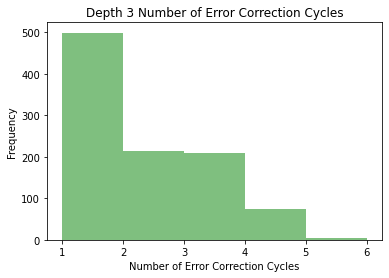

Mean: 1.875
Standard Deviation: 1.021457292303501


In [14]:
num_bins_3 = 5
plt.hist(d3_dist, num_bins_3, color='g', alpha=.5)
plt.gca().set(title='Depth 3 Number of Error Correction Cycles', xlabel = "Number of Error Correction Cycles", ylabel='Frequency')
plt.show()
mean_d3 = sum(d3_dist) / len(d3_dist)
sd_d3 = statistics.pstdev(d3_dist) 
print('Mean: ' + str(mean_d3))
print('Standard Deviation: ' + str(sd_d3))

In [36]:
d3_dist_baseline = [2, 2, 4, 3, 2, 4, 3, 3, 4, 2, 4, 3, 4, 4, 3, 3, 3, 4, 4, 4, 3, 2, 2, 3, 1, 3, 3, 3, 4, 3, 4, 3, 1, 3, 2, 1, 2, 4, 4, 3, 2, 3, 2, 3, 2, 2, 4, 2, 3, 3, 3, 4, 3, 2, 3, 3, 3, 2, 2, 4, 3, 4, 3, 4, 3, 2, 4, 4, 3, 1, 2, 3, 4, 3, 4, 2, 2, 2, 2, 2, 3, 4, 3, 4, 3, 3, 4, 3, 3, 4, 2, 4, 2, 3, 3, 3, 3, 2, 3, 2, 4, 1, 3, 1, 3, 4, 2, 2, 4, 3, 3, 3, 2, 2, 4, 3, 4, 3, 3, 4, 2, 3, 5, 3, 3, 3, 3, 3, 2, 4, 3, 3, 3, 4, 2, 3, 3, 4, 3, 3, 3, 3, 4, 2, 4, 4, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 1, 2, 2, 2, 2, 4, 3, 3, 3, 3, 2, 4, 3, 4, 1, 3, 3, 2, 2, 2, 2, 3, 2, 4, 4, 3, 3, 2, 4, 2, 2, 3, 4, 2, 4, 3, 2, 2, 2, 4, 2, 3, 2, 4, 3, 3, 4, 5, 2, 3, 3, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 2, 4, 3, 3, 3, 3, 4, 2, 3, 3, 4, 3, 2, 2, 4, 3, 3, 3, 3, 4, 3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 4, 4, 3, 2, 2, 4, 3, 3, 3, 4, 2, 2, 3, 1, 3, 4, 2, 3, 3, 3, 2, 3, 3, 4, 3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 4, 2, 3, 2, 2, 3, 3, 3, 3, 4, 3, 3, 1, 2, 4, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 4, 3, 3, 3, 4, 3, 2, 2, 3, 4, 4, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 2, 4, 3, 3, 2, 3, 2, 4, 3, 3, 4, 3, 3, 3, 3, 2, 2, 2, 3, 2, 4, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 2, 1, 2, 3, 4, 3, 2, 4, 3, 3, 4, 3, 4, 3, 2, 4, 3, 2, 3, 3, 2, 1, 3, 2, 3, 2, 3, 4, 3, 3, 3, 4, 2, 4, 3, 4, 2, 3, 2, 3, 2, 4, 3, 3, 4, 3, 3, 2, 2, 3, 4, 3, 3, 3, 2, 4, 4, 3, 4, 3, 3, 4, 3, 4, 2, 3, 4, 3, 4, 3, 3, 2, 2, 1, 3, 3, 3, 2, 3, 1, 2, 2, 3, 3, 3, 3, 4, 4, 3, 2, 3, 3, 3, 4, 3, 4, 4, 3, 3, 3, 2, 3, 4, 4, 4, 4, 4, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 4, 1, 2, 3, 4, 3, 2, 3, 3, 2, 3, 4, 4, 4, 3, 3, 2, 3, 4, 4, 2, 3, 2, 3, 3, 3, 3, 2, 4, 3, 3, 2, 3, 3, 3, 4, 4, 3, 2, 3, 1, 3, 3, 3, 2, 4, 2, 3, 3, 1, 2, 2, 3, 2, 2, 4, 3, 2, 3, 4, 2, 3, 3, 3, 4, 4, 3, 2, 4, 3, 3, 3, 4, 2, 2, 3, 2, 4, 4, 4, 3, 3, 4, 3, 2, 3, 3, 4, 3, 3, 2, 3, 4, 4, 3, 3, 1, 4, 3, 5, 4, 4, 3, 2, 4, 2, 1, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 2, 3, 4, 4, 3, 3, 3, 2, 2, 2, 4, 1, 4, 3, 3, 3, 2, 1, 3, 4, 2, 4, 3, 2, 3, 4, 3, 2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 3, 2, 3, 4, 3, 2, 2, 4, 3, 1, 3, 4, 2, 2, 4, 4, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 2, 3, 4, 2, 3, 3, 3, 2, 3, 2, 4, 4, 3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 4, 3, 4, 4, 3, 2, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 4, 4, 3, 3, 3, 2, 3, 2, 2, 4, 3, 4, 2, 1, 2, 3, 3, 4, 4, 2, 4, 4, 3, 1, 4, 3, 4, 4, 3, 3, 4, 3, 2, 3, 3, 1, 3, 3, 2, 2, 3, 3, 3, 1, 3, 2, 2, 2, 2, 2, 5, 3, 4, 4, 3, 3, 3, 4, 4, 4, 3, 2, 2, 2, 4, 3, 2, 3, 3, 4, 4, 3, 3, 3, 3, 3, 2, 4, 4, 3, 3, 3, 3, 4, 3, 3, 2, 3, 3, 4, 4, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 4, 3, 2, 3, 4, 3, 3, 4, 2, 3, 2, 4, 3, 3, 2, 3, 4, 2, 3, 2, 3, 3, 4, 3, 2, 2, 3, 3, 3, 4, 2, 2, 2, 4, 3, 2, 3, 4, 2, 2, 1, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 4, 3, 2, 4, 2, 3, 3, 2, 4, 3, 4, 3, 1, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 4, 2, 4, 1, 2, 3, 3, 2, 3, 2, 4, 2, 3, 2, 3, 3, 3, 2, 3, 2, 3, 4, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2, 4, 2, 2, 3, 3, 4, 2, 4, 4, 4, 3, 2, 3, 3, 3, 4, 3, 1, 3, 2, 2, 3, 3, 2]
d3_dist_exhaust = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
d3_dist_v2_1k = [1, 2, 1, 3, 4, 2, 1, 3, 3, 2, 1, 3, 1, 4, 1, 1, 3, 1, 2, 4, 2, 2, 2, 2, 2, 1, 3, 2, 1, 1, 2, 2, 3, 2, 4, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 3, 1, 2, 2, 1, 1, 4, 1, 4, 2, 2, 5, 2, 3, 1, 1, 3, 2, 1, 1, 1, 2, 2, 3, 1, 3, 2, 1, 3, 2, 2, 3, 4, 5, 2, 1, 2, 3, 4, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 5, 1, 3, 2, 2, 1, 1, 3, 1, 2, 2, 2, 2, 1, 3, 1, 2, 1, 1, 2, 3, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 3, 1, 1, 2, 2, 3, 4, 3, 3, 1, 3, 3, 2, 2, 1, 5, 4, 2, 3, 1, 4, 2, 2, 1, 1, 2, 2, 1, 3, 4, 1, 2, 4, 2, 3, 2, 4, 1, 4, 1, 2, 3, 1, 1, 4, 1, 2, 1, 2, 2, 3, 2, 1, 3, 2, 1, 1, 3, 2, 3, 2, 4, 3, 3, 2, 4, 2, 3, 4, 1, 1, 1, 1, 2, 3, 1, 3, 2, 1, 2, 4, 1, 1, 3, 3, 1, 1, 1, 3, 1, 2, 1, 2, 3, 3, 1, 2, 1, 2, 2, 3, 1, 2, 2, 1, 3, 2, 3, 1, 3, 1, 2, 2, 1, 1, 2, 4, 4, 3, 3, 1, 1, 2, 1, 3, 2, 3, 2, 1, 3, 2, 1, 2, 2, 1, 2, 2, 1, 3, 3, 1, 2, 1, 2, 4, 3, 1, 1, 1, 1, 1, 2, 1, 1, 4, 1, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 3, 4, 4, 2, 1, 2, 1, 2, 1, 4, 2, 2, 3, 1, 2, 2, 2, 3, 2, 3, 1, 1, 3, 1, 1, 2, 2, 7, 3, 3, 3, 1, 3, 1, 3, 3, 1, 4, 2, 2, 1, 2, 2, 3, 2, 1, 1, 4, 3, 2, 1, 3, 2, 1, 1, 2, 1, 3, 1, 1, 3, 3, 2, 2, 3, 2, 3, 1, 4, 2, 1, 3, 2, 1, 2, 2, 2, 1, 2, 1, 3, 2, 1, 1, 2, 1, 1, 2, 1, 3, 2, 2, 3, 2, 3, 1, 4, 3, 2, 1, 4, 1, 1, 2, 1, 2, 2, 2, 2, 2, 4, 2, 1, 3, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 3, 2, 2, 4, 2, 2, 3, 1, 1, 3, 2, 2, 1, 3, 1, 2, 2, 3, 4, 2, 2, 1, 2, 5, 1, 3, 3, 3, 1, 1, 4, 1, 2, 3, 2, 1, 3, 1, 1, 3, 1, 2, 2, 4, 1, 1, 3, 7, 1, 4, 2, 2, 3, 2, 1, 3, 5, 2, 2, 2, 5, 3, 3, 2, 2, 3, 1, 2, 3, 1, 1, 3, 1, 2, 2, 3, 1, 1, 3, 1, 3, 3, 2, 1, 4, 1, 3, 3, 2, 1, 3, 3, 3, 3, 2, 1, 2, 1, 2, 2, 3, 4, 3, 1, 1, 3, 2, 3, 4, 2, 2, 2, 2, 3, 3, 4, 2, 2, 2, 1, 2, 2, 1, 1, 4, 2, 2, 1, 3, 1, 1, 1, 3, 1, 1, 2, 1, 3, 2, 4, 2, 3, 2, 3, 3, 2, 3, 1, 1, 1, 2, 2, 2, 2, 1, 4, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 4, 1, 2, 2, 3, 2, 2, 1, 1, 3, 2, 4, 2, 1, 2, 1, 4, 4, 3, 3, 3, 2, 1, 2, 2, 2, 4, 2, 2, 4, 2, 1, 1, 2, 2, 4, 1, 3, 3, 3, 2, 1, 3, 2, 4, 1, 2, 2, 1, 1, 2, 3, 1, 2, 2, 2, 2, 3, 2, 1, 3, 3, 1, 4, 2, 2, 2, 3, 1, 1, 3, 3, 1, 3, 1, 2, 1, 2, 3, 2, 2, 3, 3, 3, 2, 1, 2, 2, 2, 4, 1, 1, 3, 2, 1, 2, 3, 1, 1, 1, 4, 1, 3, 1, 1, 1, 5, 2, 3, 3, 2, 1, 2, 2, 3, 1, 3, 2, 1, 2, 3, 1, 2, 4, 2, 3, 2, 3, 3, 1, 1, 3, 3, 6, 1, 3, 2, 3, 3, 3, 3, 1, 2, 6, 2, 1, 2, 3, 1, 3, 1, 2, 3, 2, 2, 2, 1, 3, 1, 1, 3, 1, 3, 2, 2, 3, 4, 2, 4, 2, 2, 1, 3, 2, 2, 1, 2, 1, 1, 3, 2, 2, 1, 1, 2, 1, 3, 2, 3, 3, 2, 3, 1, 2, 3, 2, 2, 2, 1, 2, 2, 5, 2, 3, 1, 1, 3, 2, 1, 3, 3, 1, 3, 1, 2, 1, 2, 1, 1, 3, 2, 1, 2, 1, 1, 3, 1, 2, 4, 3, 1, 4, 2, 2, 4, 1, 3, 1, 1, 2, 3, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 4, 3, 3, 3, 1, 3, 2, 2, 3, 2, 3, 2, 1, 5, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 3, 2, 1, 2, 1, 2, 2, 1, 2, 1, 3, 1, 1, 2, 2, 2, 1, 4, 2, 1, 3, 3, 3, 4, 1, 3, 1, 1, 3, 2, 2, 2, 1, 3, 1, 1, 3, 2, 1, 3, 2, 3, 3, 3, 1, 2, 2, 2, 1, 2, 2, 2, 1, 3, 1, 2, 2, 3, 1, 3, 2, 1, 2, 2, 2, 2, 1, 2, 2, 3, 2, 3, 4, 4, 1, 2, 1, 3, 2, 1, 2, 2, 4, 3, 3, 1, 1, 3, 1, 2, 1, 1, 2, 1, 4, 2, 2]
d3_dist_v2_10k = [2, 3, 3, 2, 3, 3, 3, 4, 2, 1, 2, 4, 4, 3, 3, 4, 4, 2, 1, 3, 3, 2, 3, 2, 2, 4, 4, 3, 3, 2, 4, 4, 3, 4, 2, 6, 3, 2, 1, 2, 3, 2, 2, 3, 6, 3, 2, 3, 2, 5, 4, 3, 2, 2, 3, 2, 3, 4, 3, 2, 4, 2, 3, 7, 2, 2, 3, 6, 2, 2, 3, 5, 4, 2, 2, 3, 1, 2, 1, 3, 1, 4, 4, 3, 3, 4, 2, 5, 4, 3, 4, 3, 3, 4, 2, 2, 3, 2, 3, 1, 4, 5, 1, 2, 2, 3, 2, 4, 5, 2, 2, 2, 2, 3, 2, 2, 7, 4, 2, 2, 3, 5, 1, 4, 3, 3, 4, 5, 2, 4, 3, 1, 4, 3, 2, 2, 3, 3, 5, 3, 3, 4, 3, 4, 2, 4, 2, 2, 2, 6, 4, 2, 1, 3, 6, 4, 2, 3, 6, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 1, 4, 2, 3, 3, 2, 3, 2, 2, 4, 3, 4, 3, 3, 2, 3, 2, 2, 2, 4, 3, 2, 3, 3, 3, 3, 5, 4, 4, 3, 2, 6, 3, 5, 4, 4, 2, 3, 3, 4, 3, 2, 1, 5, 2, 3, 6, 2, 2, 3, 1, 2, 2, 3, 3, 4, 4, 2, 3, 2, 2, 3, 2, 4, 3, 2, 2, 2, 2, 4, 2, 4, 3, 2, 2, 2, 3, 3, 2, 3, 2, 3, 4, 5, 5, 1, 2, 3, 2, 3, 4, 4, 2, 1, 2, 2, 4, 2, 2, 3, 2, 3, 2, 5, 2, 4, 3, 2, 2, 4, 4, 2, 1, 4, 1, 3, 3, 4, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 4, 2, 3, 3, 5, 2, 2, 2, 4, 3, 2, 2, 4, 4, 3, 2, 3, 2, 2, 5, 2, 4, 4, 2, 2, 3, 5, 2, 3, 2, 1, 2, 3, 2, 5, 3, 3, 2, 2, 2, 1, 3, 3, 3, 5, 4, 3, 4, 3, 4, 2, 2, 4, 2, 4, 2, 2, 4, 4, 3, 3, 4, 3, 2, 3, 3, 4, 3, 4, 3, 2, 5, 3, 4, 1, 3, 1, 2, 3, 2, 2, 4, 4, 3, 6, 2, 3, 3, 3, 3, 4, 4, 2, 2, 3, 2, 2, 3, 2, 2, 6, 4, 3, 2, 4, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 2, 4, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 1, 4, 2, 2, 3, 2, 3, 3, 2, 4, 4, 2, 2, 3, 2, 3, 3, 3, 6, 4, 3, 2, 4, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 4, 2, 2, 2, 2, 4, 3, 2, 2, 4, 3, 2, 2, 2, 3, 2, 5, 2, 2, 4, 2, 3, 6, 4, 6, 4, 3, 2, 3, 2, 2, 2, 2, 2, 2, 5, 5, 3, 2, 4, 3, 2, 3, 2, 2, 3, 4, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 5, 2, 2, 2, 3, 2, 3, 3, 2, 3, 6, 2, 4, 3, 3, 2, 4, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 3, 2, 5, 3, 4, 3, 2, 5, 4, 4, 2, 2, 5, 4, 4, 2, 4, 3, 2, 5, 4, 3, 3, 5, 2, 2, 2, 4, 1, 3, 6, 3, 1, 4, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 4, 2, 3, 3, 4, 3, 2, 4, 3, 4, 2, 3, 4, 4, 3, 2, 3, 2, 2, 3, 2, 2, 5, 1, 2, 3, 2, 2, 2, 3, 5, 3, 2, 4, 5, 4, 2, 2, 6, 3, 2, 2, 5, 2, 4, 4, 5, 2, 3, 3, 3, 4, 2, 3, 3, 5, 3, 2, 4, 4, 4, 3, 4, 3, 2, 4, 2, 3, 2, 2, 4, 2, 3, 2, 2, 3, 4, 3, 3, 2, 2, 2, 3, 2, 4, 4, 3, 2, 4, 3, 1, 3, 3, 7, 2, 4, 3, 3, 2, 2, 3, 1, 3, 7, 2, 2, 4, 4, 3, 5, 5, 4, 3, 4, 2, 4, 3, 2, 5, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 4, 3, 2, 3, 3, 2, 2, 4, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 4, 3, 2, 5, 5, 3, 3, 2, 2, 3, 3, 3, 2, 2, 5, 3, 3, 3, 3, 2, 4, 4, 4, 3, 4, 2, 1, 3, 3, 4, 2, 3, 4, 3, 4, 3, 3, 4, 2, 3, 2, 2, 3, 3, 2, 3, 3, 2, 4, 2, 2, 3, 3, 4, 5, 2, 3, 4, 3, 2, 3, 3, 3, 3, 5, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 4, 3, 2, 3, 3, 2, 2, 3, 5, 2, 2, 5, 3, 2, 4, 3, 3, 3, 3, 4, 2, 2, 2, 3, 3, 6, 4, 3, 2, 2, 3, 4, 3, 2, 2, 2, 2, 2, 2, 4, 3, 4, 4, 2, 2, 5, 2, 3, 2, 3, 3, 2, 2, 3, 1, 4, 4, 2, 2, 1, 4, 2, 2, 3, 3, 2, 2, 2, 4, 3, 4, 2, 3, 2, 3, 4, 2, 3, 2, 3, 2, 5, 2, 3, 2, 3, 2, 2, 2, 5, 4, 2, 3, 4, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 1, 5, 2, 3, 2, 1, 2, 3, 2, 5, 2, 2, 3, 3, 3, 7, 5, 2, 2, 3, 4, 2, 4, 2, 3, 2, 4, 5, 4, 2, 3, 2, 3, 3]
d3_dist_v2_100k = [2, 3, 1, 3, 2, 1, 3, 4, 3, 1, 5, 2, 3, 5, 3, 2, 2, 3, 2, 4, 2, 2, 2, 2, 4, 1, 6, 1, 2, 2, 2, 3, 2, 3, 4, 5, 1, 2, 1, 2, 4, 1, 5, 2, 1, 5, 3, 4, 2, 2, 3, 3, 1, 3, 3, 1, 5, 2, 7, 5, 2, 3, 4, 4, 1, 4, 3, 3, 1, 3, 2, 3, 5, 2, 4, 7, 3, 4, 3, 3, 4, 3, 5, 2, 3, 5, 4, 2, 4, 2, 5, 3, 3, 1, 2, 2, 2, 5, 5, 2, 7, 3, 4, 3, 3, 3, 3, 2, 4, 2, 3, 4, 3, 2, 2, 3, 1, 2, 4, 4, 2, 2, 4, 5, 3, 4, 4, 3, 2, 2, 2, 5, 3, 3, 2, 3, 2, 3, 3, 2, 2, 5, 2, 1, 2, 2, 5, 3, 5, 1, 5, 1, 2, 5, 3, 3, 2, 2, 2, 3, 2, 3, 3, 2, 2, 4, 2, 2, 2, 3, 4, 1, 3, 2, 2, 3, 2, 2, 2, 3, 6, 1, 3, 5, 2, 4, 2, 2, 1, 3, 3, 1, 3, 1, 2, 1, 3, 3, 3, 4, 2, 2, 3, 2, 2, 1, 3, 3, 2, 3, 3, 1, 3, 4, 1, 3, 2, 4, 4, 2, 1, 4, 3, 4, 1, 3, 3, 2, 5, 2, 1, 1, 2, 3, 6, 5, 2, 2, 1, 4, 2, 7, 1, 5, 2, 4, 3, 2, 3, 2, 2, 3, 2, 2, 4, 3, 3, 5, 1, 1, 1, 2, 2, 2, 2, 3, 3, 1, 2, 4, 3, 2, 2, 3, 4, 2, 3, 3, 1, 2, 4, 2, 2, 5, 2, 2, 3, 1, 5, 3, 2, 1, 3, 4, 2, 3, 2, 3, 3, 1, 3, 2, 2, 2, 3, 6, 1, 1, 1, 4, 3, 2, 1, 2, 1, 2, 2, 2, 1, 4, 3, 3, 1, 1, 2, 5, 1, 3, 1, 4, 2, 2, 2, 3, 4, 6, 2, 3, 1, 2, 2, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 4, 5, 3, 2, 2, 2, 2, 2, 2, 2, 1, 4, 1, 5, 2, 1, 3, 2, 5, 2, 3, 2, 4, 1, 2, 2, 4, 2, 2, 3, 2, 2, 2, 3, 4, 2, 2, 2, 2, 1, 2, 3, 2, 5, 3, 3, 2, 5, 3, 5, 2, 2, 2, 3, 3, 6, 2, 1, 2, 1, 1, 2, 3, 3, 4, 2, 1, 3, 3, 1, 3, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 4, 5, 2, 3, 2, 2, 3, 5, 2, 1, 3, 3, 3, 2, 2, 2, 3, 2, 1, 3, 2, 2, 3, 3, 2, 2, 3, 4, 6, 3, 3, 2, 2, 3, 3, 2, 1, 2, 6, 2, 4, 2, 2, 2, 2, 6, 2, 1, 3, 2, 4, 6, 2, 3, 2, 3, 1, 1, 2, 4, 2, 3, 1, 3, 2, 3, 3, 4, 3, 4, 3, 3, 2, 3, 1, 5, 2, 1, 2, 3, 2, 3, 1, 2, 2, 2, 3, 6, 2, 3, 3, 3, 4, 1, 1, 2, 2, 3, 2, 3, 2, 1, 2, 4, 3, 3, 1, 2, 4, 2, 3, 2, 1, 1, 2, 3, 3, 2, 1, 1, 1, 3, 5, 5, 3, 2, 5, 2, 5, 3, 3, 6, 4, 5, 2, 4, 2, 2, 6, 4, 2, 4, 4, 5, 6, 2, 3, 2, 2, 4, 2, 1, 5, 3, 3, 2, 2, 3, 3, 3, 1, 6, 3, 4, 3, 5, 1, 3, 3, 3, 1, 4, 3, 2, 5, 4, 2, 2, 3, 3, 2, 8, 3, 4, 1, 2, 2, 2, 3, 3, 1, 3, 3, 5, 2, 4, 3, 2, 3, 1, 2, 3, 3, 4, 2, 3, 2, 1, 3, 2, 3, 2, 2, 2, 5, 4, 2, 6, 3, 2, 2, 2, 4, 4, 3, 4, 2, 4, 3, 3, 1, 2, 3, 2, 2, 2, 3, 5, 5, 2, 3, 5, 3, 5, 2, 2, 5, 2, 3, 2, 1, 1, 4, 3, 4, 2, 2, 2, 5, 3, 3, 2, 2, 3, 5, 3, 2, 2, 2, 3, 4, 3, 2, 2, 2, 2, 5, 5, 3, 2, 1, 3, 3, 2, 3, 2, 4, 1, 3, 3, 2, 3, 1, 2, 4, 4, 4, 5, 5, 1, 3, 3, 2, 2, 2, 5, 1, 3, 4, 2, 2, 5, 3, 3, 3, 3, 3, 2, 4, 3, 4, 5, 2, 4, 5, 2, 4, 1, 2, 4, 5, 2, 1, 1, 6, 4, 2, 1, 4, 4, 3, 3, 5, 3, 2, 3, 3, 1, 1, 4, 1, 3, 3, 3, 4, 4, 2, 2, 3, 2, 1, 5, 4, 3, 4, 4, 5, 1, 4, 2, 5, 1, 4, 7, 3, 3, 3, 4, 5, 2, 2, 2, 3, 4, 2, 1, 1, 2, 3, 4, 3, 2, 4, 3, 1, 6, 3, 2, 2, 2, 1, 2, 2, 5, 4, 3, 3, 5, 3, 4, 3, 5, 2, 2, 4, 1, 2, 3, 4, 2, 3, 4, 3, 3, 3, 5, 3, 1, 6, 3, 2, 5, 6, 2, 3, 4, 4, 2, 3, 2, 3, 4, 5, 3, 1, 4, 4, 5, 4, 1, 4, 2, 2, 2, 4, 2, 1, 3, 3, 1, 4, 1, 3, 2, 1, 3, 5, 3, 1, 3, 4, 5, 2, 6, 2, 4, 3, 4, 2, 2, 7, 3, 1, 5, 1, 2, 5, 2, 2, 3, 5, 3, 2, 3, 2, 2, 1, 3, 2, 3, 3, 5, 2, 3, 4, 2, 3, 4, 6, 1, 1, 1, 5, 3, 4, 2, 2, 3, 2, 3, 4, 1, 4, 2, 5, 7, 2, 3, 3, 2, 3, 2, 2, 2, 3, 2, 3, 3, 4, 5, 3, 2, 2, 6, 4, 1, 3, 3, 4, 4, 3, 2, 4, 3, 2, 2, 2, 4, 2, 3, 6, 3, 2, 1, 1, 3, 1]
d3_dist_v3_1k = [2, 2, 2, 2, 3, 3, 1, 2, 2, 3, 3, 3, 2, 2, 3, 1, 2, 2, 3, 3, 1, 3, 3, 3, 3, 8, 3, 3, 3, 4, 2, 2, 3, 3, 1, 2, 2, 4, 3, 3, 4, 2, 3, 1, 3, 2, 2, 2, 1, 4, 2, 3, 1, 1, 1, 2, 3, 1, 1, 2, 3, 2, 1, 2, 2, 2, 3, 1, 3, 2, 3, 4, 2, 3, 2, 3, 3, 2, 3, 3, 3, 4, 2, 3, 3, 3, 3, 2, 2, 4, 2, 3, 3, 2, 4, 2, 3, 1, 4, 1, 2, 2, 2, 1, 2, 3, 3, 4, 3, 3, 4, 3, 2, 3, 3, 3, 2, 3, 2, 2, 2, 4, 1, 2, 2, 3, 5, 2, 1, 2, 3, 4, 1, 3, 2, 1, 3, 4, 2, 3, 1, 3, 3, 3, 2, 2, 4, 3, 3, 3, 2, 3, 3, 2, 4, 2, 1, 4, 2, 2, 2, 1, 2, 3, 3, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 3, 4, 3, 6, 2, 1, 3, 3, 2, 3, 2, 4, 2, 1, 2, 3, 2, 3, 2, 5, 3, 2, 2, 1, 3, 2, 2, 4, 3, 1, 4, 2, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 1, 2, 3, 4, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 1, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 1, 2, 4, 2, 3, 1, 3, 4, 1, 2, 3, 3, 2, 3, 1, 1, 3, 3, 1, 2, 4, 2, 2, 3, 1, 5, 1, 4, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3, 1, 4, 2, 2, 2, 2, 2, 2, 3, 4, 1, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2, 4, 2, 4, 4, 1, 2, 2, 3, 3, 2, 1, 1, 4, 3, 3, 2, 1, 3, 1, 2, 5, 3, 2, 2, 2, 2, 2, 3, 3, 4, 3, 1, 3, 3, 4, 2, 2, 3, 1, 3, 4, 3, 3, 1, 2, 4, 2, 2, 2, 2, 3, 3, 2, 4, 2, 2, 3, 1, 3, 3, 2, 4, 2, 2, 3, 3, 3, 3, 2, 5, 3, 1, 3, 2, 2, 4, 2, 3, 3, 2, 1, 4, 3, 2, 3, 1, 3, 1, 2, 2, 1, 4, 1, 2, 2, 4, 4, 3, 1, 1, 2, 2, 3, 3, 4, 3, 1, 2, 3, 3, 5, 3, 2, 2, 2, 4, 2, 3, 4, 5, 3, 4, 3, 1, 2, 3, 2, 2, 3, 2, 2, 2, 1, 1, 3, 4, 1, 3, 2, 2, 3, 3, 2, 1, 2, 3, 3, 2, 2, 1, 3, 3, 3, 2, 3, 3, 2, 3, 4, 2, 1, 2, 5, 3, 2, 2, 3, 2, 2, 2, 3, 3, 4, 1, 3, 2, 2, 2, 1, 3, 4, 2, 1, 3, 1, 2, 5, 2, 3, 2, 3, 3, 2, 1, 3, 3, 1, 2, 2, 2, 3, 1, 3, 2, 3, 3, 2, 2, 1, 3, 2, 2, 3, 2, 5, 1, 4, 4, 2, 3, 2, 2, 1, 4, 2, 2, 2, 3, 2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 6, 3, 2, 2, 1, 4, 4, 4, 3, 1, 2, 3, 2, 2, 2, 3, 3, 1, 2, 2, 4, 3, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 3, 4, 2, 2, 3, 4, 2, 3, 3, 4, 3, 4, 3, 3, 2, 4, 3, 1, 2, 2, 2, 4, 3, 3, 3, 1, 3, 2, 2, 2, 3, 5, 3, 3, 1, 2, 1, 3, 3, 4, 2, 2, 2, 1, 2, 2, 2, 3, 2, 3, 4, 2, 3, 2, 2, 3, 3, 4, 4, 3, 3, 2, 3, 2, 3, 1, 2, 1, 2, 2, 3, 3, 5, 3, 2, 2, 2, 2, 2, 1, 3, 2, 2, 1, 3, 4, 3, 1, 5, 2, 3, 2, 2, 3, 2, 2, 1, 4, 3, 2, 4, 2, 3, 4, 1, 4, 3, 2, 2, 2, 2, 3, 6, 3, 4, 3, 1, 3, 4, 4, 4, 2, 2, 4, 5, 3, 3, 2, 3, 5, 4, 3, 3, 2, 2, 3, 1, 4, 3, 4, 4, 3, 2, 2, 2, 3, 2, 4, 4, 3, 1, 2, 2, 3, 3, 2, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 2, 1, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3, 4, 2, 3, 3, 3, 3, 4, 4, 3, 1, 2, 2, 2, 1, 2, 3, 3, 4, 2, 2, 2, 3, 2, 3, 4, 3, 2, 2, 1, 1, 2, 4, 2, 1, 1, 1, 3, 3, 1, 2, 2, 2, 3, 1, 4, 2, 1, 2, 3, 2, 3, 1, 2, 1, 3, 4, 3, 1, 1, 2, 4, 1, 2, 1, 2, 3, 2, 2, 1, 2, 2, 2, 3, 3, 1, 3, 4, 2, 3, 2, 2, 2, 2, 1, 3, 1, 4, 1, 3, 3, 2, 3, 2, 4, 2, 2, 3, 3, 2, 4, 2, 4, 2, 2, 4, 2, 1, 1, 1, 1, 2, 3, 3, 4, 5, 3, 6, 2, 3, 5, 5, 1, 2, 2, 1, 1, 1, 2, 3, 2, 2, 4, 3, 2, 2, 3, 5, 2, 2, 1, 1, 3, 2, 2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 3, 2, 1, 3, 3, 5, 3, 3, 2, 2, 3, 1, 3, 2, 4, 2, 3, 3, 2, 4, 2, 2, 2, 3, 1, 2, 3, 4, 1, 2, 1, 2, 3, 2, 3, 1, 3, 5, 3, 2, 3, 3, 4, 2, 2, 4, 2, 1, 4, 2, 2, 3, 4, 2, 3, 1, 1, 2, 2, 3, 4, 1, 2, 2, 1, 5, 2, 3, 4, 2, 4, 3]
d3_dist_v3_10k = [3, 1, 2, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 2, 4, 3, 1, 4, 3, 4, 1, 1, 3, 3, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 3, 1, 1, 3, 3, 1, 1, 4, 1, 3, 1, 1, 1, 1, 1, 3, 2, 3, 1, 1, 4, 2, 1, 1, 1, 3, 2, 1, 3, 3, 1, 2, 4, 1, 2, 1, 4, 2, 1, 1, 2, 1, 3, 2, 2, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 2, 1, 3, 3, 1, 4, 1, 1, 1, 1, 2, 2, 3, 1, 1, 2, 2, 1, 1, 2, 3, 2, 3, 2, 2, 3, 3, 4, 3, 2, 1, 2, 1, 2, 2, 1, 3, 4, 1, 2, 2, 1, 3, 1, 1, 2, 3, 2, 4, 1, 5, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 2, 1, 2, 1, 3, 3, 1, 2, 1, 2, 1, 1, 3, 2, 3, 1, 1, 1, 2, 3, 1, 1, 2, 4, 2, 1, 1, 2, 1, 1, 3, 3, 3, 2, 2, 3, 2, 1, 2, 3, 1, 1, 2, 1, 1, 2, 2, 2, 3, 1, 2, 3, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 3, 2, 3, 2, 1, 2, 4, 1, 1, 4, 1, 1, 2, 2, 1, 1, 1, 3, 1, 1, 2, 3, 1, 1, 4, 1, 1, 3, 1, 1, 3, 3, 5, 2, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 2, 1, 1, 2, 3, 3, 1, 1, 1, 4, 1, 1, 1, 2, 3, 3, 3, 5, 2, 1, 1, 3, 1, 2, 3, 2, 4, 1, 4, 2, 4, 1, 2, 2, 3, 4, 1, 2, 1, 3, 2, 1, 1, 2, 1, 1, 3, 3, 3, 1, 3, 1, 3, 2, 1, 1, 3, 3, 1, 1, 3, 1, 2, 1, 2, 1, 1, 1, 3, 2, 2, 1, 3, 2, 1, 3, 1, 3, 2, 1, 1, 2, 3, 1, 1, 4, 2, 1, 1, 1, 2, 1, 3, 2, 3, 3, 3, 2, 1, 4, 1, 4, 1, 1, 1, 2, 2, 3, 2, 1, 1, 2, 1, 1, 2, 4, 2, 1, 4, 1, 3, 1, 1, 1, 4, 1, 1, 2, 1, 3, 1, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 2, 3, 1, 2, 3, 4, 1, 2, 1, 2, 1, 2, 1, 4, 1, 3, 3, 1, 1, 3, 1, 5, 3, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 3, 4, 4, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 4, 2, 1, 1, 2, 3, 1, 1, 4, 3, 1, 1, 3, 3, 4, 2, 3, 1, 1, 1, 2, 3, 2, 1, 1, 1, 1, 1, 1, 4, 1, 3, 3, 1, 1, 4, 2, 1, 2, 1, 1, 2, 3, 3, 1, 2, 3, 3, 1, 2, 1, 3, 1, 2, 1, 1, 1, 1, 1, 5, 4, 1, 3, 1, 1, 2, 4, 2, 1, 1, 3, 2, 1, 1, 1, 4, 1, 2, 2, 1, 3, 1, 3, 1, 1, 4, 2, 1, 1, 1, 3, 1, 1, 3, 3, 4, 1, 4, 1, 1, 2, 1, 2, 3, 3, 2, 3, 2, 3, 2, 3, 1, 3, 2, 1, 1, 1, 1, 1, 1, 3, 4, 1, 1, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 2, 2, 1, 1, 3, 2, 2, 1, 1, 2, 3, 2, 5, 3, 3, 4, 2, 2, 1, 1, 3, 1, 3, 3, 1, 2, 3, 2, 3, 3, 4, 2, 3, 1, 4, 3, 1, 1, 1, 3, 3, 1, 3, 2, 2, 1, 3, 1, 4, 2, 2, 2, 2, 1, 1, 1, 2, 3, 1, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 2, 1, 3, 1, 4, 3, 1, 3, 1, 3, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 4, 2, 1, 1, 3, 3, 1, 2, 4, 1, 3, 3, 1, 3, 1, 1, 1, 2, 1, 3, 1, 2, 1, 2, 2, 1, 4, 1, 2, 4, 1, 1, 1, 1, 2, 1, 3, 1, 1, 2, 1, 2, 2, 1, 1, 3, 3, 2, 3, 1, 1, 1, 2, 1, 4, 1, 1, 2, 1, 3, 3, 4, 3, 1, 1, 2, 1, 4, 2, 3, 4, 2, 1, 1, 2, 2, 3, 3, 3, 2, 3, 1, 2, 3, 3, 2, 1, 3, 3, 2, 1, 3, 4, 2, 3, 2, 2, 1, 2, 2, 1, 3, 1, 4, 1, 3, 3, 3, 3, 1, 3, 3, 4, 1, 1, 1, 1, 1, 1, 2, 2, 4, 1, 1, 3, 2, 1, 1, 3, 1, 3, 1, 1, 3, 2, 3, 1, 1, 2, 1, 2, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 3, 1, 1, 1, 2, 3, 1, 1, 3, 3, 1, 1, 1, 2, 3, 1, 1, 3, 2, 2, 4, 1, 3, 1, 3, 1, 3, 1, 2, 1, 1, 3, 4, 1, 1, 4, 3, 3, 4, 1, 3, 2, 2, 3, 3, 1, 3, 1, 3, 2, 3, 2, 4, 1, 4, 2, 2, 2, 1, 2, 2, 1, 3, 3, 3, 3, 1, 2, 1, 3, 3, 3, 4, 3, 1, 1, 1, 1, 1, 1, 4, 2, 1, 3, 3, 5, 3, 1, 2, 1, 4, 3, 3, 1, 3, 1, 1, 5, 2, 3, 1, 4, 1]

#stats.kruskal(d3_dist_baseline, d3_dist_exhaust)
#stats.kruskal(d3_dist_baseline, d3_dist_v2_1k)
#stats.kruskal(d3_dist_baseline, d3_dist_v2_10k)
#stats.kruskal(d3_dist_baseline, d3_dist_v2_100k)
#stats.kruskal(d3_dist_baseline, d3_dist_v3_1k)
stats.kruskal(d3_dist_baseline, d3_dist_v3_10k)


KruskalResult(statistic=423.02190976557085, pvalue=5.366577593417521e-94)

# Depth 5

In [15]:
circuit = ToricCircuit(5)
d5_dist = []
mlb = MultiLabelBinarizer()
mlb.fit([['', 'X00', 'X01', 'X02', 'X03', 'X04', 'X10', 'X11', 'X12', 'X13', 'X14', 'X20',
 'X21', 'X22', 'X23', 'X24', 'X30', 'X31', 'X32', 'X33', 'X34', 'X40', 'X41', 'X42',
 'X43', 'X44', 'Z00', 'Z01', 'Z02', 'Z03', 'Z04', 'Z10', 'Z11', 'Z12', 'Z13', 'Z14',
 'Z20', 'Z21', 'Z22', 'Z23', 'Z24', 'Z30', 'Z31', 'Z32', 'Z33', 'Z34', 'Z40', 'Z41',
 'Z42', 'Z43', 'Z44']])
model = keras.models.load_model('MODELS/model_d5_v3-10k.h5')
for i in range(1000):
    count = 0
    while circuit.check_max_errs(5):
        circuit.add_random_error(1)
        syn = circuit.get_syndrome(0)
        del syn['Labels']
        vals = list(syn.values())
        vals = np.array(vals)
        #vals = np.where(vals == -1, 0, vals)
        vals = np.expand_dims(vals, axis=0)

        errors = circuit.get_physical_errs()
        errors = errors.get('Labels')
        print(errors)
        multilabelerrs = mlb.transform([errors])
        #print(multilabelerrs[0])
        print(vals.shape)

        prediction = model.predict(vals)
        prediction[prediction>=.5]=1
        prediction[prediction<.5]=0
        correction =mlb.inverse_transform(prediction)
        print(correction)
        circuit.correct_errs(correction)
        count += 1
    circuit.clear_errors()
    d5_dist.append(count)
    
print(d5_dist)

['Z32']
(1, 24)
[('Z32',)]
Corrected qubit Z32
['X24', 'Z24']
(1, 24)
[('Z24',)]
Corrected qubit Z24
['X24', 'X24', 'Z24']
(1, 24)
[('Z24',)]
Corrected qubit Z24
['X24', 'X24', 'X31', 'Z31']
(1, 24)
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X24', 'X24', 'X33']
(1, 24)
[('X33',)]
Corrected qubit X33
['X24', 'X24', 'X43', 'Z43']
(1, 24)
[('X42', 'X43')]
Incorrectly flipped qubit X42
Corrected qubit X43
['X24', 'X24', 'X42', 'X32', 'Z43']
(1, 24)
[('X21', 'X41', 'X42')]
Incorrectly flipped qubit X21
Incorrectly flipped qubit X41
Corrected qubit X42
['X11']
(1, 24)
[('X11',)]
Corrected qubit X11
['X01']
(1, 24)
[('X01',)]
Corrected qubit X01
['X14', 'Z14']
(1, 24)
[('X04', 'Z14')]
Incorrectly flipped qubit X04
Corrected qubit Z14
['X14', 'X04', 'X32', 'Z32']
(1, 24)
[('X32', 'Z23', 'Z32')]
Corrected qubit X32
Incorrectly flipped qubit Z23
Corrected qubit Z32
['X14', 'X04', 'X33', 'Z23']
(1, 24)
[('X33', 'Z23')]
Corrected qubit X33
Corrected qubit Z23
['X14', 'X04', 'Z30']


[('X43', 'Z14')]
Corrected qubit X43
Corrected qubit Z14
['X20', 'X20', 'X32']
(1, 24)
[('X32',)]
Corrected qubit X32
['X20', 'X20', 'Z21']
(1, 24)
[('Z21',)]
Corrected qubit Z21
['X20', 'X20', 'X40', 'Z40']
(1, 24)
[('X30', 'X31', 'Z30', 'Z40')]
Incorrectly flipped qubit X30
Incorrectly flipped qubit X31
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X01']
(1, 24)
[('X01',)]
Corrected qubit X01
['X04']
(1, 24)
[('X04',)]
Corrected qubit X04
['X01', 'Z01']
(1, 24)
[('X01',)]
Corrected qubit X01
['Z01', 'Z44']
(1, 24)
[('Z10', 'Z34')]
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z34
['X31', 'Z01', 'Z44', 'Z10', 'Z34']
(1, 24)
[('X31', 'Z10', 'Z34')]
Corrected qubit X31
Corrected qubit Z10
Corrected qubit Z34
['Z01', 'Z44', 'Z02']
(1, 24)
[('Z02', 'Z03', 'Z10', 'Z13', 'Z34')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z13
Incorrectly flipped qubit Z34
['Z11']
(1, 24)
[('Z11',)]
Corrected qubit Z11
['Z13']
(1, 

[('X20',)]
Incorrectly flipped qubit X20
['X10', 'X20', 'X20']
(1, 24)
[('X20',)]
Corrected qubit X20
['X10', 'X20', 'Z14']
(1, 24)
[('Z14',)]
Corrected qubit Z14
['X10', 'X20', 'Z23']
(1, 24)
[('Z23',)]
Corrected qubit Z23
['X10', 'X20', 'Z10']
(1, 24)
[('Z04', 'Z10')]
Incorrectly flipped qubit Z04
Corrected qubit Z10
['X10', 'X20', 'Z04', 'Z42']
(1, 24)
[('Z04', 'Z14', 'Z32', 'Z42')]
Corrected qubit Z04
Incorrectly flipped qubit Z14
Incorrectly flipped qubit Z32
Corrected qubit Z42
['X10', 'X20', 'Z14', 'Z32', 'Z12']
(1, 24)
[('Z04', 'Z14', 'Z22', 'Z32')]
Incorrectly flipped qubit Z04
Corrected qubit Z14
Incorrectly flipped qubit Z22
Corrected qubit Z32
['X10', 'X20', 'Z12', 'Z04', 'Z22', 'Z33']
(1, 24)
[('Z03', 'Z04', 'Z14', 'Z34')]
Incorrectly flipped qubit Z03
Corrected qubit Z04
Incorrectly flipped qubit Z14
Incorrectly flipped qubit Z34
['X02']
(1, 24)
[('X02',)]
Corrected qubit X02
['X44']
(1, 24)
[('X43', 'X44')]
Incorrectly flipped qubit X43
Corrected qubit X44
['X43', 'X22',

[('Z11',)]
Corrected qubit Z11
['X04', 'Z43']
(1, 24)
[('X03', 'Z34')]
Incorrectly flipped qubit X03
Incorrectly flipped qubit Z34
['X04', 'X03', 'Z43', 'Z34', 'Z00']
(1, 24)
[('X02', 'X03', 'Z10', 'Z34')]
Incorrectly flipped qubit X02
Corrected qubit X03
Incorrectly flipped qubit Z10
Corrected qubit Z34
['X04', 'X02', 'Z43', 'Z00', 'Z10', 'Z21']
(1, 24)
[('X02', 'Z12', 'Z20')]
Corrected qubit X02
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
['X22']
(1, 24)
[('X22',)]
Corrected qubit X22
['Z01']
(1, 24)
[()]
['Z01', 'Z14']
(1, 24)
[('Z14',)]
Corrected qubit Z14
['X34', 'Z01']
(1, 24)
[('X23',)]
Incorrectly flipped qubit X23
['X34', 'X23', 'X24', 'Z01', 'Z24']
(1, 24)
[('X23', 'Z24')]
Corrected qubit X23
Corrected qubit Z24
['X34', 'X24', 'X10', 'Z01', 'Z10']
(1, 24)
[('X11', 'Z10', 'Z20')]
Incorrectly flipped qubit X11
Corrected qubit Z10
Incorrectly flipped qubit Z20
['X34']
(1, 24)
[('X24', 'X34')]
Incorrectly flipped qubit X24
Corrected qubit X34
['X24', 'X14']
(1, 24

[('Z42',)]
Corrected qubit Z42
['X22', 'Z02', 'Z12', 'Z22']
(1, 24)
[('X22', 'Z23')]
Corrected qubit X22
Incorrectly flipped qubit Z23
['X40', 'Z02', 'Z12', 'Z22', 'Z23']
(1, 24)
[('X31', 'X40')]
Incorrectly flipped qubit X31
Corrected qubit X40
['X31', 'X02', 'Z02', 'Z12', 'Z22', 'Z23', 'Z02']
(1, 24)
[('X02', 'X21', 'X22', 'X31', 'Z13')]
Corrected qubit X02
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Corrected qubit X31
Incorrectly flipped qubit Z13
['Z14']
(1, 24)
[('Z14',)]
Corrected qubit Z14
['X23']
(1, 24)
[('X23',)]
Corrected qubit X23
['Z23']
(1, 24)
[('Z23',)]
Corrected qubit Z23
['X02']
(1, 24)
[('X02',)]
Corrected qubit X02
['X34', 'Z34']
(1, 24)
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X21']
(1, 24)
[('X21',)]
Corrected qubit X21
['Z34']
(1, 24)
[('Z34',)]
Corrected qubit Z34
['X32']
(1, 24)
[('X32',)]
Corrected qubit X32
['Z03']
(1, 24)
[('Z03', 'Z12')]
Corrected qubit Z03
Incorrectly flipped qubit Z12
['Z12', 'Z00']
(1, 24)
[('Z12',)]
Co

[('Z02', 'Z04', 'Z32')]
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z04
Incorrectly flipped qubit Z32
['Z32']
(1, 24)
[('Z32',)]
Corrected qubit Z32
['X14', 'Z14']
(1, 24)
[('X04', 'Z14')]
Incorrectly flipped qubit X04
Corrected qubit Z14
['X14', 'X04', 'Z42']
(1, 24)
[('Z42',)]
Corrected qubit Z42
['X14', 'X04', 'X32', 'Z32']
(1, 24)
[('X32', 'Z23', 'Z32')]
Corrected qubit X32
Incorrectly flipped qubit Z23
Corrected qubit Z32
['X14', 'X04', 'X00', 'Z23', 'Z00']
(1, 24)
[('X00', 'X01', 'Z23')]
Corrected qubit X00
Incorrectly flipped qubit X01
Corrected qubit Z23
['X14', 'X04', 'X01', 'Z00', 'Z10']
(1, 24)
[('X01', 'Z10')]
Corrected qubit X01
Corrected qubit Z10
['X14', 'X04', 'X24', 'Z00']
(1, 24)
[('X23',)]
Incorrectly flipped qubit X23
['X14', 'X04', 'X24', 'X23', 'X00', 'Z00']
(1, 24)
[('X00', 'X01')]
Corrected qubit X00
Incorrectly flipped qubit X01
['X10']
(1, 24)
[('X20',)]
Incorrectly flipped qubit X20
['X10', 'X20', 'X24', 'Z24']
(1, 24)
[('Z24',)]
Corrected qubit Z

(1, 24)
[('X11',)]
Corrected qubit X11
['Z31']
(1, 24)
[('Z31',)]
Corrected qubit Z31
['X44', 'Z44']
(1, 24)
[('X44',)]
Corrected qubit X44
['Z44', 'Z10']
(1, 24)
[('Z10',)]
Corrected qubit Z10
['X34', 'Z44', 'Z34']
(1, 24)
[('X23', 'X24', 'X34', 'Z34')]
Incorrectly flipped qubit X23
Incorrectly flipped qubit X24
Corrected qubit X34
Corrected qubit Z34
['X23', 'X24', 'X10', 'Z44', 'Z10']
(1, 24)
[('X11', 'Z10', 'Z34')]
Incorrectly flipped qubit X11
Corrected qubit Z10
Incorrectly flipped qubit Z34
['X24']
(1, 24)
[('X24', 'X34')]
Corrected qubit X24
Incorrectly flipped qubit X34
['X34', 'Z10']
(1, 24)
[('X33', 'Z10')]
Incorrectly flipped qubit X33
Corrected qubit Z10
['X34', 'X33', 'X12']
(1, 24)
[('X12', 'X22', 'X32', 'X42')]
Corrected qubit X12
Incorrectly flipped qubit X22
Incorrectly flipped qubit X32
Incorrectly flipped qubit X42
['X34', 'X33', 'X22', 'X32', 'X42', 'X00', 'Z00']
(1, 24)
[('X01', 'X12', 'X42', 'Z00')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit X12
Corr

[('X32', 'Z23')]
Corrected qubit X32
Corrected qubit Z23
['X44', 'Z43', 'Z42', 'Z33', 'Z32', 'Z44']
(1, 24)
[('X44',)]
Corrected qubit X44
['X21', 'Z43', 'Z42', 'Z33', 'Z32', 'Z44']
(1, 24)
[('X21', 'Z34')]
Corrected qubit X21
Incorrectly flipped qubit Z34
['X44']
(1, 24)
[('X43', 'X44')]
Incorrectly flipped qubit X43
Corrected qubit X44
['X43', 'Z13']
(1, 24)
[('X43', 'Z13')]
Corrected qubit X43
Corrected qubit Z13
['X13']
(1, 24)
[('X13',)]
Corrected qubit X13
['X24', 'Z24']
(1, 24)
[('Z24',)]
Corrected qubit Z24
['X24', 'X32']
(1, 24)
[('X32',)]
Corrected qubit X32
['X24', 'X42']
(1, 24)
[('X42',)]
Corrected qubit X42
['X24', 'Z44']
(1, 24)
[('X24', 'X34', 'Z34')]
Corrected qubit X24
Incorrectly flipped qubit X34
Incorrectly flipped qubit Z34
['X34', 'X31', 'Z44', 'Z34', 'Z31']
(1, 24)
[('X31', 'Z24', 'Z30', 'Z31', 'Z34')]
Corrected qubit X31
Incorrectly flipped qubit Z24
Incorrectly flipped qubit Z30
Corrected qubit Z31
Corrected qubit Z34
['X34', 'Z44', 'Z24', 'Z30', 'Z44']
(1, 24

[('Z32',)]
Corrected qubit Z32
['X14', 'X04', 'X30']
(1, 24)
[('X31', 'X40')]
Incorrectly flipped qubit X31
Incorrectly flipped qubit X40
['X14', 'X04', 'X30', 'X31', 'X40', 'X03']
(1, 24)
[('X03', 'X31')]
Corrected qubit X03
Corrected qubit X31
['X14', 'X04', 'X30', 'X40', 'Z13']
(1, 24)
[('Z13',)]
Corrected qubit Z13
['X14', 'X04', 'X30', 'X40', 'X32', 'Z32']
(1, 24)
[('X32', 'Z23', 'Z32')]
Corrected qubit X32
Incorrectly flipped qubit Z23
Corrected qubit Z32
['X14', 'X04', 'X30', 'X40', 'X04', 'Z23']
(1, 24)
[('X04', 'Z23')]
Corrected qubit X04
Corrected qubit Z23
['X14', 'X30', 'X40', 'X04', 'Z42']
(1, 24)
[('Z42',)]
Corrected qubit Z42
['X14', 'X30', 'X40', 'X04', 'X33', 'Z33']
(1, 24)
[('X33', 'Z23', 'Z33', 'Z34')]
Corrected qubit X33
Incorrectly flipped qubit Z23
Corrected qubit Z33
Incorrectly flipped qubit Z34
['X22', 'Z22']
(1, 24)
[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['X13', 'Z13']
(1, 24)
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['Z03']
(

[('X24', 'X34', 'Z34')]
Incorrectly flipped qubit X24
Corrected qubit X34
Corrected qubit Z34
['X24', 'X41', 'Z43', 'Z34']
(1, 24)
[('X23', 'X33', 'X41', 'Z34')]
Incorrectly flipped qubit X23
Incorrectly flipped qubit X33
Corrected qubit X41
Corrected qubit Z34
['X24', 'X23', 'X33', 'X43', 'Z43']
(1, 24)
[('X23', 'X44')]
Corrected qubit X23
Incorrectly flipped qubit X44
['X24', 'X33', 'X43', 'X44', 'X22', 'Z43']
(1, 24)
[('X22', 'Z34')]
Corrected qubit X22
Incorrectly flipped qubit Z34
['X30', 'Z30']
(1, 24)
[('X40', 'Z30')]
Incorrectly flipped qubit X40
Corrected qubit Z30
['X30', 'X40', 'Z13']
(1, 24)
[('Z13',)]
Corrected qubit Z13
['X30', 'X40', 'X14', 'Z14']
(1, 24)
[('X04', 'Z14')]
Incorrectly flipped qubit X04
Corrected qubit Z14
['X30', 'X40', 'X14', 'X04', 'X03', 'Z03']
(1, 24)
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X30', 'X40', 'X14', 'X04', 'X02']
(1, 24)
[('X02',)]
Corrected qubit X02
['X30', 'X40', 'X14', 'X04', 'X20']
(1, 24)
[('X20',)]
Corrected qubit 

[('X01', 'Z32')]
Incorrectly flipped qubit X01
Corrected qubit Z32
['X12', 'X22', 'X32', 'X01', 'Z42']
(1, 24)
[('X00', 'X01', 'X42', 'Z32', 'Z42')]
Incorrectly flipped qubit X00
Corrected qubit X01
Incorrectly flipped qubit X42
Incorrectly flipped qubit Z32
Corrected qubit Z42
['X13', 'Z13']
(1, 24)
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X13']
(1, 24)
[('X13',)]
Corrected qubit X13
['Z34']
(1, 24)
[('Z34',)]
Corrected qubit Z34
['X34']
(1, 24)
[('X24', 'X34')]
Incorrectly flipped qubit X24
Corrected qubit X34
['X24', 'X23']
(1, 24)
[()]
['X24', 'X23', 'X14', 'Z14']
(1, 24)
[('X13', 'Z14')]
Incorrectly flipped qubit X13
Corrected qubit Z14
['X24', 'X23', 'X14', 'X13', 'Z14']
(1, 24)
[('Z14',)]
Corrected qubit Z14
['X24', 'X23', 'X14', 'X13', 'Z31']
(1, 24)
[('Z31',)]
Corrected qubit Z31
['X24', 'X23', 'X14', 'X13', 'X24', 'Z24']
(1, 24)
[('Z24',)]
Corrected qubit Z24
['X24', 'X23', 'X14', 'X13', 'X24', 'Z22']
(1, 24)
[('Z22', 'Z23')]
Corrected qubit Z22
Incorrectly 

[('X11', 'Z10')]
Incorrectly flipped qubit X11
Corrected qubit Z10
['X23', 'X34', 'X10', 'X11', 'X10']
(1, 24)
[('X10',)]
Corrected qubit X10
['X23', 'X34', 'X11', 'X10', 'X01']
(1, 24)
[('X00', 'X01')]
Incorrectly flipped qubit X00
Corrected qubit X01
['X23', 'X34', 'X11', 'X10', 'X00', 'X30', 'Z30']
(1, 24)
[('X01', 'Z30')]
Incorrectly flipped qubit X01
Corrected qubit Z30
['Z04']
(1, 24)
[('Z04', 'Z14')]
Corrected qubit Z04
Incorrectly flipped qubit Z14
['Z14', 'Z30']
(1, 24)
[('Z14', 'Z30')]
Corrected qubit Z14
Corrected qubit Z30
['Z11']
(1, 24)
[('Z11',)]
Corrected qubit Z11
['X43', 'Z43']
(1, 24)
[('X42', 'X43')]
Incorrectly flipped qubit X42
Corrected qubit X43
['X42', 'X42', 'Z43', 'Z42']
(1, 24)
[()]
['X42', 'X42', 'X14', 'Z43', 'Z42', 'Z14']
(1, 24)
[('X03', 'X04', 'Z04', 'Z14', 'Z32')]
Incorrectly flipped qubit X03
Incorrectly flipped qubit X04
Incorrectly flipped qubit Z04
Corrected qubit Z14
Incorrectly flipped qubit Z32
['Z30']
(1, 24)
[('Z30',)]
Corrected qubit Z30
['X1

[('Z12',)]
Corrected qubit Z12
['X10', 'X10', 'X31', 'Z31']
(1, 24)
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X10', 'X10', 'Z41']
(1, 24)
[('Z42',)]
Incorrectly flipped qubit Z42
['X10', 'X10', 'X22', 'Z41', 'Z42']
(1, 24)
[('X22',)]
Corrected qubit X22
['X10', 'X10', 'X32', 'Z41', 'Z42', 'Z32']
(1, 24)
[('X32', 'Z23', 'Z32')]
Corrected qubit X32
Incorrectly flipped qubit Z23
Corrected qubit Z32
['X10', 'X10', 'Z41', 'Z42', 'Z23', 'Z34']
(1, 24)
[('Z23', 'Z34')]
Corrected qubit Z23
Corrected qubit Z34
['X10', 'X10', 'Z41', 'Z42', 'Z33']
(1, 24)
[('Z33',)]
Corrected qubit Z33
['X10', 'X10', 'X24', 'Z41', 'Z42', 'Z24']
(1, 24)
[('Z24',)]
Corrected qubit Z24
['X10', 'X10', 'X24', 'X14', 'Z41', 'Z42', 'Z14']
(1, 24)
[('Z14',)]
Corrected qubit Z14
['X24', 'Z24']
(1, 24)
[('Z24',)]
Corrected qubit Z24
['X24', 'X32']
(1, 24)
[('X32',)]
Corrected qubit X32
['X24', 'X11']
(1, 24)
[('X34',)]
Incorrectly flipped qubit X34
['X24', 'X11', 'X34', 'X44']
(1, 24)
[('X01', 'X10', 'X11'

[('X12', 'X22', 'Z22')]
Corrected qubit X12
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z22
['X22', 'X14', 'Z02', 'Z12', 'Z22']
(1, 24)
[('X13', 'X22', 'Z23')]
Incorrectly flipped qubit X13
Corrected qubit X22
Incorrectly flipped qubit Z23
['X43', 'Z43']
(1, 24)
[('X42', 'X43')]
Incorrectly flipped qubit X42
Corrected qubit X43
['X42', 'X41', 'Z43']
(1, 24)
[('X30', 'X40', 'X42', 'Z34')]
Incorrectly flipped qubit X30
Incorrectly flipped qubit X40
Corrected qubit X42
Incorrectly flipped qubit Z34
['X41', 'X30', 'X40', 'X13', 'Z43', 'Z34']
(1, 24)
[('X13', 'X41', 'Z34')]
Corrected qubit X13
Corrected qubit X41
Corrected qubit Z34
['X30', 'X40', 'X21', 'Z43', 'Z21']
(1, 24)
[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['X30', 'X40', 'X20', 'Z43', 'Z20']
(1, 24)
[('X10', 'X20', 'Z20', 'Z34')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit Z20
Incorrectly flipped qubit Z34
['X30', 'X40', 'X10', 'X41', 'Z43', 'Z34']
(1, 24)
[('X41', 'X42', 'Z34')]
C

[('X21', 'X22', 'X31', 'Z13')]
Incorrectly flipped qubit X21
Corrected qubit X22
Incorrectly flipped qubit X31
Corrected qubit Z13
['X12', 'X21', 'X31', 'Z42']
(1, 24)
[()]
['X12', 'X21', 'X31', 'Z42', 'Z03']
(1, 24)
[('X11', 'Z13', 'Z41', 'Z42')]
Incorrectly flipped qubit X11
Incorrectly flipped qubit Z13
Incorrectly flipped qubit Z41
Corrected qubit Z42
['X04', 'Z04']
(1, 24)
[('X04', 'Z04', 'Z14')]
Corrected qubit X04
Corrected qubit Z04
Incorrectly flipped qubit Z14
['X24', 'Z14']
(1, 24)
[('X23', 'Z14')]
Incorrectly flipped qubit X23
Corrected qubit Z14
['X24', 'X23', 'X24', 'Z24']
(1, 24)
[('X12', 'X23', 'Z24')]
Incorrectly flipped qubit X12
Corrected qubit X23
Corrected qubit Z24
['X24', 'X24', 'X12', 'Z32']
(1, 24)
[('X12', 'Z32')]
Corrected qubit X12
Corrected qubit Z32
['X24', 'X24', 'X14', 'Z14']
(1, 24)
[('X04', 'Z14')]
Incorrectly flipped qubit X04
Corrected qubit Z14
['X24', 'X24', 'X14', 'X04', 'X12']
(1, 24)
[()]
['X24', 'X24', 'X14', 'X04', 'X12', 'Z41']
(1, 24)
[('Z42

[('Z31',)]
Corrected qubit Z31
['X33']
(1, 24)
[('X33',)]
Corrected qubit X33
['X02', 'Z02']
(1, 24)
[('X02', 'Z12')]
Corrected qubit X02
Incorrectly flipped qubit Z12
['X00', 'Z02', 'Z12']
(1, 24)
[('X00', 'X01', 'Z11')]
Corrected qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit Z11
['X01', 'Z02', 'Z12', 'Z11', 'Z32']
(1, 24)
[('X01', 'Z00', 'Z32')]
Corrected qubit X01
Incorrectly flipped qubit Z00
Corrected qubit Z32
['X31', 'Z02', 'Z12', 'Z11', 'Z00']
(1, 24)
[('X31',)]
Corrected qubit X31
['X43', 'Z02', 'Z12', 'Z11', 'Z00', 'Z43']
(1, 24)
[('X42', 'X43')]
Incorrectly flipped qubit X42
Corrected qubit X43
['Z21']
(1, 24)
[('Z21',)]
Corrected qubit Z21
['X42']
(1, 24)
[('X42',)]
Corrected qubit X42
['X44']
(1, 24)
[('X43', 'X44')]
Incorrectly flipped qubit X43
Corrected qubit X44
['X43', 'Z13']
(1, 24)
[('X43', 'Z13')]
Corrected qubit X43
Corrected qubit Z13
['Z31']
(1, 24)
[('Z31',)]
Corrected qubit Z31
['X22']
(1, 24)
[('X22',)]
Corrected qubit X22
['X14', 'Z14']
(

[('X34', 'Z10', 'Z34')]
Corrected qubit X34
Incorrectly flipped qubit Z10
Corrected qubit Z34
['X01', 'Z01', 'Z10', 'Z01']
(1, 24)
[('X01', 'Z10')]
Corrected qubit X01
Corrected qubit Z10
['X34', 'Z01', 'Z01']
(1, 24)
[('X24', 'X34')]
Incorrectly flipped qubit X24
Corrected qubit X34
['X24', 'X03', 'Z01', 'Z01', 'Z03']
(1, 24)
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X24', 'X21', 'Z01', 'Z01', 'Z21']
(1, 24)
[('X21', 'X23', 'X34', 'Z21')]
Corrected qubit X21
Incorrectly flipped qubit X23
Incorrectly flipped qubit X34
Corrected qubit Z21
['X24', 'X23', 'X34', 'X33', 'Z01', 'Z01']
(1, 24)
[('X42',)]
Incorrectly flipped qubit X42
['X40', 'Z40']
(1, 24)
[('X30', 'X31', 'Z30', 'Z40')]
Incorrectly flipped qubit X30
Incorrectly flipped qubit X31
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X40', 'X30', 'X31', 'Z30', 'Z41']
(1, 24)
[('X31', 'Z30', 'Z31')]
Corrected qubit X31
Corrected qubit Z30
Incorrectly flipped qubit Z31
['X40', 'X30', 'Z41', 'Z31', 'Z32']
(1, 24)
[

[('X23',)]
Corrected qubit X23
['X42', 'Z00', 'Z01', 'Z42']
(1, 24)
[('X42', 'Z42', 'Z43')]
Corrected qubit X42
Corrected qubit Z42
Incorrectly flipped qubit Z43
['Z00', 'Z01', 'Z43', 'Z03']
(1, 24)
[('Z02', 'Z03', 'Z12', 'Z13', 'Z34')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z13
Incorrectly flipped qubit Z34
['Z24']
(1, 24)
[('Z24',)]
Corrected qubit Z24
['Z44']
(1, 24)
[('Z34',)]
Incorrectly flipped qubit Z34
['Z44', 'Z34', 'Z11']
(1, 24)
[('Z11', 'Z24')]
Corrected qubit Z11
Incorrectly flipped qubit Z24
['X11', 'Z44', 'Z34', 'Z24']
(1, 24)
[('X11',)]
Corrected qubit X11
['Z44', 'Z34', 'Z24', 'Z13']
(1, 24)
[('Z03', 'Z12')]
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['X30']
(1, 24)
[('X31', 'X40')]
Incorrectly flipped qubit X31
Incorrectly flipped qubit X40
['X30', 'X31', 'X40', 'X33', 'Z33']
(1, 24)
[('X31', 'X33', 'Z23', 'Z33', 'Z34')]
Corrected qubit X31
Corrected qubit X33
Incorrectly flipped qubit

[('X02', 'X03', 'Z03', 'Z12')]
Incorrectly flipped qubit X02
Corrected qubit X03
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['X14', 'X02', 'Z02', 'Z03', 'Z12', 'Z43']
(1, 24)
[('X02', 'X03', 'Z12')]
Corrected qubit X02
Incorrectly flipped qubit X03
Corrected qubit Z12
['X14', 'X03', 'X42', 'Z02', 'Z03', 'Z43', 'Z42']
(1, 24)
[('X02', 'X03', 'X42')]
Incorrectly flipped qubit X02
Corrected qubit X03
Corrected qubit X42
['X44', 'Z44']
(1, 24)
[('X44',)]
Corrected qubit X44
['Z44', 'Z32']
(1, 24)
[('Z32',)]
Corrected qubit Z32
['X42', 'Z44']
(1, 24)
[('X42', 'Z34')]
Corrected qubit X42
Incorrectly flipped qubit Z34
['Z44', 'Z34', 'Z02']
(1, 24)
[('Z02', 'Z12', 'Z34')]
Corrected qubit Z02
Incorrectly flipped qubit Z12
Corrected qubit Z34
['X23', 'Z44', 'Z12', 'Z23']
(1, 24)
[('X23', 'Z22')]
Corrected qubit X23
Incorrectly flipped qubit Z22
['X03', 'Z44', 'Z12', 'Z23', 'Z22', 'Z03']
(1, 24)
[('X03', 'Z23', 'Z24')]
Corrected qubit X03
Corrected qubit Z23
Incorrectly flipped q

[('X02', 'X11', 'Z11')]
Incorrectly flipped qubit X02
Corrected qubit X11
Corrected qubit Z11
['X02', 'X40', 'Z40']
(1, 24)
[('X02', 'X30', 'X31', 'Z30', 'Z40')]
Corrected qubit X02
Incorrectly flipped qubit X30
Incorrectly flipped qubit X31
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X40', 'X30', 'X31', 'X23', 'Z30', 'Z23']
(1, 24)
[('X23', 'Z23', 'Z30')]
Corrected qubit X23
Corrected qubit Z23
Corrected qubit Z30
['X40', 'X30', 'X31', 'X13', 'Z13']
(1, 24)
[('X13', 'X31', 'Z13')]
Corrected qubit X13
Corrected qubit X31
Corrected qubit Z13
['X40', 'X30', 'X41', 'Z41']
(1, 24)
[('X41', 'Z42')]
Corrected qubit X41
Incorrectly flipped qubit Z42
['X40', 'X30', 'X31', 'Z41', 'Z42', 'Z31']
(1, 24)
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X40', 'X30', 'X24', 'Z41', 'Z42']
(1, 24)
[('X24', 'X34')]
Corrected qubit X24
Incorrectly flipped qubit X34
['X40', 'X30', 'X34', 'Z41', 'Z42', 'Z04']
(1, 24)
[('X23', 'Z04', 'Z14')]
Incorrectly flipped qubit X23
Corrected qubit Z

[('X02', 'Z12')]
Corrected qubit X02
Incorrectly flipped qubit Z12
['X03', 'Z02', 'Z12']
(1, 24)
[('X03',)]
Corrected qubit X03
['X30', 'Z02', 'Z12']
(1, 24)
[('Z12',)]
Corrected qubit Z12
['X30', 'X32', 'Z02']
(1, 24)
[('X32', 'Z02', 'Z12', 'Z13')]
Corrected qubit X32
Corrected qubit Z02
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z13
['X30', 'Z12', 'Z13', 'Z40']
(1, 24)
[('X00', 'X40', 'Z40')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X40
Corrected qubit Z40
['X30', 'X00', 'X40', 'X11', 'Z12', 'Z13', 'Z11']
(1, 24)
[('X01', 'X11', 'Z01')]
Incorrectly flipped qubit X01
Corrected qubit X11
Incorrectly flipped qubit Z01
['X31']
(1, 24)
[('X31',)]
Corrected qubit X31
['X04']
(1, 24)
[('X04',)]
Corrected qubit X04
['Z32']
(1, 24)
[('Z32',)]
Corrected qubit Z32
['X20', 'Z20']
(1, 24)
[('Z20',)]
Corrected qubit Z20
['X20', 'X32', 'Z32']
(1, 24)
[('X21', 'X32', 'Z23', 'Z32')]
Incorrectly flipped qubit X21
Corrected qubit X32
Incorrectly flipped qubit Z23
Corrected q

[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['X41']
(1, 24)
[('X41',)]
Corrected qubit X41
['X44']
(1, 24)
[('X43', 'X44')]
Incorrectly flipped qubit X43
Corrected qubit X44
['X43', 'X21', 'Z21']
(1, 24)
[('X21', 'X32', 'X43', 'Z20', 'Z21')]
Corrected qubit X21
Incorrectly flipped qubit X32
Corrected qubit X43
Incorrectly flipped qubit Z20
Corrected qubit Z21
['X32', 'X03', 'Z20']
(1, 24)
[('X03', 'X32', 'Z20')]
Corrected qubit X03
Corrected qubit X32
Corrected qubit Z20
['X14', 'Z14']
(1, 24)
[('X04', 'Z14')]
Incorrectly flipped qubit X04
Corrected qubit Z14
['X14', 'X04', 'Z24']
(1, 24)
[('Z24',)]
Corrected qubit Z24
['X14', 'X04', 'X24', 'Z24']
(1, 24)
[('Z24',)]
Corrected qubit Z24
['X14', 'X04', 'X24', 'X31', 'Z31']
(1, 24)
[('X31', 'X34', 'Z31')]
Corrected qubit X31
Incorrectly flipped qubit X34
Corrected qubit Z31
['X14', 'X04', 'X24', 'X34', 'Z21']
(1, 24)
[('Z21',)]
Corrected qubit Z21
['X14', 'X04', 'X24', 'X34', 'Z03']
(1, 24)
[('Z03', 'Z12')]
Corrected qubit Z0

[('Z22',)]
Corrected qubit Z22
['X14']
(1, 24)
[('X04',)]
Incorrectly flipped qubit X04
['X14', 'X04', 'X00', 'Z00']
(1, 24)
[('X00', 'X01')]
Corrected qubit X00
Incorrectly flipped qubit X01
['X14', 'X04', 'X01', 'X13', 'Z00']
(1, 24)
[('X01', 'X13', 'Z00')]
Corrected qubit X01
Corrected qubit X13
Corrected qubit Z00
['X14', 'X04', 'X42']
(1, 24)
[('X42',)]
Corrected qubit X42
['X14', 'X04', 'Z33']
(1, 24)
[('Z33',)]
Corrected qubit Z33
['X14', 'X04', 'X24']
(1, 24)
[('X24', 'X34')]
Corrected qubit X24
Incorrectly flipped qubit X34
['X14', 'X04', 'X34', 'Z14']
(1, 24)
[('X23', 'Z14')]
Incorrectly flipped qubit X23
Corrected qubit Z14
['X14', 'X04', 'X34', 'X23', 'Z13']
(1, 24)
[('Z13',)]
Corrected qubit Z13
['X14', 'X04', 'X34', 'X23', 'X00']
(1, 24)
[('X00', 'X01')]
Corrected qubit X00
Incorrectly flipped qubit X01
['X14', 'X04', 'X34', 'X23', 'X01', 'X42']
(1, 24)
[('X01', 'X22', 'X42')]
Corrected qubit X01
Incorrectly flipped qubit X22
Corrected qubit X42
['X14', 'X04', 'X34', 'X23

Corrected qubit Z30
['X30', 'X40', 'X04']
(1, 24)
[('X04',)]
Corrected qubit X04
['X30', 'X40', 'X20']
(1, 24)
[('X20',)]
Corrected qubit X20
['X30', 'X40', 'X32', 'Z32']
(1, 24)
[('X32', 'Z23', 'Z32')]
Corrected qubit X32
Incorrectly flipped qubit Z23
Corrected qubit Z32
['X30', 'X40', 'X30', 'Z23']
(1, 24)
[('X31', 'Z23')]
Incorrectly flipped qubit X31
Corrected qubit Z23
['X30', 'X40', 'X30', 'X31', 'X44', 'Z44']
(1, 24)
[('X31', 'X44')]
Corrected qubit X31
Corrected qubit X44
['X30', 'X40', 'X30', 'Z44', 'Z24']
(1, 24)
[('X30', 'Z34')]
Corrected qubit X30
Incorrectly flipped qubit Z34
['X40', 'X30', 'Z44', 'Z24', 'Z34', 'Z04']
(1, 24)
[('Z14',)]
Incorrectly flipped qubit Z14
['X44', 'Z44']
(1, 24)
[('X44',)]
Corrected qubit X44
['X00', 'Z44']
(1, 24)
[('X00', 'X01', 'Z34')]
Corrected qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit Z34
['X01', 'X10', 'Z44', 'Z34']
(1, 24)
[('X01', 'X10', 'X20', 'Z34')]
Corrected qubit X01
Corrected qubit X10
Incorrectly flipped qub

[('X21',)]
Corrected qubit X21
['X43', 'Z01', 'Z43']
(1, 24)
[('X42', 'X43', 'Z34')]
Incorrectly flipped qubit X42
Corrected qubit X43
Incorrectly flipped qubit Z34
['X42', 'Z01', 'Z43', 'Z34', 'Z20']
(1, 24)
[('X42', 'Z10', 'Z20', 'Z34')]
Corrected qubit X42
Incorrectly flipped qubit Z10
Corrected qubit Z20
Corrected qubit Z34
['Z01', 'Z43', 'Z10', 'Z03']
(1, 24)
[('Z02', 'Z10', 'Z12', 'Z13', 'Z20', 'Z34')]
Incorrectly flipped qubit Z02
Corrected qubit Z10
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z13
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z34
['X04', 'Z04']
(1, 24)
[('X04', 'Z04', 'Z14')]
Corrected qubit X04
Corrected qubit Z04
Incorrectly flipped qubit Z14
['X42', 'Z14', 'Z42']
(1, 24)
[('X42', 'Z14', 'Z32')]
Corrected qubit X42
Corrected qubit Z14
Incorrectly flipped qubit Z32
['Z42', 'Z32', 'Z21']
(1, 24)
[('Z04', 'Z21', 'Z23')]
Incorrectly flipped qubit Z04
Corrected qubit Z21
Incorrectly flipped qubit Z23
['X21', 'Z42', 'Z32', 'Z04', 'Z23']
(1, 24)

(1, 24)
[('X43', 'X44')]
Incorrectly flipped qubit X43
Corrected qubit X44
['X43', 'X20', 'Z44', 'Z44']
(1, 24)
[('X10', 'X20', 'X43', 'X44')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit X43
Incorrectly flipped qubit X44
['X10', 'X44', 'X44', 'Z44', 'Z44', 'Z44']
(1, 24)
[('X10', 'X20', 'Z34')]
Corrected qubit X10
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z34
['Z03']
(1, 24)
[('Z03', 'Z12')]
Corrected qubit Z03
Incorrectly flipped qubit Z12
['X13', 'Z12']
(1, 24)
[('X13', 'Z12')]
Corrected qubit X13
Corrected qubit Z12
['Z40']
(1, 24)
[('Z40',)]
Corrected qubit Z40
['X02', 'Z02']
(1, 24)
[('X02', 'Z12')]
Corrected qubit X02
Incorrectly flipped qubit Z12
['X02', 'Z02', 'Z12']
(1, 24)
[('X02', 'Z11')]
Corrected qubit X02
Incorrectly flipped qubit Z11
['X02', 'Z02', 'Z12', 'Z11', 'Z02']
(1, 24)
[('X02',)]
Corrected qubit X02
['X14', 'Z02', 'Z12', 'Z11', 'Z02', 'Z14']
(1, 24)
[('Z12', 'Z14')]
Corrected qubit Z12
Corrected qubit Z14
['X14', 'Z02', 'Z11', 

[('X42', 'X43', 'Z34')]
Incorrectly flipped qubit X42
Corrected qubit X43
Incorrectly flipped qubit Z34
['X44']
(1, 24)
[('X43', 'X44')]
Incorrectly flipped qubit X43
Corrected qubit X44
['X43', 'X21', 'Z21']
(1, 24)
[('X21', 'X32', 'X43', 'Z20', 'Z21')]
Corrected qubit X21
Incorrectly flipped qubit X32
Corrected qubit X43
Incorrectly flipped qubit Z20
Corrected qubit Z21
['X32', 'X01', 'Z20', 'Z01']
(1, 24)
[('X01', 'X32', 'X33', 'Z10', 'Z20')]
Corrected qubit X01
Corrected qubit X32
Incorrectly flipped qubit X33
Incorrectly flipped qubit Z10
Corrected qubit Z20
['X33', 'X32', 'Z01', 'Z10', 'Z32']
(1, 24)
[('Z10', 'Z20', 'Z23', 'Z32')]
Corrected qubit Z10
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z23
Corrected qubit Z32
['X33', 'X32', 'X03', 'Z01', 'Z20', 'Z23']
(1, 24)
[('X03', 'X24', 'X34', 'Z10', 'Z20', 'Z23')]
Corrected qubit X03
Incorrectly flipped qubit X24
Incorrectly flipped qubit X34
Incorrectly flipped qubit Z10
Corrected qubit Z20
Corrected qubit Z23
['X44', '

[()]
['X20', 'X10', 'X12', 'X44', 'Z44']
(1, 24)
[('X12', 'X44', 'Z34', 'Z43')]
Corrected qubit X12
Corrected qubit X44
Incorrectly flipped qubit Z34
Incorrectly flipped qubit Z43
['X20', 'X10', 'X11', 'Z44', 'Z34', 'Z43', 'Z11']
(1, 24)
[('X11', 'Z10', 'Z11', 'Z21', 'Z34')]
Corrected qubit X11
Incorrectly flipped qubit Z10
Corrected qubit Z11
Incorrectly flipped qubit Z21
Corrected qubit Z34
['Z12']
(1, 24)
[('Z12',)]
Corrected qubit Z12
['Z21']
(1, 24)
[('Z21',)]
Corrected qubit Z21
['X00']
(1, 24)
[('X00', 'X01')]
Corrected qubit X00
Incorrectly flipped qubit X01
['X01', 'Z30']
(1, 24)
[('X01', 'Z30')]
Corrected qubit X01
Corrected qubit Z30
['Z34']
(1, 24)
[('Z34',)]
Corrected qubit Z34
['Z24']
(1, 24)
[('Z24',)]
Corrected qubit Z24
['X23', 'Z23']
(1, 24)
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X43']
(1, 24)
[('X43',)]
Corrected qubit X43
['X01', 'Z01']
(1, 24)
[('X01',)]
Corrected qubit X01
['X02', 'Z01']
(1, 24)
[('X02', 'Z00')]
Corrected qubit X02
Incorrectly 

[('X31', 'Z34')]
Corrected qubit X31
Incorrectly flipped qubit Z34
['Z43', 'Z34', 'Z40']
(1, 24)
[('Z34', 'Z40')]
Corrected qubit Z34
Corrected qubit Z40
['Z43', 'Z12']
(1, 24)
[('Z12', 'Z34')]
Corrected qubit Z12
Incorrectly flipped qubit Z34
['Z43', 'Z34', 'Z10']
(1, 24)
[('Z10', 'Z24', 'Z34')]
Corrected qubit Z10
Incorrectly flipped qubit Z24
Corrected qubit Z34
['Z43', 'Z24', 'Z24']
(1, 24)
[('Z34',)]
Incorrectly flipped qubit Z34
['X33', 'Z43', 'Z24', 'Z24', 'Z34', 'Z33']
(1, 24)
[('X33', 'Z34')]
Corrected qubit X33
Corrected qubit Z34
['Z43', 'Z24', 'Z24', 'Z33', 'Z43']
(1, 24)
[('Z33',)]
Corrected qubit Z33
['X13', 'Z43', 'Z24', 'Z24', 'Z43']
(1, 24)
[('X13',)]
Corrected qubit X13
['Z43', 'Z24', 'Z24', 'Z43', 'Z10']
(1, 24)
[('Z04', 'Z10')]
Incorrectly flipped qubit Z04
Corrected qubit Z10
['X44', 'Z43', 'Z24', 'Z24', 'Z43', 'Z04']
(1, 24)
[('X43', 'X44', 'Z04', 'Z14')]
Incorrectly flipped qubit X43
Corrected qubit X44
Corrected qubit Z04
Incorrectly flipped qubit Z14
['Z31']
(1

[('X10', 'X20', 'Z34')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit Z34
['X10', 'Z44', 'Z34', 'Z34']
(1, 24)
[('X10', 'X20', 'Z34')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit Z34
['X20', 'X41', 'Z44', 'Z34', 'Z41']
(1, 24)
[('X21', 'X41', 'Z34', 'Z42')]
Incorrectly flipped qubit X21
Corrected qubit X41
Corrected qubit Z34
Incorrectly flipped qubit Z42
['X20', 'X21', 'X13', 'Z44', 'Z41', 'Z42', 'Z13']
(1, 24)
[('X03', 'X22', 'Z02', 'Z13')]
Incorrectly flipped qubit X03
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z02
Corrected qubit Z13
['X20', 'Z20']
(1, 24)
[('Z20',)]
Corrected qubit Z20
['X20', 'X41', 'Z41']
(1, 24)
[('X21', 'X41')]
Incorrectly flipped qubit X21
Corrected qubit X41
['X20', 'X21', 'X32', 'Z41', 'Z32']
(1, 24)
[('X33', 'Z23')]
Incorrectly flipped qubit X33
Incorrectly flipped qubit Z23
['X00', 'Z00']
(1, 24)
[('X00', 'X01')]
Corrected qubit X00
Incorrectly flipped qubit X01
['X01', 'X13', 'Z00', 'Z13']


['X34', 'X24', 'Z24']
(1, 24)
[('Z24',)]
Corrected qubit Z24
['X34', 'X24', 'X21', 'Z21']
(1, 24)
[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['X34', 'X24', 'X11']
(1, 24)
[('X11',)]
Corrected qubit X11
['X34', 'X24', 'X24']
(1, 24)
[('X24', 'X34')]
Corrected qubit X24
Corrected qubit X34
['X24', 'X03', 'Z03']
(1, 24)
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X24', 'X23']
(1, 24)
[()]
['X24', 'X23', 'Z34']
(1, 24)
[('X12', 'Z34')]
Incorrectly flipped qubit X12
Corrected qubit Z34
['X24', 'X23', 'X12', 'Z20']
(1, 24)
[('Z20',)]
Corrected qubit Z20
['X24', 'X23', 'X12', 'X31', 'Z31']
(1, 24)
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X24', 'X23', 'X12', 'Z04']
(1, 24)
[('Z04', 'Z14')]
Corrected qubit Z04
Incorrectly flipped qubit Z14
['X24', 'X23', 'X12', 'X03', 'Z14']
(1, 24)
[('X02', 'X03', 'Z14')]
Incorrectly flipped qubit X02
Corrected qubit X03
Corrected qubit Z14
['X24', 'X23', 'X12', 'X02', 'X01']
(1, 24)
[('X01', 'X02')]
Corrected qub

[('X10', 'X20', 'X42', 'X43')]
Corrected qubit X10
Incorrectly flipped qubit X20
Incorrectly flipped qubit X42
Corrected qubit X43
['X20', 'X42', 'Z43', 'Z04']
(1, 24)
[('X11', 'X42', 'Z14', 'Z34')]
Incorrectly flipped qubit X11
Corrected qubit X42
Incorrectly flipped qubit Z14
Incorrectly flipped qubit Z34
['X24', 'Z24']
(1, 24)
[('Z24',)]
Corrected qubit Z24
['X24', 'X41']
(1, 24)
[('X23', 'X41')]
Incorrectly flipped qubit X23
Corrected qubit X41
['X24', 'X23', 'X02']
(1, 24)
[('X02', 'X22')]
Corrected qubit X02
Incorrectly flipped qubit X22
['X24', 'X23', 'X22', 'X44', 'Z44']
(1, 24)
[('X31', 'X44')]
Incorrectly flipped qubit X31
Corrected qubit X44
['X24', 'X23', 'X22', 'X31', 'X10', 'Z44']
(1, 24)
[('X10', 'X30', 'Z34')]
Corrected qubit X10
Incorrectly flipped qubit X30
Incorrectly flipped qubit Z34
['Z12']
(1, 24)
[('Z12',)]
Corrected qubit Z12
['Z23']
(1, 24)
[('Z23',)]
Corrected qubit Z23
['Z40']
(1, 24)
[('Z40',)]
Corrected qubit Z40
['Z04']
(1, 24)
[('Z04', 'Z14')]
Corrected 

['X10', 'Z01', 'Z00', 'Z44', 'Z33', 'Z23', 'Z10']
(1, 24)
[('X11', 'X21', 'Z10', 'Z14')]
Incorrectly flipped qubit X11
Incorrectly flipped qubit X21
Corrected qubit Z10
Incorrectly flipped qubit Z14
['X11']
(1, 24)
[('X11',)]
Corrected qubit X11
['Z22']
(1, 24)
[('Z22',)]
Corrected qubit Z22
['Z21']
(1, 24)
[('Z21',)]
Corrected qubit Z21
['Z42']
(1, 24)
[('Z42',)]
Corrected qubit Z42
['Z02']
(1, 24)
[('Z03', 'Z12')]
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['Z02', 'Z03', 'Z12', 'Z44']
(1, 24)
[('Z12', 'Z34')]
Corrected qubit Z12
Incorrectly flipped qubit Z34
['Z02', 'Z03', 'Z44', 'Z34', 'Z21']
(1, 24)
[('Z21', 'Z24', 'Z34')]
Corrected qubit Z21
Incorrectly flipped qubit Z24
Corrected qubit Z34
['X43', 'Z02', 'Z03', 'Z44', 'Z24', 'Z43']
(1, 24)
[('X42', 'X43', 'Z24')]
Incorrectly flipped qubit X42
Corrected qubit X43
Corrected qubit Z24
['X42', 'X30', 'Z02', 'Z03', 'Z44', 'Z43', 'Z30']
(1, 24)
[('X41', 'X42', 'Z30')]
Incorrectly flipped qubit X41
Corrected qubit X42
C

[('X40', 'Z14')]
Incorrectly flipped qubit X40
Corrected qubit Z14
['X30', 'X40', 'X44', 'Z44']
(1, 24)
[('X44',)]
Corrected qubit X44
['X30', 'X40', 'X34', 'Z44']
(1, 24)
[('X24', 'X34', 'Z34')]
Incorrectly flipped qubit X24
Corrected qubit X34
Incorrectly flipped qubit Z34
['X30', 'X40', 'X24', 'X30', 'Z44', 'Z34', 'Z30']
(1, 24)
[('X34', 'X40', 'Z30', 'Z34')]
Incorrectly flipped qubit X34
Corrected qubit X40
Corrected qubit Z30
Corrected qubit Z34
['X30', 'X24', 'X30', 'X34', 'X01', 'Z44', 'Z01']
(1, 24)
[('X01', 'Z00', 'Z43')]
Corrected qubit X01
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z43
['X20']
(1, 24)
[('X20',)]
Corrected qubit X20
['X40', 'Z40']
(1, 24)
[('X30', 'X31', 'Z30', 'Z40')]
Incorrectly flipped qubit X30
Incorrectly flipped qubit X31
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X40', 'X30', 'X31', 'X00', 'Z30']
(1, 24)
[('X31', 'Z04', 'Z30')]
Corrected qubit X31
Incorrectly flipped qubit Z04
Corrected qubit Z30
['X40', 'X30', 'X00', 'X03', 'Z04'

[('X43',)]
Corrected qubit X43
['X21', 'Z41', 'Z42', 'Z14', 'Z14']
(1, 24)
[('X21',)]
Corrected qubit X21
['X31', 'Z41', 'Z42', 'Z14', 'Z14']
(1, 24)
[('X31',)]
Corrected qubit X31
['X21', 'Z41', 'Z42', 'Z14', 'Z14', 'Z21']
(1, 24)
[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['X02', 'Z41', 'Z42', 'Z14', 'Z14', 'Z02']
(1, 24)
[('X02', 'Z12')]
Corrected qubit X02
Incorrectly flipped qubit Z12
['X41']
(1, 24)
[('X41',)]
Corrected qubit X41
['X20', 'Z20']
(1, 24)
[('Z20',)]
Corrected qubit Z20
['X20', 'Z40']
(1, 24)
[('X10', 'X20', 'Z40')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit Z40
['X10', 'Z02']
(1, 24)
[('X10', 'X20', 'Z03', 'Z12')]
Corrected qubit X10
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['X20', 'X34', 'Z02', 'Z03', 'Z12']
(1, 24)
[('X10', 'X20', 'X23', 'X24', 'X34', 'Z12')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit X23
Incorrectly flipped qubit X24
Corrected qu

[('X42', 'Z04')]
Corrected qubit X42
Corrected qubit Z04
['X32', 'X22', 'X23', 'X04', 'X44']
(1, 24)
[('X04', 'X43')]
Corrected qubit X04
Incorrectly flipped qubit X43
['X32', 'X22', 'X23', 'X44', 'X43', 'Z30']
(1, 24)
[('X24', 'Z30')]
Incorrectly flipped qubit X24
Corrected qubit Z30
['Z12']
(1, 24)
[('Z12',)]
Corrected qubit Z12
['X33']
(1, 24)
[('X33',)]
Corrected qubit X33
['Z02']
(1, 24)
[('Z03', 'Z12')]
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['Z02', 'Z03', 'Z12', 'Z44']
(1, 24)
[('Z12', 'Z34')]
Corrected qubit Z12
Incorrectly flipped qubit Z34
['X21', 'Z02', 'Z03', 'Z44', 'Z34']
(1, 24)
[('X21', 'Z34')]
Corrected qubit X21
Corrected qubit Z34
['X20', 'Z02', 'Z03', 'Z44', 'Z20']
(1, 24)
[('X10', 'X20', 'Z20', 'Z34')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit Z20
Incorrectly flipped qubit Z34
['X10', 'Z02', 'Z03', 'Z44', 'Z34', 'Z33']
(1, 24)
[('Z22', 'Z34')]
Incorrectly flipped qubit Z22
Corrected qubit Z34
['X31']
(1, 24)
[('X31',)]
Co

[('X21', 'X31', 'Z21')]
Corrected qubit X21
Incorrectly flipped qubit X31
Corrected qubit Z21
['X40', 'X31', 'X13', 'Z00', 'Z13']
(1, 24)
[('X22', 'Z00', 'Z13')]
Incorrectly flipped qubit X22
Corrected qubit Z00
Corrected qubit Z13
['X40', 'X31', 'X13', 'X22', 'X22', 'Z22']
(1, 24)
[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['X40', 'X31', 'X13', 'X22', 'Z43']
(1, 24)
[('X03', 'Z34')]
Incorrectly flipped qubit X03
Incorrectly flipped qubit Z34
['X44']
(1, 24)
[('X43', 'X44')]
Incorrectly flipped qubit X43
Corrected qubit X44
['X43', 'Z01']
(1, 24)
[('X42', 'X43', 'Z10')]
Incorrectly flipped qubit X42
Corrected qubit X43
Incorrectly flipped qubit Z10
['X42', 'X01', 'Z01', 'Z10']
(1, 24)
[('X01', 'X42')]
Corrected qubit X01
Corrected qubit X42
['X10', 'Z01', 'Z10']
(1, 24)
[('X11', 'Z10', 'Z20')]
Incorrectly flipped qubit X11
Corrected qubit Z10
Incorrectly flipped qubit Z20
['X10', 'X11', 'X31', 'Z01', 'Z20', 'Z31']
(1, 24)
[('X11', 'X31', 'Z10')]
Corrected qubit X11
Correc

[()]
['X12', 'X30', 'X42', 'Z01', 'Z00', 'Z42']
(1, 24)
[('X22', 'X41', 'X42', 'Z42')]
Incorrectly flipped qubit X22
Incorrectly flipped qubit X41
Corrected qubit X42
Corrected qubit Z42
['X10', 'Z10']
(1, 24)
[('X11', 'Z10')]
Incorrectly flipped qubit X11
Corrected qubit Z10
['X10', 'X11', 'X44', 'Z44']
(1, 24)
[('X01', 'X44')]
Incorrectly flipped qubit X01
Corrected qubit X44
['X10', 'X11', 'X01', 'X14', 'Z44']
(1, 24)
[('X00', 'X01', 'X04', 'X14', 'Z34')]
Incorrectly flipped qubit X00
Corrected qubit X01
Incorrectly flipped qubit X04
Corrected qubit X14
Incorrectly flipped qubit Z34
['X01']
(1, 24)
[('X01',)]
Corrected qubit X01
['Z24']
(1, 24)
[('Z24',)]
Corrected qubit Z24
['Z14']
(1, 24)
[('Z14',)]
Corrected qubit Z14
['X34', 'Z34']
(1, 24)
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X01', 'Z01']
(1, 24)
[('X01',)]
Corrected qubit X01
['X00', 'Z01', 'Z00']
(1, 24)
[('X00', 'X01')]
Corrected qubit X00
Incorrectly flipped qubit X01
['X01', 'Z01', 'Z00', 'Z24']
(1, 24

[('Z11',)]
Corrected qubit Z11
['X24', 'X30']
(1, 24)
[('X23', 'X24', 'X40')]
Incorrectly flipped qubit X23
Corrected qubit X24
Incorrectly flipped qubit X40
['X30', 'X23', 'X40', 'X41']
(1, 24)
[('X23', 'X41')]
Corrected qubit X23
Corrected qubit X41
['X30', 'X40', 'X23']
(1, 24)
[('X23',)]
Corrected qubit X23
['X30', 'X40', 'X03', 'Z03']
(1, 24)
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X30', 'X40', 'X33', 'Z33']
(1, 24)
[('X33', 'Z23', 'Z33', 'Z34')]
Corrected qubit X33
Incorrectly flipped qubit Z23
Corrected qubit Z33
Incorrectly flipped qubit Z34
['X30', 'X40', 'X31', 'Z23', 'Z34', 'Z31']
(1, 24)
[('X31', 'Z23', 'Z31', 'Z34')]
Corrected qubit X31
Corrected qubit Z23
Corrected qubit Z31
Corrected qubit Z34
['X30', 'X40', 'X04', 'Z04']
(1, 24)
[('X04', 'Z04', 'Z14')]
Corrected qubit X04
Corrected qubit Z04
Incorrectly flipped qubit Z14
['X30', 'X40', 'Z14', 'Z43']
(1, 24)
[('Z14',)]
Corrected qubit Z14
['X30', 'X40', 'X10', 'Z43']
(1, 24)
[('X10', 'X20', 'Z34')]
Cor

[('X23',)]
Incorrectly flipped qubit X23
['X12', 'X24', 'X23', 'X14', 'Z14']
(1, 24)
[('X04', 'Z14')]
Incorrectly flipped qubit X04
Corrected qubit Z14
['X12', 'X24', 'X23', 'X14', 'X04', 'Z22']
(1, 24)
[('X01', 'X02', 'Z22')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Corrected qubit Z22
['Z40']
(1, 24)
[('Z40',)]
Corrected qubit Z40
['X22']
(1, 24)
[('X22',)]
Corrected qubit X22
['X01']
(1, 24)
[('X01',)]
Corrected qubit X01
['Z31']
(1, 24)
[('Z31',)]
Corrected qubit Z31
['X30', 'Z30']
(1, 24)
[('X40', 'Z30')]
Incorrectly flipped qubit X40
Corrected qubit Z30
['X30', 'X40', 'X34', 'Z34']
(1, 24)
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X30', 'X40', 'Z03']
(1, 24)
[('Z03', 'Z12')]
Corrected qubit Z03
Incorrectly flipped qubit Z12
['X30', 'X40', 'Z12', 'Z33']
(1, 24)
[('Z12', 'Z22', 'Z33')]
Corrected qubit Z12
Incorrectly flipped qubit Z22
Corrected qubit Z33
['X30', 'X40', 'Z22', 'Z23']
(1, 24)
[()]
['X30', 'X40', 'Z22', 'Z23', 'Z32']
(1, 24)
[('Z23'

[('X32',)]
Corrected qubit X32
['X04', 'Z41', 'Z42']
(1, 24)
[('X04',)]
Corrected qubit X04
['Z41', 'Z42', 'Z03']
(1, 24)
[('Z03', 'Z12')]
Corrected qubit Z03
Incorrectly flipped qubit Z12
['X20', 'Z41', 'Z42', 'Z12', 'Z20']
(1, 24)
[('X21', 'Z12', 'Z20')]
Incorrectly flipped qubit X21
Corrected qubit Z12
Corrected qubit Z20
['X20', 'X21', 'X22', 'Z41', 'Z42', 'Z22']
(1, 24)
[('X13', 'X23', 'Z22')]
Incorrectly flipped qubit X13
Incorrectly flipped qubit X23
Corrected qubit Z22
['X14']
(1, 24)
[('X04',)]
Incorrectly flipped qubit X04
['X14', 'X04', 'Z24']
(1, 24)
[('Z24',)]
Corrected qubit Z24
['X14', 'X04', 'X00']
(1, 24)
[('X00', 'X01')]
Corrected qubit X00
Incorrectly flipped qubit X01
['X14', 'X04', 'X01', 'Z12']
(1, 24)
[('X01', 'Z12')]
Corrected qubit X01
Corrected qubit Z12
['X14', 'X04', 'X02', 'Z02']
(1, 24)
[('X02', 'Z12')]
Corrected qubit X02
Incorrectly flipped qubit Z12
['X14', 'X04', 'X20', 'Z02', 'Z12', 'Z20']
(1, 24)
[('Z20', 'Z21')]
Corrected qubit Z20
Incorrectly flipp

[('X33',)]
Incorrectly flipped qubit X33
['X24', 'X33', 'X44', 'Z43', 'Z34', 'Z24']
(1, 24)
[('X43',)]
Incorrectly flipped qubit X43
['X01', 'Z01']
(1, 24)
[('X01',)]
Corrected qubit X01
['Z01', 'Z40']
(1, 24)
[('Z30', 'Z40')]
Incorrectly flipped qubit Z30
Corrected qubit Z40
['Z01', 'Z30', 'Z01']
(1, 24)
[('Z30',)]
Corrected qubit Z30
['X11', 'Z01', 'Z01', 'Z11']
(1, 24)
[('X02', 'X11', 'Z11')]
Incorrectly flipped qubit X02
Corrected qubit X11
Corrected qubit Z11
['X02', 'X13', 'Z01', 'Z01']
(1, 24)
[('X02', 'X03')]
Corrected qubit X02
Incorrectly flipped qubit X03
['X13', 'X03', 'X02', 'Z01', 'Z01']
(1, 24)
[()]
['X13', 'X03', 'X02', 'Z01', 'Z01', 'Z40']
(1, 24)
[('X22', 'Z40')]
Incorrectly flipped qubit X22
Corrected qubit Z40
['Z00']
(1, 24)
[()]
['Z00', 'Z04']
(1, 24)
[('Z01', 'Z04', 'Z14')]
Incorrectly flipped qubit Z01
Corrected qubit Z04
Incorrectly flipped qubit Z14
['X34', 'Z00', 'Z01', 'Z14']
(1, 24)
[('X23', 'Z14')]
Incorrectly flipped qubit X23
Corrected qubit Z14
['X34', 

[('X04',)]
Corrected qubit X04
['X40']
(1, 24)
[('X31', 'X40')]
Incorrectly flipped qubit X31
Corrected qubit X40
['X31', 'X14']
(1, 24)
[('X04', 'X13', 'X14', 'X31')]
Incorrectly flipped qubit X04
Incorrectly flipped qubit X13
Corrected qubit X14
Corrected qubit X31
['X04', 'X13', 'X34', 'Z34']
(1, 24)
[('X23', 'Z34')]
Incorrectly flipped qubit X23
Corrected qubit Z34
['X04', 'X13', 'X34', 'X23', 'X43', 'Z43']
(1, 24)
[('X42', 'X43')]
Incorrectly flipped qubit X42
Corrected qubit X43
['X31', 'Z31']
(1, 24)
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X43']
(1, 24)
[('X43',)]
Corrected qubit X43
['X21']
(1, 24)
[('X21',)]
Corrected qubit X21
['X22']
(1, 24)
[('X22',)]
Corrected qubit X22
['Z24']
(1, 24)
[('Z24',)]
Corrected qubit Z24
['X34']
(1, 24)
[('X24', 'X34')]
Incorrectly flipped qubit X24
Corrected qubit X34
['X24', 'X10']
(1, 24)
[('X20', 'X24', 'X34')]
Incorrectly flipped qubit X20
Corrected qubit X24
Incorrectly flipped qubit X34
['X10', 'X20', 'X34', 'Z43']
(1,

[('X03', 'Z34')]
Incorrectly flipped qubit X03
Incorrectly flipped qubit Z34
['X13', 'Z13']
(1, 24)
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X23', 'Z23']
(1, 24)
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X43']
(1, 24)
[('X43',)]
Corrected qubit X43
['X10', 'Z10']
(1, 24)
[('X11', 'Z10')]
Incorrectly flipped qubit X11
Corrected qubit Z10
['X10', 'X11', 'Z14']
(1, 24)
[('X01', 'Z14')]
Incorrectly flipped qubit X01
Corrected qubit Z14
['X10', 'X11', 'X01', 'X41', 'Z41']
(1, 24)
[('X01', 'X41', 'Z42')]
Corrected qubit X01
Corrected qubit X41
Incorrectly flipped qubit Z42
['X10', 'X11', 'Z41', 'Z42', 'Z24']
(1, 24)
[('X02', 'Z24')]
Incorrectly flipped qubit X02
Corrected qubit Z24
['X10', 'X11', 'X02', 'Z41', 'Z42', 'Z01']
(1, 24)
[('X02', 'X03')]
Corrected qubit X02
Incorrectly flipped qubit X03
['Z21']
(1, 24)
[('Z21',)]
Corrected qubit Z21
['X01', 'Z01']
(1, 24)
[('X01',)]
Corrected qubit X01
['X22', 'Z01', 'Z22']
(1, 24)
[('X22', 'Z22')]
Corrected qubi

[('X43', 'Z13')]
Corrected qubit X43
Corrected qubit Z13
['X00', 'Z43']
(1, 24)
[('X00', 'X01', 'Z34')]
Corrected qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit Z34
['X01', 'Z43', 'Z34', 'Z03']
(1, 24)
[('X01', 'X02', 'Z24', 'Z34')]
Corrected qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit Z24
Corrected qubit Z34
['X02', 'X24', 'Z43', 'Z03', 'Z24']
(1, 24)
[('X02', 'X44', 'Z24')]
Corrected qubit X02
Incorrectly flipped qubit X44
Corrected qubit Z24
['X24', 'X44', 'Z43', 'Z03', 'Z10']
(1, 24)
[('X43', 'X44', 'Z10', 'Z20')]
Incorrectly flipped qubit X43
Corrected qubit X44
Corrected qubit Z10
Incorrectly flipped qubit Z20
['X24', 'X43', 'X30', 'Z43', 'Z03', 'Z20', 'Z30']
(1, 24)
[('X43', 'Z30')]
Corrected qubit X43
Corrected qubit Z30
['X24', 'X30', 'X12', 'Z43', 'Z03', 'Z20']
(1, 24)
[('X02', 'X12', 'X31', 'Z20')]
Incorrectly flipped qubit X02
Corrected qubit X12
Incorrectly flipped qubit X31
Corrected qubit Z20
['X43']
(1, 24)
[('X43',)]
Corrected q

Incorrectly flipped qubit X40
Corrected qubit Z30
['X24', 'X30', 'X34', 'X40', 'X21']
(1, 24)
[('X21',)]
Corrected qubit X21
['X24', 'X30', 'X34', 'X40', 'X10']
(1, 24)
[('X20',)]
Incorrectly flipped qubit X20
['Z04']
(1, 24)
[('Z04', 'Z14')]
Corrected qubit Z04
Incorrectly flipped qubit Z14
['Z14', 'Z00']
(1, 24)
[('Z14',)]
Corrected qubit Z14
['X42', 'Z00', 'Z42']
(1, 24)
[('X42', 'Z01', 'Z43')]
Corrected qubit X42
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z43
['Z00', 'Z42', 'Z01', 'Z43', 'Z03']
(1, 24)
[('Z02', 'Z03', 'Z13', 'Z32')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
Incorrectly flipped qubit Z32
['X40']
(1, 24)
[('X31', 'X40')]
Incorrectly flipped qubit X31
Corrected qubit X40
['X31', 'X22']
(1, 24)
[('X30',)]
Incorrectly flipped qubit X30
['X31', 'X22', 'X30', 'X41']
(1, 24)
[('X41',)]
Corrected qubit X41
['X31', 'X22', 'X30', 'X03', 'Z03']
(1, 24)
[('X03', 'X13', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit X13
C

### D5 distributions

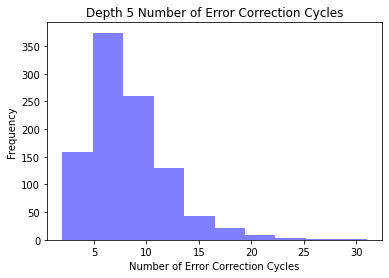

Mean: 7.967
Standard Deviation: 3.8225529427334295


In [26]:
num_bins_5 = 10
plt.hist(d5_dist, num_bins_5, facecolor='blue', alpha=.5)
plt.gca().set(title='Depth 5 Number of Error Correction Cycles', xlabel = "Number of Error Correction Cycles", ylabel='Frequency')
plt.show()
mean_d5 = sum(d5_dist) / len(d5_dist)
mean_d5 = sum(d5_dist) / len(d5_dist)
sd_d5 = statistics.pstdev(d5_dist) 
print('Mean: ' + str(mean_d5))
print('Standard Deviation: ' + str(sd_d5))

In [41]:
d5_dist_baseline = [5, 5, 6, 4, 9, 6, 9, 7, 5, 3, 9, 10, 3, 5, 8, 6, 10, 7, 13, 3, 6, 5, 9, 5, 8, 8, 6, 5, 9, 7, 8, 4, 4, 5, 5, 5, 7, 15, 3, 3, 5, 7, 7, 6, 5, 6, 5, 9, 4, 3, 8, 5, 5, 9, 4, 5, 14, 6, 4, 10, 5, 5, 6, 4, 7, 6, 5, 6, 5, 5, 3, 9, 4, 10, 9, 8, 6, 3, 7, 14, 4, 7, 6, 3, 5, 4, 3, 6, 11, 7, 6, 7, 10, 8, 6, 3, 4, 3, 8, 6, 5, 7, 7, 6, 6, 11, 10, 9, 4, 3, 7, 6, 4, 7, 5, 6, 9, 11, 8, 5, 7, 7, 4, 8, 5, 6, 10, 8, 10, 22, 5, 6, 7, 5, 2, 9, 5, 6, 7, 10, 7, 7, 8, 4, 9, 12, 5, 4, 7, 12, 6, 5, 10, 7, 8, 9, 8, 11, 6, 5, 6, 9, 9, 6, 5, 6, 6, 8, 5, 5, 5, 5, 2, 6, 6, 4, 7, 6, 4, 5, 8, 3, 8, 8, 11, 23, 10, 5, 8, 14, 5, 7, 4, 7, 7, 5, 9, 8, 4, 5, 6, 6, 7, 8, 6, 6, 13, 3, 6, 10, 6, 11, 6, 7, 9, 4, 12, 6, 8, 7, 4, 3, 8, 3, 8, 6, 5, 9, 8, 9, 4, 5, 9, 9, 6, 5, 5, 9, 5, 3, 10, 9, 10, 3, 5, 7, 6, 6, 6, 8, 6, 6, 9, 5, 11, 8, 5, 8, 10, 8, 6, 3, 7, 7, 7, 6, 6, 4, 5, 5, 6, 7, 6, 7, 6, 5, 7, 12, 11, 4, 11, 6, 4, 6, 4, 9, 8, 5, 3, 4, 4, 7, 8, 7, 6, 7, 15, 6, 7, 14, 5, 7, 5, 5, 10, 3, 8, 7, 5, 5, 5, 6, 4, 7, 4, 4, 4, 7, 7, 7, 5, 13, 14, 5, 5, 6, 16, 9, 9, 8, 12, 7, 11, 6, 6, 4, 5, 15, 7, 4, 6, 5, 9, 7, 11, 8, 5, 7, 7, 7, 5, 8, 6, 8, 6, 19, 7, 7, 4, 9, 9, 4, 4, 8, 11, 7, 5, 8, 5, 5, 4, 6, 8, 4, 15, 13, 8, 5, 5, 9, 11, 11, 5, 5, 8, 5, 3, 9, 10, 5, 10, 5, 7, 8, 8, 5, 3, 3, 6, 10, 10, 7, 4, 4, 3, 4, 3, 8, 7, 8, 6, 9, 7, 5, 6, 16, 5, 5, 7, 13, 13, 7, 2, 5, 5, 12, 5, 3, 7, 8, 17, 8, 7, 5, 12, 5, 10, 4, 4, 4, 4, 4, 8, 8, 8, 8, 6, 10, 13, 6, 10, 8, 10, 10, 5, 6, 9, 12, 7, 8, 4, 5, 6, 4, 11, 6, 7, 10, 14, 4, 4, 12, 13, 4, 15, 6, 9, 7, 9, 5, 7, 4, 12, 11, 9, 5, 5, 8, 5, 9, 9, 9, 3, 11, 8, 6, 6, 5, 6, 6, 13, 3, 5, 14, 15, 7, 5, 6, 7, 4, 5, 6, 7, 6, 8, 7, 7, 5, 10, 7, 6, 13, 9, 8, 8, 4, 6, 3, 12, 4, 10, 5, 6, 6, 13, 5, 5, 15, 9, 9, 8, 11, 8, 6, 10, 16, 8, 11, 5, 16, 6, 6, 5, 4, 8, 6, 6, 8, 7, 18, 5, 12, 3, 6, 2, 7, 8, 6, 5, 4, 10, 11, 6, 11, 6, 4, 8, 7, 8, 14, 11, 6, 10, 6, 8, 11, 6, 7, 4, 6, 6, 14, 6, 6, 5, 8, 4, 6, 4, 5, 5, 7, 6, 6, 7, 4, 5, 8, 6, 6, 6, 4, 9, 5, 7, 14, 11, 5, 5, 9, 11, 9, 11, 3, 6, 7, 6, 7, 5, 9, 4, 11, 7, 4, 5, 8, 7, 4, 10, 9, 4, 5, 6, 7, 14, 15, 3, 9, 6, 3, 8, 8, 10, 9, 8, 8, 7, 10, 4, 7, 7, 9, 20, 7, 8, 7, 12, 8, 7, 4, 17, 5, 6, 6, 10, 4, 20, 5, 7, 4, 10, 12, 4, 6, 5, 16, 3, 9, 6, 9, 10, 7, 5, 11, 11, 4, 4, 8, 7, 11, 11, 3, 4, 7, 8, 10, 6, 6, 7, 5, 14, 8, 5, 6, 5, 8, 9, 5, 4, 10, 9, 5, 6, 8, 9, 3, 6, 6, 5, 7, 5, 9, 3, 5, 6, 11, 11, 10, 5, 8, 5, 8, 7, 3, 9, 6, 7, 3, 4, 4, 4, 6, 6, 5, 5, 4, 5, 6, 12, 9, 6, 5, 6, 6, 4, 7, 6, 4, 7, 7, 4, 6, 5, 5, 6, 7, 5, 9, 5, 7, 15, 7, 3, 8, 10, 7, 4, 3, 5, 2, 4, 15, 2, 3, 7, 6, 3, 6, 5, 7, 9, 4, 5, 6, 7, 9, 4, 7, 11, 7, 10, 6, 7, 5, 4, 3, 6, 4, 2, 11, 5, 9, 6, 8, 5, 5, 9, 8, 9, 9, 3, 5, 11, 5, 9, 7, 8, 11, 12, 8, 5, 6, 13, 13, 8, 5, 9, 11, 4, 6, 4, 5, 10, 9, 5, 8, 5, 6, 7, 8, 8, 7, 6, 9, 6, 11, 10, 14, 8, 7, 23, 10, 6, 7, 8, 7, 8, 6, 4, 5, 17, 5, 5, 4, 9, 9, 8, 8, 3, 7, 8, 5, 6, 8, 4, 6, 4, 5, 8, 3, 4, 8, 5, 8, 5, 4, 8, 5, 4, 8, 3, 7, 7, 7, 7, 8, 3, 5, 5, 10, 7, 4, 12, 5, 9, 3, 3, 5, 3, 6, 10, 5, 4, 5, 8, 3, 7, 9, 9, 14, 5, 5, 13, 6, 9, 5, 20, 3, 6, 8, 3, 12, 7, 5, 4, 13, 3, 9, 6, 7, 6, 5, 7, 8, 7, 7, 8, 5, 7, 6, 12, 12, 6, 4, 7, 4, 5, 14, 4, 7, 10, 6, 4, 5, 5, 6, 7, 9, 7, 15, 8, 7, 6, 8, 5, 18, 8, 6, 12, 10]
d5_dist_v2_1k = [4, 6, 4, 5, 5, 3, 5, 4, 4, 4, 3, 7, 6, 7, 5, 4, 2, 2, 4, 5, 4, 4, 4, 5, 7, 5, 3, 5, 4, 3, 3, 3, 4, 6, 4, 4, 6, 4, 6, 6, 4, 4, 5, 4, 4, 5, 5, 4, 4, 4, 6, 4, 8, 5, 5, 3, 6, 5, 4, 5, 4, 4, 3, 4, 5, 4, 3, 4, 5, 3, 3, 4, 6, 4, 3, 3, 7, 6, 4, 6, 6, 6, 6, 3, 5, 4, 6, 6, 6, 3, 3, 5, 4, 4, 6, 5, 3, 6, 4, 4, 4, 5, 6, 3, 5, 4, 6, 3, 2, 6, 7, 3, 4, 5, 7, 6, 3, 4, 7, 4, 4, 5, 5, 4, 5, 5, 3, 4, 4, 4, 5, 6, 4, 9, 5, 4, 4, 4, 4, 3, 4, 6, 3, 3, 4, 3, 5, 8, 6, 6, 2, 3, 3, 3, 8, 3, 5, 5, 4, 5, 6, 3, 4, 5, 4, 5, 6, 5, 5, 5, 4, 5, 5, 4, 5, 4, 6, 3, 8, 5, 4, 6, 2, 3, 7, 5, 5, 4, 5, 6, 6, 4, 4, 4, 5, 5, 3, 3, 5, 4, 4, 4, 3, 5, 4, 3, 4, 5, 4, 5, 5, 4, 6, 6, 4, 3, 4, 4, 3, 5, 5, 4, 4, 5, 6, 6, 5, 4, 5, 6, 5, 3, 6, 6, 8, 8, 6, 5, 3, 4, 6, 6, 4, 3, 3, 5, 3, 5, 4, 4, 5, 4, 5, 6, 4, 4, 4, 5, 5, 4, 4, 4, 5, 9, 4, 5, 5, 5, 5, 4, 4, 7, 8, 5, 6, 5, 4, 4, 3, 4, 4, 5, 4, 5, 3, 3, 6, 4, 3, 4, 7, 6, 5, 7, 5, 5, 3, 4, 2, 4, 5, 4, 5, 3, 6, 4, 3, 4, 6, 5, 6, 4, 4, 4, 3, 5, 5, 3, 3, 7, 6, 5, 3, 5, 5, 6, 3, 4, 6, 3, 5, 4, 4, 3, 5, 6, 5, 4, 6, 4, 4, 7, 5, 3, 3, 5, 3, 4, 6, 3, 3, 4, 5, 4, 4, 4, 4, 8, 4, 3, 4, 3, 4, 6, 5, 7, 6, 5, 7, 4, 3, 3, 4, 3, 2, 4, 4, 5, 3, 2, 5, 3, 3, 4, 7, 6, 6, 5, 6, 3, 2, 4, 5, 4, 4, 6, 4, 3, 4, 5, 6, 4, 7, 4, 4, 4, 4, 5, 4, 3, 3, 3, 6, 8, 5, 3, 3, 4, 5, 5, 6, 3, 6, 4, 4, 7, 5, 5, 5, 3, 5, 5, 6, 3, 6, 5, 8, 5, 5, 4, 6, 5, 5, 3, 4, 6, 5, 4, 4, 3, 7, 3, 3, 5, 7, 4, 5, 5, 3, 7, 6, 6, 3, 6, 4, 5, 4, 5, 3, 3, 4, 4, 3, 4, 4, 7, 6, 5, 6, 7, 4, 4, 6, 5, 4, 3, 3, 3, 6, 5, 8, 6, 8, 5, 3, 4, 6, 4, 7, 3, 4, 6, 6, 4, 2, 4, 4, 7, 7, 6, 12, 6, 4, 6, 7, 5, 6, 4, 4, 3, 3, 2, 3, 5, 6, 4, 5, 6, 6, 3, 6, 5, 5, 4, 2, 5, 4, 4, 5, 4, 5, 3, 4, 3, 4, 4, 6, 3, 4, 5, 7, 3, 3, 7, 7, 5, 3, 5, 5, 4, 5, 5, 3, 6, 4, 4, 4, 5, 6, 5, 5, 5, 5, 4, 4, 3, 4, 4, 4, 6, 3, 4, 5, 7, 4, 3, 4, 5, 5, 3, 5, 4, 6, 4, 3, 6, 4, 5, 5, 6, 4, 5, 5, 5, 4, 5, 5, 4, 5, 9, 5, 6, 4, 7, 4, 5, 4, 5, 4, 4, 4, 4, 5, 4, 4, 4, 7, 5, 7, 5, 4, 5, 5, 6, 4, 4, 3, 4, 6, 4, 4, 5, 8, 4, 3, 4, 4, 5, 4, 4, 5, 6, 4, 4, 4, 8, 3, 7, 3, 5, 6, 3, 7, 4, 4, 5, 5, 3, 5, 3, 3, 6, 4, 5, 3, 6, 2, 3, 3, 3, 6, 7, 8, 3, 7, 2, 3, 4, 4, 4, 4, 3, 6, 3, 4, 8, 6, 5, 6, 4, 5, 3, 7, 4, 4, 5, 4, 2, 4, 5, 4, 5, 3, 5, 3, 5, 2, 3, 5, 5, 3, 7, 5, 4, 4, 4, 6, 3, 5, 5, 4, 5, 7, 6, 6, 3, 4, 4, 5, 4, 4, 4, 2, 5, 7, 5, 4, 4, 4, 6, 3, 5, 3, 4, 5, 2, 6, 4, 5, 5, 9, 3, 8, 8, 3, 5, 4, 4, 5, 4, 6, 5, 4, 4, 4, 4, 8, 5, 5, 7, 4, 4, 6, 8, 4, 5, 3, 4, 7, 8, 6, 4, 3, 4, 6, 6, 6, 4, 3, 3, 3, 6, 4, 4, 4, 3, 5, 5, 4, 5, 5, 4, 5, 4, 4, 7, 4, 4, 5, 5, 6, 3, 3, 5, 4, 4, 5, 5, 5, 5, 3, 4, 5, 4, 4, 5, 6, 4, 4, 4, 6, 6, 3, 6, 3, 6, 3, 10, 6, 4, 4, 4, 3, 2, 5, 4, 4, 2, 3, 4, 9, 6, 4, 5, 4, 9, 4, 5, 5, 2, 5, 7, 3, 5, 4, 6, 4, 5, 6, 4, 6, 3, 3, 4, 5, 5, 6, 6, 6, 3, 6, 5, 3, 4, 3, 3, 4, 6, 7, 2, 3, 3, 5, 3, 6, 3, 7, 5, 2, 4, 5, 7, 4, 4, 5, 6, 4, 6, 4, 5, 5, 3, 4, 3, 5, 5, 5, 5, 4, 4, 6, 4, 3, 3, 6, 4, 3, 3, 6, 5, 4, 3, 2, 5, 3, 3, 5, 5, 4, 6, 6, 4, 5, 5, 4, 4, 9, 5, 7, 5, 4, 4, 5, 5, 5, 8, 6, 5, 3, 6, 4, 6, 4, 6, 5, 3, 2, 2, 7, 3, 7, 3, 4, 3, 5, 3, 6, 6, 7, 4, 4, 3, 4, 5, 4, 5, 4, 5, 5, 7]
d5_dist_v2_10k = [5, 12, 12, 8, 4, 3, 4, 5, 4, 7, 4, 5, 7, 8, 6, 3, 7, 4, 7, 5, 7, 5, 5, 6, 5, 6, 8, 5, 2, 7, 6, 3, 5, 5, 3, 7, 7, 5, 6, 6, 9, 4, 2, 5, 6, 7, 3, 8, 8, 15, 9, 5, 5, 5, 5, 9, 5, 4, 4, 5, 4, 7, 4, 7, 4, 10, 7, 9, 6, 4, 7, 5, 9, 5, 6, 11, 6, 3, 6, 13, 7, 7, 4, 6, 6, 4, 5, 4, 6, 6, 4, 4, 3, 6, 3, 5, 5, 7, 8, 4, 10, 4, 7, 6, 5, 6, 4, 5, 6, 2, 5, 7, 5, 5, 7, 7, 4, 4, 3, 3, 5, 3, 7, 4, 6, 7, 4, 11, 4, 4, 3, 4, 8, 3, 6, 14, 4, 5, 5, 3, 4, 8, 4, 6, 5, 3, 8, 5, 4, 6, 3, 5, 8, 6, 6, 6, 4, 4, 6, 5, 3, 9, 3, 7, 5, 6, 4, 6, 10, 6, 5, 4, 7, 5, 6, 9, 5, 3, 4, 4, 7, 4, 3, 8, 6, 4, 3, 3, 3, 9, 3, 10, 9, 3, 5, 10, 5, 3, 4, 5, 5, 6, 6, 9, 10, 5, 5, 3, 2, 4, 9, 3, 8, 3, 10, 3, 7, 4, 4, 4, 6, 2, 4, 9, 5, 7, 10, 11, 13, 5, 8, 7, 14, 4, 7, 3, 3, 3, 12, 7, 6, 6, 5, 8, 5, 4, 5, 3, 4, 4, 2, 3, 12, 4, 7, 6, 8, 9, 10, 7, 6, 3, 5, 5, 3, 6, 4, 6, 3, 7, 5, 3, 3, 4, 6, 7, 5, 5, 3, 6, 6, 4, 4, 4, 8, 5, 5, 7, 5, 6, 6, 4, 7, 10, 5, 7, 9, 5, 3, 7, 6, 5, 10, 7, 6, 3, 2, 4, 7, 6, 8, 6, 7, 5, 5, 5, 6, 4, 3, 2, 10, 4, 6, 3, 5, 2, 6, 5, 5, 5, 9, 10, 9, 14, 6, 10, 6, 8, 4, 7, 7, 4, 8, 3, 4, 3, 4, 13, 3, 6, 3, 5, 4, 4, 5, 4, 7, 8, 10, 8, 6, 7, 8, 7, 4, 3, 6, 7, 3, 7, 5, 4, 9, 2, 3, 5, 9, 5, 2, 13, 7, 9, 3, 8, 5, 4, 5, 7, 10, 7, 8, 3, 3, 4, 5, 6, 5, 9, 4, 8, 10, 4, 7, 8, 4, 4, 9, 2, 5, 3, 6, 4, 4, 4, 5, 4, 10, 7, 5, 6, 6, 10, 5, 5, 3, 8, 5, 5, 3, 5, 4, 10, 11, 4, 10, 9, 5, 4, 15, 7, 3, 6, 6, 3, 4, 4, 4, 13, 7, 5, 4, 12, 6, 8, 3, 7, 8, 6, 4, 4, 8, 6, 9, 5, 5, 12, 8, 5, 5, 5, 5, 4, 9, 5, 4, 7, 6, 2, 9, 7, 8, 5, 9, 3, 4, 4, 2, 7, 4, 2, 3, 3, 2, 4, 7, 5, 3, 7, 7, 7, 7, 3, 10, 2, 4, 4, 3, 12, 8, 5, 4, 5, 6, 8, 6, 8, 5, 6, 7, 4, 4, 4, 3, 3, 8, 5, 6, 4, 3, 5, 7, 7, 5, 8, 7, 4, 5, 6, 3, 4, 8, 6, 12, 9, 5, 11, 4, 6, 4, 6, 8, 4, 8, 6, 4, 5, 6, 9, 4, 5, 6, 4, 7, 15, 6, 6, 11, 5, 7, 9, 4, 5, 5, 8, 5, 6, 4, 12, 3, 6, 5, 5, 3, 8, 7, 4, 2, 9, 4, 5, 8, 3, 8, 4, 4, 5, 12, 4, 10, 6, 3, 4, 8, 6, 4, 8, 8, 3, 4, 4, 5, 2, 7, 10, 8, 4, 12, 5, 5, 4, 15, 3, 11, 5, 4, 3, 3, 5, 7, 8, 6, 7, 6, 5, 7, 4, 4, 3, 3, 6, 8, 9, 3, 13, 6, 8, 12, 3, 4, 8, 4, 4, 6, 9, 6, 3, 3, 7, 5, 7, 18, 11, 7, 7, 7, 6, 8, 12, 2, 10, 13, 12, 4, 4, 4, 3, 4, 5, 6, 4, 7, 2, 4, 4, 6, 3, 4, 4, 5, 4, 11, 5, 9, 5, 5, 4, 4, 8, 3, 6, 4, 14, 6, 4, 6, 11, 4, 3, 11, 6, 5, 5, 8, 6, 6, 9, 3, 10, 5, 3, 7, 5, 7, 7, 3, 5, 4, 7, 6, 5, 10, 2, 4, 7, 4, 3, 9, 3, 6, 4, 5, 5, 9, 7, 6, 9, 7, 4, 4, 5, 7, 5, 7, 3, 4, 4, 16, 7, 7, 8, 9, 3, 3, 4, 2, 6, 12, 8, 5, 9, 7, 5, 3, 3, 4, 8, 3, 3, 4, 6, 5, 4, 3, 9, 5, 7, 4, 5, 4, 4, 7, 6, 6, 3, 5, 5, 5, 4, 9, 4, 5, 8, 6, 11, 7, 11, 3, 3, 5, 6, 7, 3, 4, 6, 6, 2, 5, 14, 6, 2, 5, 7, 4, 3, 3, 5, 11, 5, 3, 5, 10, 7, 3, 5, 4, 7, 5, 4, 3, 5, 4, 3, 6, 5, 3, 3, 9, 2, 3, 8, 3, 13, 4, 8, 3, 6, 3, 8, 4, 4, 4, 4, 6, 4, 3, 7, 4, 6, 4, 5, 3, 7, 6, 6, 4, 6, 5, 7, 8, 5, 5, 5, 3, 7, 14, 8, 6, 5, 3, 6, 3, 5, 5, 10, 8, 3, 2, 3, 4, 4, 5, 6, 2, 11, 3, 10, 7, 6, 5, 7, 7, 5, 3, 9, 6, 9, 4, 3, 8, 6, 4, 5, 7, 4, 3, 2, 5, 3, 8, 4, 7, 3, 9, 8, 7, 3, 5, 9, 5, 9, 6, 4, 5, 3, 3, 3, 6, 6, 5, 5, 5, 10, 7, 6, 11, 8, 4, 7, 3, 4, 6, 5, 3, 8, 4, 4, 8, 8, 9, 6, 3, 8, 3, 6, 5, 5, 7, 6, 6, 8, 15, 4, 6, 5, 15, 4, 11, 9, 4, 10, 5, 2, 5, 6, 9, 16, 3, 3, 7, 3]
d5_dist_v2_100k = [3, 7, 3, 4, 5, 5, 6, 7, 4, 6, 8, 5, 7, 7, 7, 12, 3, 11, 4, 4, 5, 5, 6, 18, 10, 4, 3, 6, 10, 4, 5, 7, 8, 4, 7, 4, 6, 7, 9, 5, 6, 4, 9, 5, 6, 4, 5, 4, 4, 5, 5, 6, 8, 8, 4, 5, 4, 8, 6, 4, 3, 16, 8, 6, 8, 6, 7, 7, 7, 2, 10, 7, 5, 2, 5, 12, 7, 8, 9, 4, 14, 4, 4, 9, 4, 4, 9, 3, 5, 6, 9, 9, 8, 4, 3, 9, 11, 4, 6, 7, 4, 5, 14, 8, 10, 5, 5, 11, 7, 4, 6, 5, 6, 5, 5, 6, 6, 6, 6, 4, 3, 3, 7, 8, 6, 7, 6, 3, 3, 2, 6, 7, 9, 7, 7, 5, 3, 5, 6, 8, 10, 9, 2, 7, 6, 6, 10, 4, 17, 4, 6, 5, 5, 10, 10, 4, 5, 3, 7, 9, 6, 5, 3, 5, 4, 3, 4, 4, 7, 4, 7, 3, 3, 4, 11, 7, 5, 3, 5, 5, 10, 9, 10, 6, 5, 6, 7, 4, 4, 9, 7, 2, 5, 7, 4, 7, 10, 4, 6, 5, 6, 6, 4, 9, 5, 6, 8, 8, 7, 4, 6, 7, 5, 6, 7, 7, 7, 9, 5, 6, 8, 3, 5, 5, 5, 12, 9, 3, 8, 4, 5, 6, 6, 3, 9, 7, 6, 6, 4, 7, 3, 5, 6, 7, 6, 5, 4, 4, 6, 11, 9, 6, 3, 9, 9, 4, 6, 7, 11, 11, 7, 5, 3, 6, 7, 6, 10, 6, 9, 4, 8, 6, 7, 7, 7, 6, 6, 5, 10, 4, 3, 6, 7, 8, 7, 6, 4, 5, 5, 5, 6, 6, 9, 5, 3, 6, 10, 9, 7, 8, 6, 2, 10, 5, 7, 3, 3, 5, 6, 4, 5, 6, 5, 6, 8, 5, 6, 4, 4, 8, 5, 6, 5, 6, 4, 5, 5, 4, 6, 7, 6, 6, 10, 7, 7, 4, 7, 11, 6, 5, 7, 3, 6, 17, 5, 6, 11, 9, 4, 5, 5, 4, 5, 8, 8, 5, 5, 6, 6, 7, 6, 5, 6, 7, 7, 6, 7, 10, 5, 6, 11, 4, 5, 6, 7, 4, 5, 5, 5, 5, 5, 8, 6, 4, 3, 13, 5, 5, 8, 6, 3, 7, 3, 2, 9, 5, 4, 4, 7, 4, 6, 3, 4, 9, 6, 5, 4, 4, 6, 4, 6, 6, 7, 6, 4, 11, 6, 7, 6, 5, 8, 5, 6, 5, 4, 3, 4, 4, 6, 3, 2, 3, 8, 9, 9, 11, 5, 7, 8, 7, 7, 10, 6, 7, 7, 3, 3, 7, 7, 5, 9, 4, 14, 7, 5, 5, 6, 6, 5, 5, 4, 7, 6, 4, 3, 9, 4, 3, 14, 6, 4, 5, 6, 6, 5, 8, 3, 6, 3, 8, 5, 3, 4, 5, 8, 11, 6, 4, 7, 5, 6, 6, 10, 4, 5, 3, 4, 4, 6, 8, 3, 6, 9, 8, 3, 7, 5, 6, 7, 4, 4, 12, 6, 7, 4, 4, 7, 2, 3, 4, 8, 5, 9, 8, 5, 5, 4, 7, 10, 3, 10, 8, 9, 8, 5, 6, 4, 4, 4, 13, 7, 7, 4, 5, 4, 4, 7, 6, 14, 6, 5, 9, 4, 6, 4, 7, 5, 4, 6, 4, 6, 5, 4, 5, 6, 5, 7, 5, 6, 3, 4, 6, 2, 7, 3, 5, 5, 4, 7, 12, 7, 5, 12, 9, 2, 7, 3, 5, 4, 5, 5, 5, 9, 7, 7, 20, 7, 9, 7, 10, 14, 9, 5, 9, 5, 5, 5, 5, 3, 4, 3, 4, 7, 6, 5, 11, 6, 3, 10, 12, 7, 4, 8, 5, 8, 8, 3, 7, 4, 4, 9, 8, 7, 7, 3, 5, 4, 5, 4, 5, 6, 5, 5, 5, 7, 4, 4, 6, 4, 7, 4, 10, 5, 7, 4, 7, 5, 8, 5, 7, 9, 7, 6, 6, 9, 6, 11, 3, 4, 3, 7, 4, 12, 4, 6, 7, 8, 5, 5, 4, 8, 2, 5, 10, 3, 3, 6, 6, 7, 6, 9, 6, 6, 5, 8, 4, 6, 4, 4, 3, 3, 12, 3, 6, 6, 7, 9, 7, 10, 7, 2, 3, 7, 5, 8, 4, 5, 6, 6, 8, 4, 4, 7, 11, 4, 6, 6, 8, 6, 9, 7, 4, 7, 11, 5, 7, 5, 15, 8, 6, 4, 4, 4, 6, 6, 5, 5, 6, 6, 6, 4, 10, 7, 9, 2, 5, 6, 6, 7, 8, 7, 4, 6, 8, 8, 6, 9, 9, 4, 7, 5, 7, 8, 3, 5, 4, 4, 4, 5, 6, 5, 5, 5, 8, 8, 2, 7, 4, 7, 4, 9, 7, 4, 3, 5, 8, 7, 5, 5, 3, 4, 13, 6, 9, 6, 6, 4, 4, 7, 10, 5, 6, 6, 9, 8, 4, 4, 6, 2, 9, 4, 5, 19, 4, 3, 5, 5, 5, 5, 5, 5, 7, 5, 5, 8, 6, 7, 5, 5, 3, 5, 2, 4, 8, 6, 3, 6, 9, 4, 6, 5, 9, 6, 4, 4, 4, 4, 3, 4, 8, 8, 6, 11, 4, 7, 3, 13, 9, 4, 4, 6, 8, 5, 4, 9, 8, 6, 5, 8, 7, 7, 5, 4, 8, 4, 6, 5, 6, 9, 6, 5, 2, 6, 5, 7, 4, 7, 14, 5, 8, 7, 6, 6, 6, 8, 6, 4, 9, 5, 4, 5, 6, 19, 7, 4, 4, 5, 8, 3, 5, 6, 8, 5, 9, 5, 7, 8, 6, 4, 4, 4, 9, 5, 7, 5, 9, 7, 4, 5, 7, 4, 6, 4, 9, 6, 8, 5, 8, 6, 7, 5, 6, 11, 8, 4, 11, 4, 4, 6, 5, 10, 5, 4, 6, 8, 4, 4, 4, 4, 4, 6, 5, 3, 6, 5, 9, 2, 3, 5, 6, 7, 7, 9, 5, 8, 10, 5, 8, 4, 8, 5, 4, 10, 5, 4, 4, 9, 7, 3, 5]
d5_dist_v3_1k = [5, 6, 9, 5, 6, 2, 5, 7, 5, 8, 4, 3, 4, 5, 4, 4, 7, 5, 2, 4, 4, 4, 9, 3, 5, 5, 3, 6, 4, 3, 4, 4, 6, 4, 4, 6, 5, 4, 4, 4, 4, 2, 3, 3, 3, 4, 4, 4, 4, 3, 5, 5, 4, 4, 4, 4, 5, 4, 4, 4, 6, 5, 4, 5, 4, 2, 4, 3, 2, 4, 4, 5, 5, 5, 4, 6, 4, 4, 4, 5, 3, 5, 3, 4, 4, 4, 5, 3, 3, 3, 5, 5, 4, 4, 4, 4, 6, 8, 4, 2, 7, 9, 5, 3, 4, 4, 6, 6, 5, 3, 6, 4, 4, 5, 4, 6, 5, 5, 5, 4, 4, 5, 4, 2, 3, 6, 3, 5, 8, 5, 7, 5, 2, 5, 3, 2, 4, 5, 5, 3, 4, 3, 5, 5, 4, 4, 6, 4, 5, 4, 3, 2, 4, 3, 7, 3, 4, 4, 4, 6, 7, 5, 5, 5, 6, 5, 4, 5, 5, 5, 3, 5, 8, 4, 6, 4, 5, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 3, 3, 3, 4, 5, 5, 5, 3, 3, 4, 6, 4, 4, 3, 3, 4, 5, 4, 5, 5, 4, 5, 4, 6, 2, 7, 5, 3, 3, 4, 5, 3, 2, 6, 4, 6, 4, 3, 3, 3, 6, 7, 4, 5, 3, 6, 3, 5, 5, 4, 5, 4, 4, 5, 4, 2, 5, 5, 4, 5, 4, 4, 5, 4, 4, 6, 5, 6, 4, 4, 4, 3, 4, 5, 5, 4, 3, 3, 4, 5, 5, 2, 5, 5, 3, 6, 4, 3, 4, 4, 3, 6, 5, 4, 6, 3, 5, 6, 5, 6, 6, 7, 4, 6, 3, 2, 5, 6, 4, 6, 3, 9, 5, 5, 4, 4, 3, 5, 4, 6, 6, 3, 6, 6, 3, 2, 4, 10, 4, 6, 7, 3, 5, 6, 5, 3, 6, 9, 3, 3, 7, 4, 4, 4, 4, 4, 5, 3, 6, 6, 4, 4, 5, 3, 6, 4, 4, 3, 5, 3, 4, 3, 4, 4, 3, 7, 8, 6, 3, 3, 5, 2, 3, 4, 5, 4, 5, 5, 3, 4, 7, 3, 3, 3, 6, 4, 2, 4, 4, 3, 3, 3, 4, 2, 5, 2, 5, 3, 5, 4, 5, 5, 4, 9, 3, 5, 6, 4, 3, 5, 3, 4, 3, 5, 5, 3, 3, 4, 4, 5, 2, 6, 4, 4, 5, 8, 5, 5, 5, 3, 4, 4, 6, 4, 5, 3, 4, 4, 4, 4, 4, 3, 5, 5, 4, 8, 5, 8, 4, 6, 3, 3, 5, 6, 4, 5, 4, 5, 6, 3, 5, 4, 5, 5, 4, 2, 5, 5, 4, 4, 5, 3, 4, 5, 5, 5, 5, 4, 3, 4, 5, 4, 4, 4, 6, 5, 6, 3, 4, 5, 5, 4, 4, 4, 3, 6, 2, 7, 4, 5, 5, 9, 5, 4, 5, 4, 6, 3, 2, 3, 4, 4, 3, 5, 4, 5, 4, 3, 4, 4, 4, 3, 5, 5, 5, 5, 5, 4, 5, 4, 3, 4, 6, 5, 4, 5, 4, 5, 4, 5, 5, 5, 5, 6, 7, 7, 5, 4, 4, 7, 4, 6, 3, 4, 5, 4, 4, 3, 6, 6, 5, 5, 4, 7, 4, 5, 5, 4, 4, 4, 4, 4, 7, 6, 5, 4, 2, 4, 4, 3, 4, 7, 5, 4, 5, 5, 4, 5, 4, 3, 4, 4, 5, 4, 4, 4, 4, 6, 5, 6, 5, 4, 4, 4, 4, 4, 4, 6, 2, 6, 4, 4, 4, 3, 5, 2, 2, 6, 5, 5, 6, 5, 7, 8, 3, 5, 5, 4, 5, 5, 4, 3, 5, 6, 4, 5, 10, 3, 3, 4, 4, 4, 4, 4, 7, 4, 4, 3, 5, 3, 4, 5, 4, 3, 3, 4, 5, 4, 6, 5, 5, 6, 5, 6, 4, 5, 5, 3, 4, 3, 3, 5, 3, 4, 4, 8, 6, 4, 3, 4, 4, 4, 4, 4, 4, 5, 5, 8, 2, 5, 5, 4, 5, 5, 5, 4, 5, 5, 5, 2, 7, 2, 4, 8, 6, 6, 3, 2, 4, 6, 3, 4, 3, 6, 5, 5, 6, 4, 6, 5, 5, 4, 3, 3, 5, 4, 7, 6, 4, 3, 3, 2, 4, 4, 4, 3, 6, 6, 5, 3, 6, 6, 6, 5, 6, 4, 5, 4, 7, 8, 4, 3, 6, 4, 6, 5, 4, 2, 5, 5, 5, 3, 5, 8, 6, 8, 5, 3, 3, 7, 4, 3, 4, 5, 4, 4, 5, 5, 3, 6, 6, 7, 7, 6, 5, 4, 6, 7, 7, 3, 7, 5, 2, 5, 4, 4, 5, 5, 4, 6, 5, 2, 5, 6, 6, 4, 2, 7, 2, 4, 7, 5, 6, 4, 3, 4, 6, 3, 6, 3, 2, 3, 6, 3, 3, 3, 3, 7, 5, 3, 3, 3, 4, 5, 5, 8, 4, 3, 3, 4, 6, 5, 4, 7, 5, 4, 7, 2, 5, 3, 4, 6, 2, 5, 2, 3, 5, 6, 4, 4, 3, 5, 4, 6, 3, 4, 4, 5, 3, 4, 6, 5, 4, 4, 4, 4, 5, 6, 5, 3, 6, 4, 7, 3, 4, 5, 5, 6, 6, 4, 4, 4, 5, 5, 5, 4, 5, 6, 7, 5, 5, 8, 3, 3, 4, 3, 6, 3, 6, 4, 3, 6, 6, 3, 6, 4, 3, 4, 2, 5, 5, 3, 2, 5, 4, 5, 6, 5, 4, 4, 4, 3, 3, 4, 2, 5, 6, 5, 5, 3, 4, 4, 4, 4, 5, 6, 4, 6, 5, 5, 3, 5, 7, 6, 4, 6, 3, 3, 6, 3, 4, 5, 4, 6, 7, 5, 3, 6, 3, 4, 4, 5, 3, 4, 5, 5, 5, 5, 4, 5, 5, 5, 4, 4, 2, 5, 3, 6, 4, 4, 2, 4, 4, 5, 5, 6, 5, 3, 4, 7, 4, 5, 3, 6, 4, 3, 3, 3, 4, 4, 5, 6, 4]
d5_dist_v3_10k = [7, 14, 6, 16, 11, 7, 7, 8, 3, 11, 6, 4, 10, 7, 12, 6, 6, 7, 4, 8, 7, 2, 11, 8, 4, 8, 7, 6, 8, 6, 6, 8, 13, 7, 5, 6, 10, 10, 8, 12, 10, 8, 8, 10, 6, 6, 11, 6, 4, 20, 8, 6, 8, 11, 3, 9, 15, 5, 5, 6, 5, 14, 6, 5, 13, 14, 6, 5, 5, 8, 5, 8, 7, 5, 11, 6, 9, 6, 13, 3, 11, 12, 14, 5, 5, 16, 8, 8, 5, 8, 7, 8, 7, 9, 8, 10, 10, 12, 11, 8, 3, 7, 10, 9, 6, 5, 10, 5, 5, 9, 10, 7, 6, 10, 5, 6, 10, 11, 6, 6, 8, 6, 9, 4, 4, 8, 8, 6, 7, 6, 8, 9, 3, 11, 10, 5, 7, 4, 6, 4, 5, 3, 14, 6, 5, 5, 10, 9, 12, 6, 12, 14, 6, 4, 4, 5, 9, 10, 4, 8, 9, 5, 7, 3, 6, 8, 8, 10, 12, 9, 6, 7, 3, 6, 11, 7, 9, 10, 6, 4, 10, 6, 6, 6, 7, 11, 4, 8, 9, 9, 5, 11, 11, 14, 12, 7, 10, 9, 9, 9, 7, 12, 6, 3, 6, 5, 10, 6, 11, 4, 10, 10, 4, 6, 8, 12, 4, 6, 5, 9, 8, 5, 7, 7, 5, 4, 12, 9, 5, 5, 3, 6, 14, 6, 5, 6, 5, 5, 9, 5, 6, 8, 4, 4, 4, 8, 8, 3, 15, 7, 13, 5, 4, 4, 4, 9, 11, 8, 4, 4, 7, 7, 9, 11, 6, 8, 5, 8, 13, 5, 7, 17, 3, 6, 5, 6, 5, 5, 8, 11, 3, 18, 9, 10, 9, 4, 4, 7, 5, 5, 8, 6, 5, 22, 15, 4, 4, 8, 9, 13, 6, 7, 7, 4, 4, 8, 3, 5, 4, 5, 6, 6, 11, 5, 5, 5, 12, 8, 6, 9, 7, 6, 7, 8, 13, 8, 7, 7, 11, 7, 11, 13, 18, 6, 20, 14, 8, 12, 5, 9, 5, 9, 13, 7, 4, 6, 7, 15, 6, 5, 3, 14, 12, 14, 4, 6, 14, 13, 9, 9, 12, 5, 13, 6, 5, 10, 5, 10, 8, 4, 4, 14, 5, 8, 4, 10, 7, 10, 11, 6, 11, 9, 7, 9, 6, 7, 7, 6, 7, 13, 8, 5, 4, 10, 9, 5, 6, 4, 9, 15, 5, 17, 5, 12, 15, 6, 7, 8, 8, 8, 16, 4, 7, 9, 7, 6, 6, 9, 4, 5, 17, 6, 13, 11, 5, 8, 10, 15, 8, 5, 5, 5, 7, 4, 5, 5, 8, 5, 6, 7, 7, 4, 12, 6, 9, 5, 26, 10, 4, 14, 16, 5, 10, 5, 13, 10, 6, 5, 4, 10, 12, 8, 9, 9, 6, 7, 11, 6, 5, 8, 17, 9, 10, 7, 8, 27, 6, 5, 4, 15, 15, 7, 6, 6, 5, 5, 11, 6, 4, 10, 5, 10, 7, 6, 7, 3, 11, 11, 12, 9, 21, 10, 7, 4, 6, 4, 4, 4, 12, 9, 13, 11, 5, 5, 9, 4, 11, 9, 4, 7, 9, 7, 8, 9, 3, 9, 13, 6, 6, 9, 5, 5, 4, 8, 6, 5, 6, 6, 6, 4, 7, 3, 4, 7, 10, 8, 6, 6, 4, 10, 7, 13, 7, 12, 9, 6, 16, 5, 9, 10, 9, 4, 21, 8, 5, 4, 11, 7, 4, 4, 9, 8, 8, 7, 6, 6, 5, 6, 17, 8, 18, 6, 5, 11, 4, 9, 9, 8, 6, 5, 3, 15, 12, 12, 8, 7, 6, 9, 9, 4, 12, 15, 6, 17, 13, 6, 16, 6, 8, 9, 8, 6, 5, 13, 8, 9, 6, 5, 7, 3, 5, 8, 10, 6, 6, 10, 10, 4, 5, 5, 11, 5, 14, 6, 8, 9, 3, 7, 8, 6, 13, 5, 12, 19, 5, 14, 13, 4, 4, 9, 8, 6, 3, 5, 11, 6, 5, 4, 6, 5, 13, 9, 4, 12, 12, 6, 5, 4, 5, 7, 4, 5, 10, 4, 9, 8, 10, 10, 6, 11, 8, 9, 5, 4, 3, 5, 9, 7, 6, 2, 4, 8, 13, 8, 9, 10, 7, 5, 8, 12, 19, 13, 6, 6, 9, 11, 10, 8, 7, 5, 13, 6, 11, 5, 10, 9, 5, 5, 10, 6, 2, 11, 10, 7, 15, 5, 5, 5, 8, 6, 4, 4, 12, 12, 7, 13, 12, 6, 4, 17, 3, 12, 6, 8, 3, 4, 8, 6, 7, 7, 4, 8, 17, 9, 9, 10, 6, 4, 10, 9, 6, 9, 7, 5, 8, 12, 4, 12, 9, 13, 12, 9, 5, 12, 8, 9, 3, 5, 9, 5, 6, 7, 13, 4, 6, 6, 9, 8, 6, 5, 11, 11, 6, 6, 10, 9, 11, 8, 6, 7, 6, 7, 5, 7, 6, 6, 6, 6, 3, 11, 5, 9, 5, 8, 11, 5, 4, 7, 6, 5, 10, 7, 10, 8, 7, 3, 7, 5, 9, 5, 8, 8, 16, 11, 4, 9, 6, 8, 7, 8, 17, 6, 7, 11, 4, 15, 4, 9, 6, 4, 7, 9, 3, 6, 20, 5, 13, 6, 5, 4, 7, 7, 6, 10, 11, 12, 8, 4, 6, 7, 3, 5, 5, 5, 7, 10, 8, 5, 12, 5, 6, 6, 8, 6, 9, 4, 6, 3, 10, 6, 4, 6, 8, 12, 4, 5, 7, 7, 14, 10, 9, 4, 16, 3, 7, 5, 3, 17, 5, 6, 8, 8, 4, 10, 7, 5, 5, 14, 5, 5, 11, 7, 5, 6, 13, 6, 4, 5, 6, 8, 6, 5, 10, 6, 11, 6, 10, 3, 4, 11, 5, 6, 3, 9, 11, 5, 9, 4, 10, 9, 5, 6, 6, 17, 4, 9, 8, 9, 6, 4, 4, 4, 10, 10, 8, 7, 15, 7, 8, 7, 13, 6, 4, 5, 11, 3, 10, 5, 8, 12, 11, 4, 12, 18, 6, 10, 4, 11, 16, 20, 3, 9, 11, 11, 4, 7, 4, 7, 4, 5]

#stats.kruskal(d5_dist_baseline, d5_dist_v2_1k)
#stats.kruskal(d5_dist_baseline, d5_dist_v2_10k)
#stats.kruskal(d5_dist_baseline, d5_dist_v2_100k)
#stats.kruskal(d5_dist_baseline, d5_dist_v3_1k)
stats.kruskal(d5_dist_baseline, d5_dist_v3_10k)

KruskalResult(statistic=20.89361018568665, pvalue=4.855114651495443e-06)

# Depth 7

In [22]:
circuit = ToricCircuit(7)
d7_dist = []
mlb = MultiLabelBinarizer()
mlb.fit([['', 'X00', 'X01', 'X02', 'X03', 'X04','X05', 'X06', 'X10', 'X11', 'X12', 'X13',
 'X14', 'X15', 'X16', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X30', 'X31',
 'X32', 'X33', 'X34', 'X35', 'X36', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46',
 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X60', 'X61', 'X62', 'X63', 'X64',
 'X65', 'X66', 'Z00', 'Z01', 'Z02', 'Z03', 'Z04', 'Z05', 'Z06', 'Z10', 'Z11', 'Z12',
 'Z13', 'Z14', 'Z15', 'Z16', 'Z20', 'Z21', 'Z22', 'Z23', 'Z24', 'Z25', 'Z26', 'Z30',
 'Z31', 'Z32', 'Z33', 'Z34', 'Z35', 'Z36', 'Z40', 'Z41', 'Z42', 'Z43', 'Z44', 'Z45',
 'Z46', 'Z50', 'Z51', 'Z52', 'Z53', 'Z54', 'Z55', 'Z56', 'Z60', 'Z61', 'Z62', 'Z63',
 'Z64', 'Z65', 'Z66']])
model = keras.models.load_model('MODELS/model_d7_v3-1k.h5')

for i in range(1000):
    count = 0
    while circuit.check_max_errs(7):
        circuit.add_random_error(1)
        syn = circuit.get_syndrome(0)
        del syn['Labels']
        vals = list(syn.values())
        vals = np.array(vals)
        #vals = np.where(vals == -1, 0, vals)
        vals = np.expand_dims(vals, axis=0)

        errors = circuit.get_physical_errs()
        errors = errors.get('Labels')
        print(errors)
        multilabelerrs = mlb.transform([errors])
        #print(multilabelerrs[0])
        
        prediction = model.predict(vals)
        prediction[prediction>=.4]=1
        prediction[prediction<.4]=0
        correction =mlb.inverse_transform(prediction)
        print(correction)
        circuit.correct_errs(correction)
        count += 1

    circuit.clear_errors()
    d7_dist.append(count)
    
print(d7_dist)

['Z02']
[()]
['X52', 'Z02']
[()]
['X52', 'X21', 'Z02', 'Z21']
[()]
['X52', 'X21', 'Z02', 'Z21', 'Z03']
[()]
['X52', 'X21', 'Z02', 'Z21', 'Z03', 'Z00']
[()]
['X52', 'X21', 'X06', 'Z02', 'Z21', 'Z03', 'Z00']
[()]
['X52', 'X21', 'X06', 'X36', 'Z02', 'Z21', 'Z03', 'Z00', 'Z36']
[()]
['X04', 'Z04']
[()]
['X04', 'X53', 'Z04']
[()]
['X04', 'X53', 'X65', 'Z04']
[()]
['X04', 'X53', 'X65', 'X20', 'Z04']
[()]
['X04', 'X53', 'X65', 'X20', 'X25', 'Z04', 'Z25']
[()]
['X04', 'X53', 'X65', 'X20', 'X25', 'X46', 'Z04', 'Z25', 'Z46']
[()]
['X11', 'Z11']
[()]
['X11', 'X65', 'Z11']
[()]
['X11', 'X65', 'X50', 'Z11', 'Z50']
[()]
['X11', 'X65', 'X50', 'X23', 'Z11', 'Z50']
[()]
['X11', 'X65', 'X50', 'X23', 'X40', 'Z11', 'Z50', 'Z40']
[()]
['X01']
[()]
['X01', 'Z40']
[()]
['X01', 'X11', 'Z40', 'Z11']
[()]
['X01', 'X11', 'X25', 'Z40', 'Z11', 'Z25']
[()]
['X01', 'X11', 'X25', 'X44', 'Z40', 'Z11', 'Z25']
[()]
['X01', 'X11', 'X25', 'X44', 'X06', 'Z40', 'Z11', 'Z25']
[()]
['Z14']
[()]
['Z14', 'Z26']
[()]
['X13', 'Z1

[()]
['X26', 'X23', 'Z23', 'Z66']
[()]
['X26', 'X23', 'X54', 'Z23', 'Z66', 'Z54']
[()]
['X26', 'X23', 'X54', 'Z23', 'Z66', 'Z54', 'Z02']
[()]
['X26', 'X23', 'X54', 'X34', 'Z23', 'Z66', 'Z54', 'Z02']
[()]
['X25', 'Z25']
[()]
['X25', 'Z25', 'Z16']
[()]
['X25', 'X24', 'Z25', 'Z16', 'Z24']
[()]
['X25', 'X24', 'Z25', 'Z16', 'Z24', 'Z55']
[()]
['X25', 'X24', 'Z25', 'Z16', 'Z24', 'Z55', 'Z62']
[()]
['X25', 'X24', 'X34', 'Z25', 'Z16', 'Z24', 'Z55', 'Z62']
[()]
['Z61']
[()]
['X16', 'Z61', 'Z16']
[()]
['X16', 'X15', 'Z61', 'Z16']
[()]
['X16', 'X15', 'Z61', 'Z16', 'Z22']
[()]
['X16', 'X15', 'X20', 'Z61', 'Z16', 'Z22', 'Z20']
[()]
['X16', 'X15', 'X20', 'X64', 'Z61', 'Z16', 'Z22', 'Z20']
[()]
['X02', 'Z02']
[()]
['X02', 'Z02', 'Z16']
[()]
['X02', 'X04', 'Z02', 'Z16', 'Z04']
[()]
['X02', 'X04', 'X06', 'Z02', 'Z16', 'Z04']
[()]
['X02', 'X04', 'X06', 'X63', 'Z02', 'Z16', 'Z04', 'Z63']
[()]
['X33']
[()]
['X33', 'X63', 'Z63']
[()]
['X33', 'X63', 'X60', 'Z63']
[()]
['X33', 'X63', 'X60', 'Z63', 'Z54']
[()

['X24', 'X53', 'Z32', 'Z03']
[()]
['X24', 'X53', 'X01', 'Z32', 'Z03', 'Z01']
[()]
['X24', 'X53', 'X01', 'Z32', 'Z03', 'Z01', 'Z22']
[()]
['X24', 'X53', 'X01', 'X24', 'Z32', 'Z03', 'Z01', 'Z22']
[()]
['Z33']
[()]
['X25', 'Z33', 'Z25']
[()]
['X25', 'X41', 'Z33', 'Z25', 'Z41']
[()]
['X25', 'X41', 'X40', 'Z33', 'Z25', 'Z41']
[()]
['X25', 'X41', 'X40', 'Z33', 'Z25', 'Z41', 'Z13']
[()]
['X25', 'X41', 'X40', 'X01', 'Z33', 'Z25', 'Z41', 'Z13', 'Z01']
[()]
['X30', 'Z30']
[()]
['X30', 'X56', 'Z30', 'Z56']
[()]
['X30', 'X56', 'X50', 'Z30', 'Z56']
[()]
['X30', 'X56', 'X50', 'X13', 'Z30', 'Z56', 'Z13']
[()]
['X30', 'X56', 'X50', 'X13', 'X52', 'Z30', 'Z56', 'Z13']
[()]
['X04', 'Z04']
[()]
['X04', 'X12', 'Z04', 'Z12']
[()]
['X04', 'X12', 'X60', 'Z04', 'Z12']
[()]
['X04', 'X12', 'X60', 'X44', 'Z04', 'Z12', 'Z44']
[()]
['X04', 'X12', 'X60', 'X44', 'Z04', 'Z12', 'Z44', 'Z20']
[()]
['X30', 'Z30']
[()]
['X30', 'X22', 'Z30', 'Z22']
[()]
['X30', 'X22', 'X44', 'Z30', 'Z22', 'Z44']
[()]
['X30', 'X22', 'X44', 

['X64', 'X45', 'X15', 'X33', 'X62', 'Z64', 'Z33', 'Z31', 'Z62']
[()]
['X51']
[()]
['X51', 'X10', 'Z10']
[()]
['X51', 'X10', 'X65', 'Z10']
[()]
['X51', 'X10', 'X65', 'Z10', 'Z50']
[()]
['X51', 'X10', 'X65', 'X14', 'Z10', 'Z50', 'Z14']
[()]
['X51', 'X10', 'X65', 'X14', 'X65', 'Z10', 'Z50', 'Z14', 'Z65']
[()]
['X03']
[()]
['X03', 'X03', 'Z03']
[()]
['X03', 'X03', 'X45', 'Z03', 'Z45']
[()]
['X03', 'X03', 'X45', 'Z03', 'Z45', 'Z33']
[()]
['X03', 'X03', 'X45', 'X34', 'Z03', 'Z45', 'Z33']
[()]
['X03', 'X03', 'X45', 'X34', 'Z03', 'Z45', 'Z33', 'Z44']
[()]
['X21', 'Z21']
[()]
['X21', 'Z21', 'Z60']
[()]
['X21', 'X53', 'Z21', 'Z60', 'Z53']
[()]
['X21', 'X53', 'X52', 'Z21', 'Z60', 'Z53']
[()]
['X21', 'X53', 'X52', 'Z21', 'Z60', 'Z53', 'Z11']
[()]
['X21', 'X53', 'X52', 'X04', 'Z21', 'Z60', 'Z53', 'Z11', 'Z04']
[()]
['X06']
[()]
['X06', 'Z13']
[()]
['X06', 'Z13', 'Z23']
[()]
['X06', 'X32', 'Z13', 'Z23']
[()]
['X06', 'X32', 'Z13', 'Z23', 'Z54']
[()]
['X06', 'X32', 'Z13', 'Z23', 'Z54', 'Z12']
[()]
['X

[()]
['X04', 'X34', 'X23', 'Z04', 'Z34']
[()]
['X04', 'X34', 'X23', 'Z04', 'Z34', 'Z32']
[()]
['X04', 'X34', 'X23', 'Z04', 'Z34', 'Z32', 'Z14']
[()]
['X04', 'X34', 'X23', 'X44', 'Z04', 'Z34', 'Z32', 'Z14', 'Z44']
[()]
['Z20']
[()]
['X26', 'Z20']
[()]
['X26', 'Z20', 'Z31']
[()]
['X26', 'Z20', 'Z31', 'Z05']
[()]
['X26', 'Z20', 'Z31', 'Z05', 'Z40']
[()]
['X26', 'X16', 'Z20', 'Z31', 'Z05', 'Z40', 'Z16']
[()]
['X26', 'X16', 'X21', 'Z20', 'Z31', 'Z05', 'Z40', 'Z16']
[()]
['X62', 'Z62']
[()]
['X62', 'Z62', 'Z00']
[()]
['X62', 'X41', 'Z62', 'Z00', 'Z41']
[()]
['X62', 'X41', 'Z62', 'Z00', 'Z41', 'Z51']
[()]
['X62', 'X41', 'Z62', 'Z00', 'Z41', 'Z51', 'Z02']
[()]
['X62', 'X41', 'X63', 'Z62', 'Z00', 'Z41', 'Z51', 'Z02']
[()]
['X55']
[()]
['X55', 'X00', 'Z00']
[()]
['X55', 'X00', 'Z00', 'Z66']
[()]
['X55', 'X00', 'Z00', 'Z66', 'Z50']
[()]
['X55', 'X00', 'Z00', 'Z66', 'Z50', 'Z01']
[()]
['X55', 'X00', 'X66', 'Z00', 'Z66', 'Z50', 'Z01']
[()]
['X55', 'X00', 'X66', 'X43', 'Z00', 'Z66', 'Z50', 'Z01']
[(

[()]
['X14', 'Z14']
[()]
['X14', 'Z14', 'Z20']
[()]
['X14', 'Z14', 'Z20', 'Z60']
[()]
['X14', 'Z14', 'Z20', 'Z60', 'Z40']
[()]
['X14', 'X21', 'Z14', 'Z20', 'Z60', 'Z40']
[()]
['X14', 'X21', 'Z14', 'Z20', 'Z60', 'Z40', 'Z61']
[()]
['X14', 'X21', 'Z14', 'Z20', 'Z60', 'Z40', 'Z61', 'Z56']
[()]
['Z05']
[()]
['X26', 'Z05']
[()]
['X26', 'X50', 'Z05']
[()]
['X26', 'X50', 'Z05', 'Z53']
[()]
['X26', 'X50', 'X21', 'Z05', 'Z53', 'Z21']
[()]
['X26', 'X50', 'X21', 'X21', 'Z05', 'Z53', 'Z21', 'Z21']
[()]
['X52']
[()]
['X52', 'X04']
[()]
['X52', 'X04', 'Z14']
[()]
['X52', 'X04', 'X61', 'Z14', 'Z61']
[()]
['X52', 'X04', 'X61', 'Z14', 'Z61', 'Z66']
[()]
['X52', 'X04', 'X61', 'X13', 'Z14', 'Z61', 'Z66']
[()]
['X52', 'X04', 'X61', 'X13', 'X15', 'Z14', 'Z61', 'Z66', 'Z15']
[()]
['X60', 'Z60']
[()]
['X60', 'X01', 'Z60', 'Z01']
[()]
['X60', 'X01', 'Z60', 'Z01', 'Z50']
[()]
['X60', 'X01', 'X24', 'Z60', 'Z01', 'Z50']
[()]
['X60', 'X01', 'X24', 'Z60', 'Z01', 'Z50', 'Z41']
[()]
['X60', 'X01', 'X24', 'X30', 'Z60

[()]
['X23', 'X01', 'X23', 'Z23', 'Z23']
[()]
['X23', 'X01', 'X23', 'X26', 'Z23', 'Z23', 'Z26']
[()]
['X23', 'X01', 'X23', 'X26', 'X21', 'Z23', 'Z23', 'Z26', 'Z21']
[()]
['X16', 'Z16']
[()]
['X16', 'X45', 'Z16']
[()]
['X16', 'X45', 'X32', 'Z16']
[()]
['X16', 'X45', 'X32', 'X20', 'Z16']
[()]
['X16', 'X45', 'X32', 'X20', 'X66', 'Z16', 'Z66']
[()]
['X16', 'X45', 'X32', 'X20', 'X66', 'X25', 'Z16', 'Z66']
[()]
['X24', 'Z24']
[()]
['X24', 'Z24', 'Z05']
[()]
['X24', 'X40', 'Z24', 'Z05', 'Z40']
[()]
['X24', 'X40', 'X20', 'Z24', 'Z05', 'Z40']
[()]
['X24', 'X40', 'X20', 'X61', 'Z24', 'Z05', 'Z40']
[()]
['X24', 'X40', 'X20', 'X61', 'X52', 'Z24', 'Z05', 'Z40', 'Z52']
[()]
['X12']
[()]
['X12', 'Z31']
[()]
['X12', 'X00', 'Z31', 'Z00']
[()]
['X12', 'X00', 'X40', 'Z31', 'Z00']
[()]
['X12', 'X00', 'X40', 'X53', 'Z31', 'Z00', 'Z53']
[()]
['X12', 'X00', 'X40', 'X53', 'X43', 'Z31', 'Z00', 'Z53']
[()]
['Z34']
[()]
['X01', 'Z34', 'Z01']
[()]
['X01', 'X02', 'Z34', 'Z01']
[()]
['X01', 'X02', 'X36', 'Z34', 'Z0

[()]
['X10', 'X24', 'X33', 'X25', 'X64', 'Z10', 'Z25', 'Z41']
[()]
['X20']
[()]
['X20', 'Z53']
[()]
['X20', 'X10', 'Z53']
[()]
['X20', 'X10', 'Z53', 'Z35']
[()]
['X20', 'X10', 'X13', 'Z53', 'Z35', 'Z13']
[()]
['X20', 'X10', 'X13', 'X04', 'Z53', 'Z35', 'Z13']
[()]
['X20', 'X10', 'X13', 'X04', 'X34', 'Z53', 'Z35', 'Z13']
[()]
['Z44']
[()]
['Z44', 'Z64']
[()]
['Z44', 'Z64', 'Z15']
[()]
['X34', 'Z44', 'Z64', 'Z15']
[()]
['X34', 'X35', 'Z44', 'Z64', 'Z15', 'Z35']
[()]
['X34', 'X35', 'X46', 'Z44', 'Z64', 'Z15', 'Z35']
[()]
['X34', 'X35', 'X46', 'Z44', 'Z64', 'Z15', 'Z35', 'Z24']
[()]
['X42', 'Z42']
[()]
['X42', 'X06', 'Z42', 'Z06']
[()]
['X42', 'X06', 'Z42', 'Z06', 'Z52']
[()]
['X42', 'X06', 'Z42', 'Z06', 'Z52', 'Z32']
[()]
['X42', 'X06', 'Z42', 'Z06', 'Z52', 'Z32', 'Z32']
[()]
['X42', 'X06', 'X53', 'Z42', 'Z06', 'Z52', 'Z32', 'Z32', 'Z53']
[()]
['X36', 'Z36']
[()]
['X36', 'Z36', 'Z06']
[()]
['X36', 'Z36', 'Z06', 'Z56']
[()]
['X36', 'X04', 'Z36', 'Z06', 'Z56', 'Z04']
[()]
['X36', 'X04', 'X23

['X35']
[()]
['X35', 'X13']
[()]
['X35', 'X13', 'Z00']
[()]
['X35', 'X13', 'X43', 'Z00', 'Z43']
[()]
['X35', 'X13', 'X43', 'Z00', 'Z43', 'Z35']
[()]
['X35', 'X13', 'X43', 'Z00', 'Z43', 'Z35', 'Z34']
[()]
['X35', 'X13', 'X43', 'X11', 'Z00', 'Z43', 'Z35', 'Z34']
[()]
['X54']
[()]
['X54', 'X50']
[()]
['X54', 'X50', 'X10']
[()]
['X54', 'X50', 'X10', 'X34']
[()]
['X54', 'X50', 'X10', 'X34', 'X41', 'Z41']
[()]
['X54', 'X50', 'X10', 'X34', 'X41', 'Z41', 'Z65']
[()]
['X54', 'X50', 'X10', 'X34', 'X41', 'X64', 'Z41', 'Z65']
[()]
['X34', 'Z34']
[()]
['X34', 'X06', 'Z34']
[()]
['X34', 'X06', 'X24', 'Z34']
[()]
['X34', 'X06', 'X24', 'Z34', 'Z42']
[()]
['X34', 'X06', 'X24', 'X54', 'Z34', 'Z42']
[()]
['X34', 'X06', 'X24', 'X54', 'X40', 'Z34', 'Z42', 'Z40']
[()]
['Z00']
[()]
['X54', 'Z00']
[()]
['X54', 'X40', 'Z00']
[()]
['X54', 'X40', 'Z00', 'Z32']
[()]
['X54', 'X40', 'X61', 'Z00', 'Z32']
[()]
['X54', 'X40', 'X61', 'X55', 'Z00', 'Z32', 'Z55']
[()]
['X54', 'X40', 'X61', 'X55', 'X11', 'Z00', 'Z32', 'Z5

[()]
['Z01']
[()]
['X13', 'Z01']
[()]
['X13', 'X25', 'Z01']
[()]
['X13', 'X25', 'X06', 'Z01', 'Z06']
[()]
['X13', 'X25', 'X06', 'X35', 'Z01', 'Z06']
[()]
['X13', 'X25', 'X06', 'X35', 'X65', 'Z01', 'Z06']
[()]
['X13', 'X25', 'X06', 'X35', 'X65', 'X30', 'Z01', 'Z06', 'Z30']
[()]
['X13']
[()]
['X13', 'X30']
[()]
['X13', 'X30', 'X53']
[()]
['X13', 'X30', 'X53', 'X24']
[()]
['X13', 'X30', 'X53', 'X24', 'X14']
[()]
['X13', 'X30', 'X53', 'X24', 'X14', 'X13']
[()]
['X13', 'X30', 'X53', 'X24', 'X14', 'X13', 'X30', 'Z30']
[()]
['Z11']
[()]
['X43', 'Z11']
[()]
['X43', 'Z11', 'Z34']
[()]
['X43', 'X54', 'Z11', 'Z34', 'Z54']
[()]
['X43', 'X54', 'X24', 'Z11', 'Z34', 'Z54']
[()]
['X43', 'X54', 'X24', 'X56', 'Z11', 'Z34', 'Z54']
[()]
['X43', 'X54', 'X24', 'X56', 'X01', 'Z11', 'Z34', 'Z54']
[()]
['X52', 'Z52']
[()]
['X52', 'Z52', 'Z12']
[()]
['X52', 'Z52', 'Z12', 'Z51']
[()]
['X52', 'Z52', 'Z12', 'Z51', 'Z14']
[()]
['X52', 'X66', 'Z52', 'Z12', 'Z51', 'Z14']
[()]
['X52', 'X66', 'X63', 'Z52', 'Z12', 'Z51'

[()]
['X12', 'X21', 'X63', 'Z12', 'Z30', 'Z63', 'Z30']
[()]
['X12', 'X21', 'X63', 'X53', 'Z12', 'Z30', 'Z63', 'Z30']
[()]
['Z16']
[()]
['X32', 'Z16', 'Z32']
[()]
['X32', 'Z16', 'Z32', 'Z00']
[()]
['X32', 'X05', 'Z16', 'Z32', 'Z00', 'Z05']
[()]
['X32', 'X05', 'Z16', 'Z32', 'Z00', 'Z05', 'Z16']
[()]
['X32', 'X05', 'X24', 'Z16', 'Z32', 'Z00', 'Z05', 'Z16', 'Z24']
[()]
['Z65']
[()]
['X65', 'Z65', 'Z65']
[()]
['X65', 'X02', 'Z65', 'Z65']
[()]
['X65', 'X02', 'X45', 'Z65', 'Z65', 'Z45']
[()]
['X65', 'X02', 'X45', 'Z65', 'Z65', 'Z45', 'Z54']
[()]
['X65', 'X02', 'X45', 'X06', 'Z65', 'Z65', 'Z45', 'Z54']
[()]
['Z05']
[()]
['Z05', 'Z62']
[()]
['Z05', 'Z62', 'Z06']
[()]
['X03', 'Z05', 'Z62', 'Z06', 'Z03']
[()]
['X03', 'X02', 'Z05', 'Z62', 'Z06', 'Z03', 'Z02']
[()]
['X03', 'X02', 'Z05', 'Z62', 'Z06', 'Z03', 'Z02', 'Z60']
[()]
['X46']
[()]
['X46', 'Z25']
[()]
['X46', 'X53', 'Z25']
[()]
['X46', 'X53', 'Z25', 'Z61']
[()]
['X46', 'X53', 'Z25', 'Z61', 'Z22']
[()]
['X46', 'X53', 'Z25', 'Z61', 'Z22', 'Z25

['X26', 'X62', 'Z26']
[()]
['X26', 'X62', 'X12', 'Z26']
[()]
['X26', 'X62', 'X12', 'X30', 'Z26', 'Z30']
[()]
['X26', 'X62', 'X12', 'X30', 'X53', 'Z26', 'Z30', 'Z53']
[()]
['Z43']
[()]
['Z43', 'Z46']
[()]
['X33', 'Z43', 'Z46', 'Z33']
[()]
['X33', 'X31', 'Z43', 'Z46', 'Z33']
[()]
['X33', 'X31', 'X02', 'Z43', 'Z46', 'Z33']
[()]
['X33', 'X31', 'X02', 'Z43', 'Z46', 'Z33', 'Z31']
[()]
['X33', 'X31', 'X02', 'X34', 'Z43', 'Z46', 'Z33', 'Z31', 'Z34']
[()]
['X14', 'Z14']
[()]
['X14', 'X42', 'Z14', 'Z42']
[()]
['X14', 'X42', 'Z14', 'Z42', 'Z35']
[()]
['X14', 'X42', 'X03', 'Z14', 'Z42', 'Z35']
[()]
['X14', 'X42', 'X03', 'Z14', 'Z42', 'Z35', 'Z24']
[()]
['X14', 'X42', 'X03', 'Z14', 'Z42', 'Z35', 'Z24', 'Z53']
[()]
['Z22']
[()]
['Z22', 'Z20']
[()]
['Z22', 'Z20', 'Z51']
[()]
['X34', 'Z22', 'Z20', 'Z51', 'Z34']
[()]
['X34', 'Z22', 'Z20', 'Z51', 'Z34', 'Z36']
[()]
['X34', 'X63', 'Z22', 'Z20', 'Z51', 'Z34', 'Z36']
[()]
['X34', 'X63', 'Z22', 'Z20', 'Z51', 'Z34', 'Z36', 'Z22']
[()]
['X26', 'Z26']
[()]
['X

[()]
['Z61']
[()]
['X04', 'Z61']
[()]
['X04', 'X42', 'Z61', 'Z42']
[()]
['X04', 'X42', 'Z61', 'Z42', 'Z14']
[()]
['X04', 'X42', 'X63', 'Z61', 'Z42', 'Z14', 'Z63']
[()]
['X04', 'X42', 'X63', 'X21', 'Z61', 'Z42', 'Z14', 'Z63']
[()]
['Z51']
[()]
['X66', 'Z51', 'Z66']
[()]
['X66', 'X15', 'Z51', 'Z66', 'Z15']
[()]
['X66', 'X15', 'X04', 'Z51', 'Z66', 'Z15']
[()]
['X66', 'X15', 'X04', 'X63', 'Z51', 'Z66', 'Z15']
[()]
['X66', 'X15', 'X04', 'X63', 'X23', 'Z51', 'Z66', 'Z15']
[()]
['Z45']
[()]
['Z45', 'Z63']
[()]
['Z45', 'Z63', 'Z50']
[()]
['X32', 'Z45', 'Z63', 'Z50', 'Z32']
[()]
['X32', 'Z45', 'Z63', 'Z50', 'Z32', 'Z25']
[()]
['X32', 'Z45', 'Z63', 'Z50', 'Z32', 'Z25', 'Z10']
[()]
['X32', 'X26', 'Z45', 'Z63', 'Z50', 'Z32', 'Z25', 'Z10', 'Z26']
[()]
['X22', 'Z22']
[()]
['X22', 'Z22', 'Z32']
[()]
['X22', 'X66', 'Z22', 'Z32', 'Z66']
[()]
['X22', 'X66', 'Z22', 'Z32', 'Z66', 'Z62']
[()]
['X22', 'X66', 'X60', 'Z22', 'Z32', 'Z66', 'Z62']
[()]
['X22', 'X66', 'X60', 'X66', 'Z22', 'Z32', 'Z66', 'Z62', 'Z6

[()]
['X30', 'X33', 'X35', 'Z06', 'Z33']
[()]
['X30', 'X33', 'X35', 'X15', 'Z06', 'Z33', 'Z15']
[()]
['X30', 'X33', 'X35', 'X15', 'X20', 'Z06', 'Z33', 'Z15']
[()]
['X30', 'Z30']
[()]
['X30', 'X31', 'Z30', 'Z31']
[()]
['X30', 'X31', 'X26', 'Z30', 'Z31']
[()]
['X30', 'X31', 'X26', 'Z30', 'Z31', 'Z31']
[()]
['X30', 'X31', 'X26', 'X00', 'Z30', 'Z31', 'Z31', 'Z00']
[()]
['X11', 'Z11']
[()]
['X11', 'X35', 'Z11', 'Z35']
[()]
['X11', 'X35', 'X42', 'Z11', 'Z35', 'Z42']
[()]
['X11', 'X35', 'X42', 'Z11', 'Z35', 'Z42', 'Z22']
[()]
['X11', 'X35', 'X42', 'Z11', 'Z35', 'Z42', 'Z22', 'Z43']
[()]
['X52', 'Z52']
[()]
['X52', 'X53', 'Z52', 'Z53']
[()]
['X52', 'X53', 'X04', 'Z52', 'Z53']
[()]
['X52', 'X53', 'X04', 'X54', 'Z52', 'Z53']
[()]
['X52', 'X53', 'X04', 'X54', 'X61', 'Z52', 'Z53']
[()]
['X52', 'X53', 'X04', 'X54', 'X61', 'X01', 'Z52', 'Z53']
[()]
['X23']
[()]
['X23', 'X44']
[()]
['X23', 'X44', 'X51']
[()]
['X23', 'X44', 'X51', 'X32', 'Z32']
[()]
['X23', 'X44', 'X51', 'X32', 'Z32', 'Z00']
[()]
['X2

[()]
['X51', 'Z51', 'Z60']
[()]
['X51', 'X01', 'Z51', 'Z60']
[()]
['X51', 'X01', 'Z51', 'Z60', 'Z23']
[()]
['X51', 'X01', 'Z51', 'Z60', 'Z23', 'Z66']
[()]
['X51', 'X01', 'X40', 'Z51', 'Z60', 'Z23', 'Z66', 'Z40']
[()]
['X62', 'Z62']
[()]
['X62', 'X60', 'Z62']
[()]
['X62', 'X60', 'Z62', 'Z16']
[()]
['X62', 'X60', 'X32', 'Z62', 'Z16']
[()]
['X62', 'X60', 'X32', 'Z62', 'Z16', 'Z24']
[()]
['X62', 'X60', 'X32', 'X41', 'Z62', 'Z16', 'Z24', 'Z41']
[()]
['X64']
[()]
['X64', 'X23', 'Z23']
[()]
['X64', 'X23', 'X21', 'Z23']
[()]
['X64', 'X23', 'X21', 'Z23', 'Z44']
[()]
['X64', 'X23', 'X21', 'Z23', 'Z44', 'Z30']
[()]
['X64', 'X23', 'X21', 'X16', 'Z23', 'Z44', 'Z30', 'Z16']
[()]
['X40', 'Z40']
[()]
['X40', 'X45', 'Z40', 'Z45']
[()]
['X40', 'X45', 'X13', 'Z40', 'Z45', 'Z13']
[()]
['X40', 'X45', 'X13', 'X53', 'Z40', 'Z45', 'Z13', 'Z53']
[()]
['X04']
[()]
['X04', 'Z32']
[()]
['X04', 'Z32', 'Z21']
[()]
['X04', 'X24', 'Z32', 'Z21', 'Z24']
[()]
['X04', 'X24', 'Z32', 'Z21', 'Z24', 'Z52']
[()]
['X04', 'X24'

[()]
['X11', 'X01', 'X44', 'Z03', 'Z01', 'Z44']
[()]
['X11', 'X01', 'X44', 'X51', 'Z03', 'Z01', 'Z44', 'Z51']
[()]
['X42', 'Z42']
[()]
['X42', 'Z42', 'Z14']
[()]
['X42', 'X53', 'Z42', 'Z14']
[()]
['X42', 'X53', 'Z42', 'Z14', 'Z65']
[()]
['X42', 'X53', 'X35', 'Z42', 'Z14', 'Z65']
[()]
['X42', 'X53', 'X35', 'Z42', 'Z14', 'Z65', 'Z05']
[()]
['X42', 'X53', 'X35', 'Z42', 'Z14', 'Z65', 'Z05', 'Z60']
[()]
['Z46']
[()]
['X54', 'Z46']
[()]
['X54', 'X52', 'Z46', 'Z52']
[()]
['X54', 'X52', 'X63', 'Z46', 'Z52']
[()]
['X54', 'X52', 'X63', 'X06', 'Z46', 'Z52', 'Z06']
[()]
['X54', 'X52', 'X63', 'X06', 'X25', 'Z46', 'Z52', 'Z06']
[()]
['Z01']
[()]
['Z01', 'Z60']
[()]
['Z01', 'Z60', 'Z26']
[()]
['X12', 'Z01', 'Z60', 'Z26', 'Z12']
[()]
['X12', 'X34', 'Z01', 'Z60', 'Z26', 'Z12', 'Z34']
[()]
['X12', 'X34', 'X55', 'Z01', 'Z60', 'Z26', 'Z12', 'Z34', 'Z55']
[()]
['X53']
[()]
['X53', 'X25']
[()]
['X53', 'X25', 'X26']
[()]
['X53', 'X25', 'X26', 'Z05']
[()]
['X53', 'X25', 'X26', 'Z05', 'Z23']
[()]
['X53', 'X25'

[()]
['X01', 'X50', 'Z01']
[()]
['X01', 'X50', 'X44', 'Z01']
[()]
['X01', 'X50', 'X44', 'Z01', 'Z06']
[()]
['X01', 'X50', 'X44', 'X35', 'Z01', 'Z06', 'Z35']
[()]
['X01', 'X50', 'X44', 'X35', 'Z01', 'Z06', 'Z35', 'Z52']
[()]
['X01']
[()]
['X01', 'X41', 'Z41']
[()]
['X01', 'X41', 'Z41', 'Z21']
[()]
['X01', 'X41', 'Z41', 'Z21', 'Z64']
[()]
['X01', 'X41', 'X46', 'Z41', 'Z21', 'Z64']
[()]
['X01', 'X41', 'X46', 'X00', 'Z41', 'Z21', 'Z64', 'Z00']
[()]
['X51', 'Z51']
[()]
['X51', 'X23', 'Z51', 'Z23']
[()]
['X51', 'X23', 'Z51', 'Z23', 'Z56']
[()]
['X51', 'X23', 'Z51', 'Z23', 'Z56', 'Z31']
[()]
['X51', 'X23', 'X34', 'Z51', 'Z23', 'Z56', 'Z31', 'Z34']
[()]
['X63']
[()]
['X63', 'X66']
[()]
['X63', 'X66', 'X00']
[()]
['X63', 'X66', 'X00', 'X01', 'Z01']
[()]
['X63', 'X66', 'X00', 'X01', 'X66', 'Z01', 'Z66']
[()]
['X63', 'X66', 'X00', 'X01', 'X66', 'X45', 'Z01', 'Z66']
[()]
['X46', 'Z46']
[()]
['X46', 'Z46', 'Z62']
[()]
['X46', 'X26', 'Z46', 'Z62', 'Z26']
[()]
['X46', 'X26', 'Z46', 'Z62', 'Z26', 'Z35

[()]
['X02', 'X56', 'Z20', 'Z02', 'Z56']
[()]
['X02', 'X56', 'Z20', 'Z02', 'Z56', 'Z14']
[()]
['X02', 'X56', 'Z20', 'Z02', 'Z56', 'Z14', 'Z26']
[()]
['X02', 'X56', 'X04', 'Z20', 'Z02', 'Z56', 'Z14', 'Z26', 'Z04']
[()]
['X05']
[()]
['X05', 'X36']
[()]
['X05', 'X36', 'X66']
[()]
['X05', 'X36', 'X66', 'X44', 'Z44']
[()]
['X05', 'X36', 'X66', 'X44', 'X11', 'Z44', 'Z11']
[()]
['X05', 'X36', 'X66', 'X44', 'X11', 'X34', 'Z44', 'Z11']
[()]
['X22', 'Z22']
[()]
['X22', 'Z22', 'Z22']
[()]
['X22', 'X12', 'Z22', 'Z22']
[()]
['X22', 'X12', 'Z22', 'Z22', 'Z32']
[()]
['X22', 'X12', 'X30', 'Z22', 'Z22', 'Z32', 'Z30']
[()]
['X22', 'X12', 'X30', 'X42', 'Z22', 'Z22', 'Z32', 'Z30', 'Z42']
[()]
['X64']
[()]
['X64', 'X52', 'Z52']
[()]
['X64', 'X52', 'X06', 'Z52']
[()]
['X64', 'X52', 'X06', 'Z52', 'Z42']
[()]
['X64', 'X52', 'X06', 'Z52', 'Z42', 'Z15']
[()]
['X64', 'X52', 'X06', 'Z52', 'Z42', 'Z15', 'Z23']
[()]
['X64', 'X52', 'X06', 'X32', 'Z52', 'Z42', 'Z15', 'Z23']
[()]
['X64']
[()]
['X64', 'Z56']
[()]
['X64

['X60', 'X62', 'X35', 'X36', 'Z36']
[()]
['X60', 'X62', 'X35', 'X36', 'X02', 'Z36']
[()]
['X60', 'X62', 'X35', 'X36', 'X02', 'X20', 'Z36']
[()]
['X60', 'X62', 'X35', 'X36', 'X02', 'X20', 'Z36', 'Z52']
[()]
['X43', 'Z43']
[()]
['X43', 'X30', 'Z43']
[()]
['X43', 'X30', 'Z43', 'Z62']
[()]
['X43', 'X30', 'Z43', 'Z62', 'Z40']
[()]
['X43', 'X30', 'X46', 'Z43', 'Z62', 'Z40']
[()]
['X43', 'X30', 'X46', 'X11', 'Z43', 'Z62', 'Z40', 'Z11']
[()]
['Z62']
[()]
['X62', 'Z62']
[()]
['X62', 'Z62', 'Z66']
[()]
['X62', 'X30', 'Z62', 'Z66', 'Z30']
[()]
['X62', 'X30', 'Z62', 'Z66', 'Z30', 'Z21']
[()]
['X62', 'X30', 'X24', 'Z62', 'Z66', 'Z30', 'Z21', 'Z24']
[()]
['X45', 'Z45']
[()]
['X45', 'X44', 'Z45', 'Z44']
[()]
['X45', 'X44', 'X65', 'Z45', 'Z44']
[()]
['X45', 'X44', 'X65', 'X32', 'Z45', 'Z44', 'Z32']
[()]
['X45', 'X44', 'X65', 'X32', 'X26', 'Z45', 'Z44', 'Z32', 'Z26']
[()]
['Z44']
[()]
['X35', 'Z44']
[()]
['X35', 'X05', 'Z44', 'Z05']
[()]
['X35', 'X05', 'Z44', 'Z05', 'Z15']
[()]
['X35', 'X05', 'X56', 'Z

[()]
['Z42']
[()]
['X60', 'Z42', 'Z60']
[()]
['X60', 'X62', 'Z42', 'Z60', 'Z62']
[()]
['X60', 'X62', 'X54', 'Z42', 'Z60', 'Z62', 'Z54']
[()]
['X60', 'X62', 'X54', 'X33', 'Z42', 'Z60', 'Z62', 'Z54', 'Z33']
[()]
['X43']
[()]
['X43', 'X56']
[()]
['X43', 'X56', 'Z21']
[()]
['X43', 'X56', 'X54', 'Z21']
[()]
['X43', 'X56', 'X54', 'X30', 'Z21']
[()]
['X43', 'X56', 'X54', 'X30', 'X56', 'Z21']
[()]
['X43', 'X56', 'X54', 'X30', 'X56', 'X45', 'Z21']
[()]
['X43', 'X56', 'X54', 'X30', 'X56', 'X45', 'X20', 'Z21', 'Z20']
[()]
['Z50']
[()]
['X01', 'Z50', 'Z01']
[()]
['X01', 'X06', 'Z50', 'Z01', 'Z06']
[()]
['X01', 'X06', 'Z50', 'Z01', 'Z06', 'Z21']
[()]
['X01', 'X06', 'Z50', 'Z01', 'Z06', 'Z21', 'Z51']
[()]
['X01', 'X06', 'Z50', 'Z01', 'Z06', 'Z21', 'Z51', 'Z50']
[()]
['X41', 'Z41']
[()]
['X41', 'X36', 'Z41', 'Z36']
[()]
['X41', 'X36', 'Z41', 'Z36', 'Z44']
[()]
['X41', 'X36', 'Z41', 'Z36', 'Z44', 'Z66']
[()]
['X41', 'X36', 'Z41', 'Z36', 'Z44', 'Z66', 'Z20']
[()]
['X41', 'X36', 'X12', 'Z41', 'Z36', 'Z4

### D7 distributions

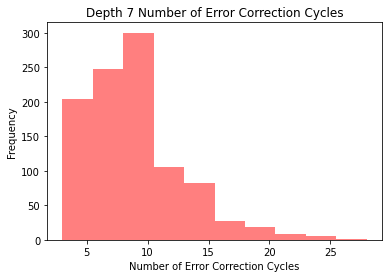

Mean: 8.682
Standard Deviation: 3.8663776328755057


In [33]:
num_bins_7 = 10
plt.hist(d7_dist, num_bins_7, facecolor='r', alpha=.5)
plt.gca().set(title='Depth 7 Number of Error Correction Cycles', xlabel = "Number of Error Correction Cycles", ylabel='Frequency')
plt.show()
mean_d7 = sum(d7_dist) / len(d7_dist)
mean_d3 = sum(d3_dist) / len(d3_dist)
sd_d7 = statistics.pstdev(d7_dist) 
print('Mean: ' + str(mean_d7))
print('Standard Deviation: ' + str(sd_d7))

In [45]:
d7_dist_baseline = [25, 32, 24, 21, 20, 31, 19, 25, 37, 14, 21, 32, 7, 36, 47, 16, 13, 10, 19, 20, 21, 31, 18, 13, 14, 13, 19, 22, 19, 22, 15, 10, 29, 20, 21, 22, 40, 15, 16, 7, 17, 21, 20, 21, 13, 19, 18, 15, 32, 13, 6, 23, 23, 19, 25, 18, 35, 33, 33, 11, 21, 5, 39, 18, 41, 28, 16, 53, 20, 17, 11, 10, 34, 3, 21, 10, 13, 20, 28, 28, 13, 7, 38, 7, 19, 22, 13, 15, 29, 30, 28, 15, 16, 21, 18, 14, 19, 21, 46, 16, 13, 17, 36, 21, 34, 12, 16, 10, 22, 14, 24, 16, 15, 26, 12, 10, 42, 14, 21, 21, 22, 18, 15, 18, 25, 16, 19, 40, 11, 18, 10, 12, 35, 46, 19, 24, 16, 14, 20, 15, 33, 17, 16, 11, 32, 18, 16, 13, 54, 36, 29, 28, 17, 21, 23, 14, 17, 16, 19, 24, 27, 29, 5, 33, 52, 14, 16, 31, 23, 12, 31, 18, 14, 27, 32, 18, 30, 14, 17, 7, 43, 25, 39, 23, 14, 29, 24, 12, 10, 9, 17, 21, 18, 18, 13, 13, 35, 29, 28, 32, 16, 21, 15, 9, 18, 12, 42, 11, 30, 25, 22, 7, 22, 13, 13, 10, 6, 26, 14, 35, 39, 30, 14, 22, 23, 21, 8, 31, 22, 12, 33, 20, 9, 25, 21, 21, 31, 24, 5, 21, 7, 37, 21, 9, 11, 13, 44, 23, 32, 45, 17, 21, 35, 16, 14, 19, 14, 17, 51, 19, 38, 20, 17, 9, 10, 31, 26, 28, 16, 16, 19, 17, 20, 10, 33, 12, 32, 33, 22, 23, 22, 15, 34, 27, 32, 23, 22, 7, 12, 17, 19, 24, 28, 25, 45, 32, 23, 20, 13, 17, 21, 14, 20, 12, 13, 14, 44, 26, 38, 15, 13, 33, 13, 13, 17, 23, 8, 10, 22, 17, 13, 29, 13, 23, 35, 22, 12, 22, 32, 11, 15, 9, 20, 15, 16, 16, 37, 26, 14, 18, 23, 14, 23, 25, 15, 26, 16, 23, 38, 19, 11, 8, 16, 15, 25, 28, 35, 20, 31, 13, 24, 15, 9, 46, 27, 18, 36, 24, 8, 16, 16, 37, 17, 17, 16, 24, 27, 39, 13, 22, 17, 40, 23, 16, 28, 21, 10, 28, 13, 8, 15, 42, 22, 26, 8, 18, 37, 16, 12, 23, 15, 19, 29, 21, 42, 33, 44, 26, 24, 21, 16, 8, 25, 28, 14, 36, 22, 14, 23, 28, 22, 12, 26, 25, 14, 15, 17, 15, 35, 19, 12, 29, 18, 47, 11, 29, 17, 26, 32, 17, 19, 28, 15, 21, 22, 33, 17, 10, 17, 30, 52, 25, 33, 29, 18, 10, 26, 15, 17, 12, 14, 25, 21, 41, 8, 18, 11, 8, 12, 23, 23, 25, 23, 15, 50, 40, 25, 17, 12, 8, 16, 19, 13, 24, 20, 12, 39, 7, 14, 16, 13, 31, 15, 17, 13, 30, 31, 23, 8, 17, 21, 13, 21, 26, 14, 23, 17, 22, 23, 17, 20, 18, 30, 17, 23, 11, 8, 26, 19, 14, 21, 16, 21, 20, 15, 22, 10, 37, 11, 11, 26, 65, 17, 19, 19, 16, 26, 16, 17, 7, 29, 25, 42, 6, 22, 15, 11, 14, 14, 22, 47, 16, 16, 11, 11, 18, 51, 34, 17, 16, 35, 34, 23, 12, 30, 18, 36, 17, 8, 9, 16, 23, 12, 42, 16, 18, 13, 22, 14, 18, 17, 16, 22, 30, 13, 26, 32, 26, 13, 29, 12, 23, 22, 16, 16, 16, 72, 13, 37, 21, 26, 20, 21, 39, 15, 30, 16, 33, 6, 23, 22, 17, 26, 8, 17, 18, 23, 27, 31, 8, 10, 65, 6, 20, 23, 6, 16, 15, 17, 21, 43, 11, 8, 7, 39, 24, 28, 18, 25, 9, 24, 54, 46, 17, 13, 21, 19, 28, 20, 16, 28, 10, 16, 20, 26, 31, 8, 22, 33, 19, 20, 36, 15, 8, 21, 9, 14, 13, 10, 27, 7, 22, 14, 27, 25, 7, 29, 21, 19, 8, 23, 19, 31, 40, 27, 43, 19, 15, 21, 19, 21, 16, 9, 16, 29, 13, 18, 17, 13, 15, 10, 18, 28, 23, 21, 11, 9, 12, 35, 15, 14, 34, 35, 33, 16, 23, 20, 21, 48, 24, 11, 33, 29, 12, 21, 9, 10, 14, 13, 17, 19, 17, 22, 24, 13, 66, 13, 37, 31, 16, 22, 24, 29, 31, 17, 20, 11, 11, 27, 29, 27, 11, 32, 22, 15, 16, 18, 28, 25, 33, 36, 26, 39, 12, 16, 13, 14, 28, 32, 12, 20, 21, 16, 10, 31, 16, 27, 23, 20, 31, 8, 20, 11, 31, 32, 5, 45, 10, 20, 25, 22, 31, 15, 27, 11, 21, 9, 28, 24, 15, 22, 12, 28, 18, 14, 24, 21, 74, 16, 9, 20, 21, 10, 22, 23, 16, 9, 10, 24, 20, 21, 12, 4, 11, 16, 31, 17, 13, 10, 26, 9, 31, 28, 32, 19, 18, 10, 23, 19, 47, 13, 16, 19, 18, 36, 25, 19, 27, 13, 15, 30, 16, 19, 46, 10, 25, 32, 27, 27, 11, 22, 31, 11, 33, 25, 22, 18, 9, 11, 25, 23, 17, 33, 24, 10, 15, 17, 19, 26, 27, 20, 12, 17, 49, 22, 15, 35, 28, 9, 23, 24, 24, 14, 25, 32, 32, 8, 30, 12, 32, 16, 11, 22, 31, 11, 19, 28, 11, 9, 27, 22, 50, 39, 15, 28, 16, 13, 21, 35, 34, 9, 17, 23, 34, 27, 9, 15, 80, 18, 17, 9, 29, 13, 12, 10, 11, 15, 21, 25, 9, 18, 27, 13, 29, 34, 16, 10, 28, 30, 25, 27, 12, 51, 16, 20, 15, 29, 9, 29, 12, 15, 38, 32, 42, 32, 33, 13, 32, 31, 24, 44, 19, 22, 21, 27, 14, 25, 22, 10, 17, 19, 14, 12, 9, 33, 17, 12, 10, 15, 15, 31, 12, 6, 21, 37, 43, 25, 10, 24, 8]
d7_dist_v2_10k = [3, 3, 7, 2, 4, 5, 3, 2, 5, 4, 4, 3, 4, 4, 2, 3, 3, 3, 5, 6, 3, 3, 3, 3, 2, 3, 4, 2, 3, 4, 6, 5, 6, 4, 2, 3, 2, 4, 3, 5, 5, 3, 4, 3, 4, 4, 5, 4, 5, 4, 5, 2, 6, 4, 3, 3, 5, 4, 5, 3, 3, 7, 3, 5, 3, 3, 4, 7, 3, 3, 3, 3, 4, 3, 5, 3, 2, 3, 3, 6, 3, 4, 3, 2, 8, 4, 5, 3, 3, 4, 4, 3, 4, 3, 4, 3, 3, 2, 4, 2, 2, 2, 4, 4, 4, 3, 3, 3, 6, 5, 4, 6, 5, 3, 3, 2, 3, 3, 3, 2, 5, 4, 2, 4, 6, 3, 4, 3, 2, 4, 5, 5, 4, 4, 4, 3, 2, 4, 3, 4, 5, 4, 4, 5, 4, 4, 4, 4, 2, 3, 5, 5, 6, 4, 4, 6, 4, 4, 5, 3, 2, 4, 4, 4, 4, 3, 2, 3, 4, 4, 3, 3, 7, 3, 2, 5, 4, 5, 5, 2, 4, 3, 4, 3, 3, 3, 2, 3, 3, 5, 3, 3, 3, 4, 3, 3, 3, 5, 4, 6, 3, 3, 4, 4, 4, 4, 5, 5, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 2, 5, 3, 4, 3, 2, 5, 5, 9, 2, 3, 4, 3, 4, 3, 2, 5, 6, 6, 3, 3, 3, 3, 4, 3, 7, 4, 4, 3, 3, 4, 3, 4, 4, 4, 2, 3, 6, 2, 4, 4, 4, 3, 3, 3, 5, 6, 3, 3, 2, 4, 3, 3, 4, 4, 3, 3, 4, 4, 5, 3, 4, 3, 4, 4, 3, 4, 5, 2, 5, 3, 2, 6, 5, 5, 6, 5, 3, 5, 5, 3, 9, 3, 2, 3, 3, 2, 3, 3, 2, 4, 5, 4, 3, 3, 3, 2, 5, 5, 4, 2, 4, 8, 4, 3, 2, 3, 3, 4, 2, 4, 2, 4, 4, 2, 3, 3, 3, 3, 4, 3, 5, 3, 5, 4, 4, 3, 2, 2, 3, 4, 3, 4, 3, 3, 4, 4, 4, 7, 3, 5, 3, 4, 4, 3, 3, 4, 2, 3, 3, 2, 5, 7, 3, 4, 3, 4, 2, 3, 3, 3, 3, 4, 6, 4, 3, 2, 2, 3, 5, 4, 4, 5, 3, 3, 5, 4, 5, 4, 6, 4, 3, 5, 3, 2, 3, 7, 3, 5, 3, 6, 2, 3, 3, 5, 4, 2, 4, 4, 3, 4, 3, 3, 6, 4, 3, 3, 4, 5, 3, 4, 5, 3, 3, 3, 3, 4, 5, 5, 4, 4, 3, 3, 6, 5, 4, 3, 3, 3, 3, 4, 6, 4, 3, 3, 4, 6, 4, 3, 6, 3, 3, 5, 3, 3, 3, 3, 4, 4, 2, 3, 2, 7, 4, 4, 3, 3, 6, 4, 3, 2, 4, 4, 4, 3, 4, 3, 4, 2, 2, 4, 2, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4, 5, 4, 5, 5, 3, 3, 3, 3, 5, 5, 5, 3, 4, 4, 4, 3, 3, 6, 3, 3, 3, 4, 2, 2, 3, 5, 3, 4, 2, 5, 4, 5, 4, 4, 4, 3, 3, 3, 2, 4, 3, 3, 4, 3, 4, 4, 3, 4, 5, 6, 4, 5, 5, 3, 2, 3, 4, 3, 2, 5, 2, 4, 3, 2, 3, 3, 5, 2, 4, 4, 4, 6, 4, 3, 4, 4, 4, 5, 2, 5, 3, 4, 5, 3, 4, 2, 5, 4, 4, 4, 4, 5, 3, 3, 2, 3, 5, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 3, 2, 4, 5, 3, 4, 4, 2, 6, 2, 3, 5, 5, 3, 5, 5, 3, 4, 4, 4, 4, 3, 4, 3, 3, 4, 3, 6, 4, 2, 4, 3, 2, 3, 5, 4, 4, 6, 3, 4, 6, 5, 3, 2, 3, 4, 5, 5, 4, 4, 3, 3, 4, 3, 5, 2, 3, 3, 3, 2, 5, 4, 5, 4, 3, 3, 3, 3, 4, 4, 2, 2, 3, 7, 4, 4, 3, 5, 4, 5, 2, 4, 6, 4, 3, 4, 2, 3, 3, 5, 4, 4, 5, 2, 5, 4, 3, 5, 3, 4, 2, 4, 5, 5, 3, 3, 4, 4, 5, 4, 5, 3, 4, 5, 4, 3, 3, 3, 3, 5, 2, 5, 3, 4, 2, 5, 4, 3, 4, 4, 4, 3, 5, 3, 4, 3, 2, 2, 4, 4, 2, 2, 5, 3, 5, 3, 3, 4, 4, 5, 4, 3, 3, 4, 3, 4, 3, 3, 3, 2, 3, 4, 3, 2, 2, 4, 4, 4, 3, 4, 3, 5, 3, 2, 3, 2, 7, 4, 2, 3, 6, 4, 5, 5, 6, 3, 5, 4, 4, 5, 3, 5, 3, 2, 6, 3, 4, 4, 5, 2, 2, 4, 5, 3, 3, 3, 5, 3, 6, 3, 3, 5, 4, 4, 4, 3, 3, 6, 4, 2, 4, 3, 4, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 3, 5, 3, 3, 4, 4, 5, 4, 4, 3, 3, 3, 5, 3, 3, 2, 6, 4, 2, 5, 4, 5, 3, 3, 3, 5, 2, 3, 3, 5, 4, 8, 4, 3, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 5, 6, 5, 2, 2, 2, 3, 5, 2, 4, 5, 4, 5, 5, 4, 6, 4, 4, 2, 4, 6, 3, 5, 3, 3, 4, 5, 4, 3, 5, 3, 2, 3, 4, 4, 2, 4, 4, 5, 3, 5, 7, 4, 4, 2, 4, 2, 6, 4, 8, 2, 4, 3, 6, 3, 5, 5, 5, 4, 5, 3, 4, 4, 4, 4, 4, 4, 5, 3, 3, 2, 3, 2, 5, 2, 5, 6, 3, 2, 6, 3, 4, 5, 4, 2, 2, 3, 3, 3, 4, 6, 3, 6, 2, 3, 2, 4, 5, 3, 5, 3, 3, 3, 3, 2, 2, 3, 4, 5, 4, 2, 4]
d7_dist_v2_100k = [11, 19, 12, 10, 4, 7, 5, 8, 9, 4, 8, 4, 5, 13, 5, 8, 6, 7, 13, 10, 11, 5, 16, 6, 10, 10, 7, 6, 9, 9, 8, 8, 10, 7, 12, 7, 5, 10, 5, 7, 5, 9, 8, 9, 15, 11, 5, 9, 5, 8, 10, 6, 7, 6, 4, 7, 8, 11, 7, 12, 5, 4, 8, 13, 13, 14, 5, 5, 10, 14, 13, 14, 9, 4, 13, 7, 7, 11, 8, 5, 6, 6, 7, 5, 20, 6, 5, 6, 11, 16, 6, 5, 5, 13, 6, 6, 7, 5, 4, 8, 7, 4, 4, 8, 8, 3, 8, 11, 5, 9, 5, 6, 3, 13, 20, 15, 13, 6, 7, 5, 7, 9, 7, 7, 6, 7, 9, 6, 21, 10, 5, 4, 3, 8, 6, 7, 5, 4, 7, 14, 6, 12, 6, 14, 8, 7, 8, 11, 13, 10, 12, 4, 13, 9, 10, 10, 11, 8, 14, 9, 6, 5, 7, 5, 10, 9, 6, 5, 11, 9, 4, 3, 13, 9, 7, 5, 11, 11, 14, 5, 6, 8, 6, 6, 6, 11, 16, 6, 10, 10, 5, 10, 6, 5, 6, 9, 5, 11, 6, 5, 9, 7, 15, 5, 9, 6, 7, 5, 6, 7, 14, 5, 8, 7, 10, 12, 10, 5, 4, 14, 9, 7, 6, 7, 7, 10, 9, 15, 5, 5, 12, 5, 14, 5, 9, 2, 7, 8, 9, 9, 5, 7, 9, 8, 6, 5, 4, 10, 6, 5, 12, 5, 12, 4, 13, 8, 10, 6, 5, 4, 6, 13, 9, 7, 9, 10, 7, 9, 7, 11, 7, 12, 2, 5, 16, 8, 7, 13, 9, 6, 6, 6, 5, 11, 9, 6, 6, 10, 8, 10, 4, 11, 7, 12, 6, 10, 7, 9, 9, 5, 8, 6, 4, 3, 9, 7, 7, 6, 7, 5, 9, 11, 10, 5, 10, 10, 9, 10, 10, 8, 7, 7, 14, 11, 6, 9, 11, 8, 14, 8, 9, 8, 7, 8, 8, 6, 12, 5, 9, 11, 5, 6, 8, 5, 9, 11, 14, 13, 13, 5, 10, 14, 8, 8, 10, 15, 4, 9, 6, 7, 4, 12, 8, 15, 11, 9, 6, 6, 9, 9, 3, 9, 7, 16, 8, 5, 6, 8, 7, 8, 9, 6, 19, 14, 5, 3, 5, 7, 9, 14, 10, 4, 9, 6, 7, 8, 12, 13, 7, 12, 10, 8, 9, 6, 7, 12, 5, 3, 8, 6, 10, 3, 18, 8, 4, 14, 4, 8, 8, 7, 9, 9, 6, 7, 5, 8, 5, 13, 6, 13, 11, 10, 6, 4, 10, 4, 6, 14, 7, 7, 11, 7, 12, 5, 8, 10, 7, 18, 7, 9, 3, 7, 19, 3, 5, 7, 8, 6, 4, 6, 5, 10, 7, 5, 20, 6, 7, 7, 8, 6, 16, 5, 11, 10, 5, 8, 6, 15, 8, 5, 7, 9, 13, 9, 5, 4, 7, 9, 9, 4, 8, 8, 5, 7, 5, 4, 9, 5, 9, 5, 7, 10, 8, 5, 10, 8, 5, 8, 9, 7, 6, 11, 14, 9, 18, 12, 8, 8, 8, 5, 7, 5, 6, 14, 8, 11, 12, 10, 4, 7, 4, 7, 8, 8, 6, 6, 19, 3, 6, 3, 5, 11, 13, 11, 8, 4, 8, 13, 7, 4, 10, 5, 8, 7, 17, 6, 9, 7, 9, 7, 12, 5, 6, 16, 4, 6, 8, 14, 8, 11, 10, 8, 14, 8, 9, 16, 11, 12, 7, 9, 10, 6, 8, 6, 6, 7, 5, 4, 8, 5, 8, 5, 8, 4, 11, 4, 7, 9, 6, 6, 6, 8, 13, 7, 3, 10, 6, 12, 4, 6, 13, 6, 4, 5, 6, 11, 9, 4, 10, 13, 7, 12, 7, 8, 9, 12, 9, 3, 16, 12, 6, 4, 6, 11, 7, 5, 8, 3, 5, 9, 6, 7, 9, 17, 20, 5, 8, 9, 9, 8, 8, 8, 9, 8, 6, 17, 6, 8, 15, 6, 10, 7, 24, 16, 6, 9, 6, 14, 9, 5, 9, 8, 11, 8, 14, 7, 9, 5, 10, 7, 7, 16, 11, 17, 7, 9, 6, 15, 5, 5, 7, 6, 7, 22, 9, 9, 7, 9, 11, 9, 4, 8, 8, 10, 6, 10, 9, 7, 7, 6, 12, 3, 5, 7, 10, 5, 9, 12, 14, 14, 4, 7, 7, 9, 10, 15, 9, 6, 8, 6, 6, 5, 6, 6, 9, 8, 11, 7, 13, 5, 16, 9, 6, 7, 13, 11, 9, 12, 11, 12, 8, 5, 4, 4, 12, 7, 5, 4, 9, 9, 13, 13, 13, 8, 17, 13, 8, 10, 7, 8, 7, 6, 8, 13, 20, 7, 4, 7, 8, 14, 5, 5, 9, 15, 8, 9, 9, 9, 11, 10, 4, 4, 7, 9, 6, 6, 5, 3, 12, 9, 6, 6, 9, 11, 7, 10, 6, 4, 19, 12, 12, 7, 8, 17, 3, 9, 4, 12, 9, 9, 10, 7, 8, 7, 11, 7, 9, 11, 5, 5, 14, 6, 4, 6, 12, 16, 7, 12, 8, 13, 8, 5, 15, 13, 4, 5, 5, 10, 14, 7, 10, 10, 8, 7, 6, 13, 9, 14, 5, 16, 5, 6, 16, 7, 5, 9, 9, 8, 7, 6, 6, 7, 13, 6, 7, 5, 6, 4, 14, 6, 8, 7, 9, 6, 7, 6, 7, 9, 18, 7, 9, 8, 3, 9, 9, 11, 6, 5, 4, 5, 9, 13, 14, 11, 10, 4, 4, 8, 10, 8, 11, 14, 5, 7, 6, 9, 11, 9, 5, 14, 9, 19, 14, 9, 6, 11, 6, 10, 6, 4, 7, 9, 10, 6, 7, 7, 6, 9, 7, 12, 6, 11, 14, 11, 7, 4, 12, 14, 4, 8, 10, 9, 10, 10, 5, 5, 3, 20, 10, 6, 8, 8, 8, 8, 8, 7, 5, 6, 7, 9, 7, 7, 5, 13, 6, 9, 8, 14, 6, 7, 12, 8, 7, 6, 4, 7, 12, 7, 10, 10, 10, 8, 10, 10, 7, 7, 8, 5, 17, 4]
d7_dist_v2_500k = [18, 7, 8, 9, 8, 14, 9, 13, 11, 15, 11, 13, 11, 7, 9, 26, 5, 12, 7, 9, 16, 9, 3, 13, 11, 7, 12, 5, 6, 9, 18, 10, 13, 5, 16, 22, 6, 14, 7, 13, 7, 18, 10, 7, 15, 12, 12, 11, 12, 8, 21, 7, 8, 15, 11, 8, 12, 7, 8, 12, 8, 11, 8, 11, 11, 11, 20, 10, 13, 7, 16, 7, 11, 14, 10, 10, 10, 11, 10, 4, 5, 14, 12, 16, 12, 5, 12, 6, 10, 8, 9, 14, 9, 15, 9, 12, 9, 13, 11, 7, 8, 6, 8, 6, 6, 12, 5, 8, 13, 5, 13, 5, 8, 13, 7, 12, 17, 11, 17, 15, 9, 11, 8, 10, 6, 18, 8, 9, 8, 7, 9, 13, 10, 12, 4, 8, 12, 19, 8, 8, 8, 14, 11, 11, 7, 10, 5, 5, 13, 6, 11, 9, 8, 10, 16, 12, 7, 9, 11, 9, 22, 10, 8, 8, 15, 15, 6, 11, 7, 8, 7, 15, 14, 11, 9, 14, 20, 5, 11, 13, 9, 8, 14, 8, 20, 6, 20, 7, 7, 13, 14, 12, 8, 8, 7, 6, 13, 13, 7, 14, 5, 6, 13, 10, 13, 18, 7, 11, 11, 6, 7, 6, 6, 11, 14, 17, 13, 13, 13, 10, 10, 12, 12, 12, 9, 13, 14, 7, 11, 5, 6, 15, 9, 19, 10, 6, 8, 7, 10, 14, 10, 14, 7, 9, 11, 7, 12, 24, 5, 6, 19, 8, 12, 8, 9, 7, 11, 16, 15, 18, 12, 18, 5, 12, 11, 6, 9, 8, 9, 6, 16, 7, 5, 19, 8, 14, 8, 6, 5, 4, 9, 11, 9, 18, 15, 11, 4, 9, 10, 5, 19, 11, 11, 21, 9, 6, 16, 6, 7, 19, 6, 8, 15, 6, 9, 11, 11, 12, 5, 7, 17, 7, 6, 7, 15, 14, 9, 15, 11, 10, 5, 6, 6, 21, 6, 7, 17, 5, 16, 7, 15, 11, 7, 13, 14, 8, 15, 7, 10, 13, 11, 11, 13, 6, 11, 10, 7, 10, 7, 16, 9, 8, 8, 12, 10, 10, 6, 16, 7, 7, 23, 13, 9, 8, 11, 14, 13, 8, 23, 11, 10, 9, 8, 6, 20, 9, 14, 9, 10, 4, 5, 8, 10, 7, 11, 8, 9, 11, 10, 6, 10, 9, 8, 9, 7, 11, 6, 11, 6, 12, 14, 12, 12, 8, 9, 16, 16, 13, 10, 10, 10, 11, 12, 15, 7, 6, 11, 11, 11, 9, 7, 11, 13, 7, 9, 8, 7, 12, 11, 8, 11, 10, 9, 5, 9, 14, 9, 8, 12, 8, 9, 7, 16, 9, 8, 14, 5, 14, 13, 11, 13, 6, 8, 5, 7, 12, 6, 9, 11, 9, 9, 8, 9, 11, 7, 10, 11, 5, 13, 14, 10, 8, 7, 13, 5, 17, 8, 11, 9, 10, 13, 19, 9, 13, 8, 12, 6, 8, 7, 8, 6, 8, 15, 10, 15, 19, 7, 10, 7, 7, 11, 13, 10, 8, 11, 13, 14, 10, 5, 18, 5, 7, 10, 10, 7, 9, 9, 7, 7, 9, 9, 10, 10, 9, 8, 11, 7, 9, 8, 12, 12, 8, 7, 10, 10, 10, 20, 21, 14, 7, 6, 12, 10, 4, 10, 6, 14, 9, 5, 14, 5, 9, 15, 10, 5, 5, 11, 9, 6, 10, 14, 7, 15, 12, 5, 8, 9, 9, 15, 13, 8, 10, 12, 7, 11, 9, 7, 12, 6, 10, 4, 9, 11, 10, 6, 9, 18, 12, 9, 6, 7, 9, 7, 6, 11, 8, 8, 10, 9, 7, 7, 11, 10, 11, 13, 10, 9, 10, 8, 11, 7, 12, 9, 7, 9, 10, 10, 5, 7, 11, 22, 6, 10, 8, 9, 15, 6, 17, 7, 4, 6, 6, 12, 8, 16, 11, 7, 10, 12, 11, 12, 15, 5, 12, 18, 8, 10, 14, 12, 10, 7, 22, 8, 5, 14, 9, 14, 7, 6, 6, 9, 10, 16, 9, 5, 10, 16, 7, 11, 5, 7, 13, 6, 16, 6, 21, 8, 15, 13, 8, 12, 12, 16, 5, 13, 12, 10, 8, 6, 8, 4, 14, 10, 10, 11, 10, 10, 7, 10, 8, 14, 7, 6, 7, 17, 5, 7, 14, 10, 15, 7, 11, 10, 10, 14, 7, 7, 9, 5, 16, 14, 4, 13, 14, 11, 11, 5, 4, 8, 6, 11, 5, 9, 13, 6, 25, 10, 5, 10, 15, 8, 21, 10, 24, 11, 16, 15, 18, 10, 5, 13, 6, 11, 11, 15, 6, 10, 14, 12, 8, 8, 8, 9, 17, 9, 14, 7, 10, 11, 7, 6, 11, 12, 8, 11, 5, 10, 8, 15, 8, 6, 6, 13, 13, 6, 10, 8, 10, 10, 10, 13, 12, 11, 9, 16, 7, 14, 11, 7, 9, 6, 9, 7, 8, 14, 3, 10, 10, 8, 8, 12, 8, 13, 6, 9, 11, 8, 11, 12, 12, 6, 6, 16, 18, 14, 17, 15, 7, 5, 16, 7, 9, 14, 5, 8, 16, 6, 17, 7, 7, 12, 11, 5, 13, 10, 5, 5, 8, 13, 9, 15, 14, 14, 9, 6, 9, 8, 6, 10, 4, 9, 6, 10, 11, 12, 12, 10, 10, 15, 4, 6, 15, 13, 9, 14, 9, 9, 10, 5, 11, 4, 14, 8, 7, 11, 12, 11, 8, 10, 9, 8, 10, 8, 4, 9, 6, 5, 9, 8, 5, 7, 5, 6, 13, 15, 15, 6, 13, 5, 7, 17, 7, 9, 8, 10, 10, 15, 9, 9, 4, 5, 14, 10, 8, 9, 6, 9, 13, 5, 22, 5, 13, 8, 8, 8, 8, 15, 11, 10, 11, 9, 8, 7, 6, 10, 14, 11, 6, 17, 15, 10, 9, 11, 9, 14, 21, 11, 13, 11, 11, 7, 10, 7, 7, 10, 12, 11, 6, 20, 13, 7, 18, 6, 12, 8, 21, 16, 10, 5, 20, 23, 5, 14, 12, 10, 11, 18, 17, 6, 12, 9, 15, 12, 7, 11, 11, 13, 8, 6, 10]
d7_dist_v3_1k = [7, 6, 5, 6, 5, 7, 7, 7, 7, 8, 4, 7, 6, 5, 5, 6, 6, 7, 8, 5, 6, 7, 7, 6, 6, 7, 8, 8, 5, 5, 6, 7, 8, 6, 6, 5, 6, 6, 6, 6, 7, 6, 5, 5, 7, 6, 6, 5, 6, 6, 7, 7, 5, 8, 7, 6, 6, 5, 6, 6, 7, 5, 5, 6, 6, 6, 6, 7, 8, 7, 6, 5, 6, 6, 6, 7, 5, 5, 7, 6, 6, 5, 7, 7, 6, 6, 6, 6, 7, 6, 6, 5, 7, 6, 5, 7, 6, 5, 5, 5, 5, 7, 7, 7, 6, 7, 6, 7, 7, 7, 6, 6, 7, 7, 6, 6, 5, 6, 8, 6, 6, 6, 5, 7, 6, 6, 7, 5, 6, 5, 7, 6, 5, 5, 5, 5, 6, 7, 6, 7, 6, 7, 6, 7, 8, 6, 5, 6, 6, 6, 6, 8, 7, 6, 6, 5, 7, 7, 6, 6, 8, 8, 6, 7, 6, 6, 6, 6, 5, 8, 7, 5, 6, 6, 6, 6, 5, 6, 7, 7, 6, 6, 5, 5, 7, 7, 6, 5, 7, 6, 6, 6, 6, 6, 5, 5, 7, 6, 4, 4, 7, 6, 7, 6, 7, 6, 5, 6, 5, 6, 6, 5, 7, 7, 7, 7, 8, 6, 8, 7, 8, 5, 7, 7, 6, 5, 6, 6, 6, 7, 7, 5, 6, 7, 6, 6, 6, 6, 6, 5, 7, 6, 6, 7, 8, 7, 7, 5, 7, 4, 8, 5, 6, 6, 7, 6, 7, 6, 7, 6, 5, 7, 7, 6, 5, 6, 6, 6, 8, 7, 5, 6, 6, 6, 6, 4, 6, 6, 6, 7, 6, 7, 6, 7, 6, 8, 6, 6, 6, 5, 6, 4, 5, 6, 5, 6, 8, 5, 6, 7, 7, 5, 7, 6, 6, 6, 7, 5, 5, 6, 6, 6, 6, 7, 7, 7, 6, 5, 7, 6, 5, 6, 6, 5, 7, 7, 6, 5, 6, 6, 5, 6, 6, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 7, 7, 6, 7, 7, 6, 6, 6, 8, 5, 5, 8, 7, 6, 7, 5, 7, 7, 7, 7, 6, 6, 6, 6, 8, 7, 5, 7, 6, 7, 5, 6, 7, 5, 4, 8, 6, 7, 6, 6, 5, 6, 5, 7, 6, 6, 6, 5, 7, 7, 6, 5, 7, 8, 5, 7, 7, 6, 5, 6, 6, 5, 4, 7, 5, 7, 7, 6, 5, 6, 7, 7, 7, 6, 7, 5, 5, 6, 5, 6, 6, 6, 6, 5, 6, 7, 6, 6, 7, 7, 7, 7, 7, 6, 6, 7, 5, 6, 7, 6, 7, 6, 6, 6, 6, 5, 6, 5, 6, 8, 6, 6, 5, 7, 7, 8, 6, 5, 6, 6, 7, 6, 6, 6, 7, 7, 7, 6, 7, 6, 5, 7, 5, 6, 6, 6, 5, 5, 7, 6, 6, 5, 5, 5, 6, 6, 7, 8, 8, 6, 6, 6, 7, 5, 8, 6, 6, 6, 8, 7, 5, 5, 8, 5, 7, 7, 6, 6, 5, 6, 5, 7, 8, 5, 7, 6, 6, 6, 6, 7, 7, 6, 5, 7, 7, 6, 6, 7, 7, 8, 7, 6, 6, 6, 5, 6, 6, 7, 6, 4, 5, 5, 6, 7, 5, 6, 7, 7, 7, 6, 6, 7, 8, 5, 7, 6, 7, 7, 7, 7, 5, 8, 7, 8, 6, 6, 4, 5, 7, 6, 7, 6, 7, 6, 6, 5, 7, 5, 6, 7, 5, 5, 6, 6, 7, 6, 5, 7, 4, 6, 7, 5, 5, 7, 7, 7, 6, 7, 5, 5, 6, 7, 6, 5, 7, 5, 4, 6, 5, 6, 6, 5, 7, 5, 6, 6, 7, 6, 7, 5, 6, 6, 6, 6, 7, 6, 5, 7, 6, 7, 6, 7, 6, 7, 5, 7, 7, 5, 7, 7, 7, 6, 5, 6, 7, 6, 5, 8, 6, 6, 7, 6, 6, 6, 7, 7, 5, 5, 7, 7, 7, 5, 8, 5, 7, 7, 5, 6, 7, 5, 6, 5, 6, 6, 5, 5, 6, 7, 6, 7, 6, 8, 7, 6, 6, 5, 6, 6, 8, 5, 6, 6, 6, 6, 8, 5, 6, 5, 7, 8, 7, 6, 5, 7, 5, 5, 6, 7, 7, 5, 5, 5, 4, 5, 6, 5, 6, 5, 8, 7, 7, 6, 6, 7, 6, 6, 6, 4, 7, 7, 6, 7, 6, 6, 7, 7, 5, 5, 6, 7, 6, 5, 7, 7, 5, 7, 6, 7, 7, 6, 6, 6, 6, 7, 6, 7, 5, 6, 6, 6, 5, 7, 5, 6, 5, 7, 5, 6, 6, 5, 6, 6, 6, 6, 5, 7, 6, 6, 7, 7, 6, 8, 6, 6, 7, 7, 6, 6, 6, 7, 6, 7, 6, 7, 6, 6, 6, 7, 7, 5, 6, 7, 8, 6, 5, 6, 5, 7, 5, 6, 7, 6, 7, 8, 5, 6, 7, 7, 6, 5, 6, 5, 6, 7, 6, 6, 6, 6, 5, 6, 5, 6, 5, 6, 5, 5, 6, 6, 7, 5, 7, 5, 6, 8, 6, 6, 6, 5, 7, 5, 7, 5, 7, 6, 5, 7, 6, 7, 5, 7, 6, 7, 6, 6, 6, 6, 7, 6, 7, 6, 7, 7, 5, 6, 4, 6, 6, 6, 6, 7, 7, 7, 5, 6, 5, 6, 7, 7, 6, 5, 6, 6, 6, 6, 6, 7, 7, 6, 6, 7, 5, 6, 6, 5, 5, 6, 7, 4, 6, 8, 5, 6, 7, 6, 5, 5, 7, 6, 7, 5, 5, 7, 6, 5, 5, 7, 5, 7, 6, 7, 6, 6, 5, 6, 6, 7, 7, 6, 6, 6, 7, 7, 5, 5, 7, 6, 6, 7, 6, 6, 5, 6, 7, 7, 6, 8, 7, 5, 7, 5, 6, 6, 5, 7, 5, 7, 6, 6, 5, 7, 6, 7, 7, 6, 7, 7, 6, 7, 7, 6, 7, 5, 8, 6, 6, 7, 8, 6, 7, 7, 6, 6, 6, 5, 6, 5, 7]

#stats.kruskal(d7_dist_baseline, d7_dist_v2_10k)
#stats.kruskal(d7_dist_baseline, d7_dist_v2_100k)
#stats.kruskal(d7_dist_baseline, d7_dist_v2_500k)
stats.kruskal(d7_dist_baseline, d7_dist_v3_1k)

KruskalResult(statistic=1445.819347820768, pvalue=0.0)